In [1]:
import numpy as np
from scipy.optimize import root_scalar
from scipy.optimize import brentq
import matplotlib.pyplot as plt

# Functions

In [2]:
#parameters
t_1 = 0.425
t_2 = 0.05
t_3 = -0.025
t_4 = -0.075
kB = 8.617e-5
T=0.1

# k-grid
n_k = 150
kx = np.linspace(-np.pi, np.pi, n_k)
ky = np.linspace(-np.pi, np.pi, n_k)
KX, KY = np.meshgrid(kx, ky)



In [3]:
def epsilon(k_x,k_y,t_1,t_2,t_3,mu,epsi):
    return -2*t_2*(np.cos(k_x)+np.cos(k_y))-4*t_3*np.cos(k_x)*np.cos(k_y)-mu

def tx(k_x,k_y,t_1,epsi):
    return -4*t_1*np.exp(-1j*(k_x/2+k_y/2))*(np.cos(k_x/2)*np.cos(k_y/2)-epsi*np.sin(k_x/2)*np.sin(k_y/2))

def tz(k_x,k_y,t_4,epsi):
    return 4*t_4*np.sin(k_x)*np.sin(k_y)

In [4]:
def dispersion(k_x,k_y,sigma,N_A,N_B,U,mu,beta,epsi):
    return epsilon(k_x,k_y,t_1,t_2,t_3,mu,epsi)-U/4*sigma*(N_A+N_B)+beta*np.sqrt(np.abs(tx(k_x,k_y,t_1,epsi))**2+(tz(k_x,k_y,t_4,epsi)-U/4*sigma*(N_A-N_B))**2)

def fermi(E, T, mu=0):
    if T == 0:
        return np.where(E < mu, 1.0, 0.0)
    else:
        x = (E ) / (kB * T)
        x = np.clip(x, -700, 700)
        return 1/ (np.exp(x) + 1)

def energy_split(k_x,k_y,N_A,N_B,U,mu,epsi):
    E_up_plus=dispersion(k_x,k_y,1,N_A,N_B,U,mu,1,epsi)
    E_up_minus=dispersion(k_x,k_y,1,N_A,N_B,U,mu,-1,epsi)
    E_down_plus=dispersion(k_x,k_y,-1,N_A,N_B,U,mu,1,epsi)
    E_down_minus=dispersion(k_x,k_y,-1,N_A,N_B,U,mu,-1,epsi)
    return E_up_plus,E_up_minus,E_down_plus,E_down_minus

In [5]:
#eigenvectors

def a(sigma, N_A,N_B, U,epsi):
    return 1/np.sqrt(2)*np.sqrt(1+(tz(KX,KY,t_4,epsi)-U/4*sigma*(N_A-N_B))/np.sqrt(np.abs(tx(KX,KY,t_1,epsi))**2+(tz(KX,KY,t_4,epsi)-U/4*sigma*(N_A-N_B))**2))

def b(sigma, N_A,N_B, U,epsi):
    return -1/np.sqrt(2)*np.sqrt(1-(tz(KX,KY,t_4,epsi)-U/4*sigma*(N_A-N_B))/np.sqrt(np.abs(tx(KX,KY,t_1,epsi))**2+(tz(KX,KY,t_4,epsi)-U/4*sigma*(N_A-N_B))**2))

In [6]:
#lattice site A

def n_e(N_A,N_B,U,mu,T,epsi):
    E_up_plus,E_up_minus,E_down_plus,E_down_minus = energy_split(KX, KY, N_A,N_B, U, mu,epsi)
    f_up_plus = fermi(E_up_plus, T)
    f_up_minus = fermi(E_up_minus, T)
    f_down_plus = fermi(E_down_plus, T)
    f_down_minus = fermi(E_down_minus, T)
    return 1/n_k**2 * np.sum(a(1, N_A,N_B, U,epsi)**2*f_up_plus+a(-1, N_A,N_B, U,epsi)**2 *f_down_plus+b(1, N_A,N_B, U,epsi)**2*f_up_minus+b(-1, N_A,N_B, U,epsi)**2*f_down_minus)

def density_difference(mu, N_A,N_B, U, n_target, T,epsi):
    n = n_e(N_A,N_B, U, mu, T,epsi)
    return n - n_target

def order_param(N_A,N_B,U,mu,T,epsi):
    E_up_plus,E_up_minus,E_down_plus,E_down_minus = energy_split(KX, KY, N_A,N_B, U, mu,epsi)
    f_up_plus = fermi(E_up_plus, T)
    f_up_minus = fermi(E_up_minus, T)
    f_down_plus = fermi(E_down_plus, T)
    f_down_minus = fermi(E_down_minus, T)
    return 1/n_k**2 * np.sum(a(1, N_A,N_B, U,epsi)**2*f_up_plus-a(-1, N_A,N_B, U,epsi)**2 *f_down_plus+b(1, N_A,N_B, U,epsi)**2*f_up_minus-b(-1, N_A,N_B, U,epsi)**2*f_down_minus)

def n_up(N_A,N_B,U,mu,T,epsi):
    E_up_plus,E_up_minus,E_down_plus,E_down_minus = energy_split(KX, KY, N_A,N_B, U, mu,epsi)
    f_up_plus = fermi(E_up_plus, T)
    f_up_minus = fermi(E_up_minus, T)
    f_down_plus = fermi(E_down_plus, T)
    f_down_minus = fermi(E_down_minus, T)
    return 1/n_k**2 * np.sum(a(1, N_A,N_B, U,epsi)**2*f_up_plus+b(1, N_A,N_B, U,epsi)**2*f_up_minus)

def n_down(N_A,N_B,U,mu,T,epsi):
    E_up_plus,E_up_minus,E_down_plus,E_down_minus = energy_split(KX, KY, N_A,N_B, U, mu,epsi)
    f_up_plus = fermi(E_up_plus, T)
    f_up_minus = fermi(E_up_minus, T)
    f_down_plus = fermi(E_down_plus, T)
    f_down_minus = fermi(E_down_minus, T)
    return 1/n_k**2 * np.sum(a(-1, N_A,N_B, U,epsi)**2 *f_down_plus+b(-1, N_A,N_B, U,epsi)**2*f_down_minus)

In [7]:
#lattice site B

def n_e2(N_A,N_B,U,mu,T,epsi):
    E_up_plus,E_up_minus,E_down_plus,E_down_minus = energy_split(KX, KY, N_A,N_B, U, mu,epsi)
    f_up_plus = fermi(E_up_plus, T)
    f_up_minus = fermi(E_up_minus, T)
    f_down_plus = fermi(E_down_plus, T)
    f_down_minus = fermi(E_down_minus, T)
    return 1/n_k**2 * np.sum(b(1, N_A,N_B, U,epsi)**2*f_up_plus+b(-1, N_A,N_B, U,epsi)**2 *f_down_plus+a(1, N_A,N_B, U,epsi)**2*f_up_minus+a(-1, N_A,N_B, U,epsi)**2*f_down_minus)

def density_difference2(mu, N_A,N_B, U, n_target, T,epsi):
    n = n_e2(N_A,N_B, U, mu, T,epsi)
    return n - n_target

def order_param2(N_A,N_B,U,mu,T,epsi):
    E_up_plus,E_up_minus,E_down_plus,E_down_minus = energy_split(KX, KY, N_A,N_B, U, mu,epsi)
    f_up_plus = fermi(E_up_plus, T)
    f_up_minus = fermi(E_up_minus, T)
    f_down_plus = fermi(E_down_plus, T)
    f_down_minus = fermi(E_down_minus, T)
    return 1/n_k**2 * np.sum(b(1, N_A,N_B, U,epsi)**2*f_up_plus-b(-1, N_A,N_B, U,epsi)**2 *f_down_plus+a(1, N_A,N_B, U,epsi)**2*f_up_minus-a(-1, N_A,N_B, U,epsi)**2*f_down_minus)

def n_up2(N_A,N_B,U,mu,T,epsi):
    E_up_plus,E_up_minus,E_down_plus,E_down_minus = energy_split(KX, KY, N_A,N_B, U, mu,epsi)
    f_up_plus = fermi(E_up_plus, T)
    f_up_minus = fermi(E_up_minus, T)
    f_down_plus = fermi(E_down_plus, T)
    f_down_minus = fermi(E_down_minus, T)
    return 1/n_k**2 * np.sum(b(1, N_A,N_B, U,epsi)**2*f_up_plus+a(1, N_A,N_B, U,epsi)**2*f_up_minus)

def n_down2(N_A,N_B,U,mu,T,epsi):
    E_up_plus,E_up_minus,E_down_plus,E_down_minus = energy_split(KX, KY, N_A,N_B, U, mu,epsi)
    f_up_plus = fermi(E_up_plus, T)
    f_up_minus = fermi(E_up_minus, T)
    f_down_plus = fermi(E_down_plus, T)
    f_down_minus = fermi(E_down_minus, T)
    return 1/n_k**2 * np.sum(b(-1, N_A,N_B, U,epsi)**2 *f_down_plus+a(-1, N_A,N_B, U,epsi)**2*f_down_minus)

In [8]:
#total density difference

def density_difference_total(mu, N_A, N_B, U, n_target, T, epsi):
    n_A = n_e(N_A, N_B, U, mu, T, epsi)
    n_B = n_e2(N_A, N_B, U, mu, T, epsi)
    return ((n_A + n_B) / 2) - n_target


# calculation N_A and N_B

In [676]:
#starting mu
n_0=1
N_0=0
U_0=1


try:
    mu_0 = brentq(density_difference, -10, 10, args=(N_0,-N_0 ,U_0, n_0, T,0), xtol=1e-5)
except ValueError:
    print("mu not found")

print(mu_0)

0.12798745079306448


In [674]:
x=0
mu_current=mu_0
U=1.2
N_current=0.6


for i in range(100):
    N_new=N_current*x+(1-x)*order_param(N_current,-N_current,U,mu_current,T,0)
    n_current=n_e(N_new,-N_new,U,mu_current,T,0)

    #mu_new=mu_current*n_current
    try:
        mu_new = brentq(density_difference, -10, 10, args=(N_new,-N_new, U, 1, T,0), xtol=1e-5)
    except ValueError:
        print("mu not found")
    n_new=n_e(N_new,-N_new,U,mu_new,T,0)  
        
    print(f"step {i+1}: N = {N_new:.3f}, mu = {mu_new:.3f}, n = {n_new:.3f}")

    if np.abs(N_new - N_current)+np.abs(n_new-1)<1e-4:
        print(f"Converged in {i+1} steps.")
        break

    N_current = N_new
    mu_current=mu_new

print(f"N = {N_current:.3f}, mu = {mu_current:.3f}, n = {n_new:.3f}")

step 1: N = 0.552, mu = 0.000, n = 1.000
step 2: N = 0.530, mu = 0.218, n = 1.000
step 3: N = 0.519, mu = 0.211, n = 1.000
step 4: N = 0.514, mu = 0.208, n = 1.000
step 5: N = 0.512, mu = 0.000, n = 1.000
step 6: N = 0.510, mu = 0.206, n = 1.000
step 7: N = 0.510, mu = 0.206, n = 1.000
step 8: N = 0.510, mu = 0.205, n = 1.000
step 9: N = 0.509, mu = 0.205, n = 1.000
step 10: N = 0.509, mu = 0.205, n = 1.000
Converged in 10 steps.
N = 0.509, mu = 0.205, n = 1.000


In [675]:
#starting mu
n_0=1
N_0=0
U_0=1


try:
    mu_0 = brentq(density_difference2, -10, 10, args=(N_0,-N_0, U_0, n_0, T,0), xtol=1e-5)
except ValueError:
    print("mu not found")

print(mu_0)

0.12798745079307003


In [677]:
x=0
mu_current=mu_0
U=1.2
N_current=-0.4


for i in range(30):
    N_new=N_current*x+(1-x)*order_param2(np.abs(N_current),-np.abs(N_current),U,mu_current,T,0)
    n_current=n_e2(np.abs(N_new),-np.abs(N_new),U,mu_current,T,0)

    #mu_new=mu_current*n_current
    try:
        mu_new = brentq(density_difference2, -10, 10, args=(np.abs(N_new),-np.abs(N_new), U, 1, T,0), xtol=1e-5)
    except ValueError:
        print("mu not found")
    n_new=n_e2(np.abs(N_new),-np.abs(N_new),U,mu_new,T,0)  
        
    print(f"step {i+1}: N = {N_new:.3f}, mu = {mu_new:.3f}, n = {n_new:.3f}")

    if np.abs(N_new - N_current)+np.abs(n_new-1)<1e-4:
        print(f"Converged in {i+1} steps.")
        break

    N_current = N_new
    mu_current=mu_new

print(f"N = {N_current:.3f}, mu = {mu_current:.3f}, n = {n_new:.3f}")

step 1: N = -0.449, mu = 0.169, n = 1.000
step 2: N = -0.478, mu = 0.186, n = 1.000
step 3: N = -0.493, mu = 0.196, n = 1.000
step 4: N = -0.501, mu = 0.200, n = 1.000
step 5: N = -0.505, mu = 0.203, n = 1.000
step 6: N = -0.507, mu = 0.204, n = 1.000
step 7: N = -0.508, mu = 0.205, n = 1.000
step 8: N = -0.509, mu = 0.205, n = 1.000
step 9: N = -0.509, mu = 0.205, n = 1.000
step 10: N = -0.509, mu = 0.205, n = 1.000
step 11: N = -0.509, mu = 0.205, n = 1.000
Converged in 11 steps.
N = -0.509, mu = 0.205, n = 1.000


In [679]:
N_B=order_param2(0.509,-0.509,1.2,0.205,0.1,0)
print(N_B)

-0.5090917411544021


# calculating N_A and N_B simultaneously

In [10]:
#k grid
n_k = 150
kx = np.linspace(-np.pi, np.pi, n_k)
ky = np.linspace(-np.pi, np.pi, n_k)
KX, KY = np.meshgrid(kx, ky)

# Initial values
eps=0.05
x = 0

U = 3
N_A_current = 0.4
N_B_current = -0.4

#starting mu
n_0=1.015
N_0=0
U_0=1


try:
    mu_0 = brentq(density_difference_total, -10, 10, args=(N_0,-N_0 ,U_0, n_0, T,eps), xtol=1e-5)
except ValueError:
    print("mu not found")

print(mu_0)
mu_current = mu_0



for i in range(1000):
    # Compute updated order parameters
    N_A_new = x * N_A_current + (1 - x) * order_param(N_A_current, N_B_current, U, mu_current, T,eps)
    N_B_new = x * N_B_current + (1 - x) * order_param2(N_A_current, N_B_current, U, mu_current, T,eps)

    # Update mu to maintain total density ~1
    try:
        mu_new = brentq(density_difference_total, -10, 10, args=(N_A_new, N_B_new, U, n_0, T,eps), xtol=1e-5)
    except ValueError:
        print("mu not found")
        break

    # Check total density
    n_new_A = n_e(N_A_new, N_B_new, U, mu_new, T, eps)
    n_new_B = n_e2(N_A_new, N_B_new, U, mu_new, T, eps)
    n_total = (n_new_A + n_new_B) / 2

    #print(f"step {i+1}: N_A = {N_A_new:.3f}, N_B = {N_B_new:.3f}, μ = {mu_new:.3f}, n = {n_total:.3f}")

    # Check convergence
    if (np.abs(N_A_new - N_A_current) +
        np.abs(N_B_new - N_B_current) +
        np.abs(n_total - n_0)) < 1e-4:
        print(f"✅ Converged in {i+1} steps.")
        break

    # Update for next step
    N_A_current = N_A_new
    N_B_current = N_B_new
    mu_current = mu_new


print("\n📌 Final self-consistent results:")
print(f"N_A = {N_A_current:.6f}")
print(f"N_B = {N_B_current:.6f}")
print(f"μ   = {mu_current:.6f}")
print(f"n   = {(n_e(N_A_current, N_B_current, U, mu_current, T,eps) + n_e2(N_A_current, N_B_current, U, mu_current, T,eps)) / 2:.6f}")
print(f"N_A + N_B = {N_A_current + N_B_current:.6e}")

0.13771034941473095
✅ Converged in 10 steps.

📌 Final self-consistent results:
N_A = 0.831637
N_B = -0.861702
μ   = 1.156927
n   = 1.015003
N_A + N_B = -3.006475e-02


=== Magnetization Summary ===
Unstrained:   Area Up = 5.9390, Area Down = 5.9390, ΔArea = 0.0000


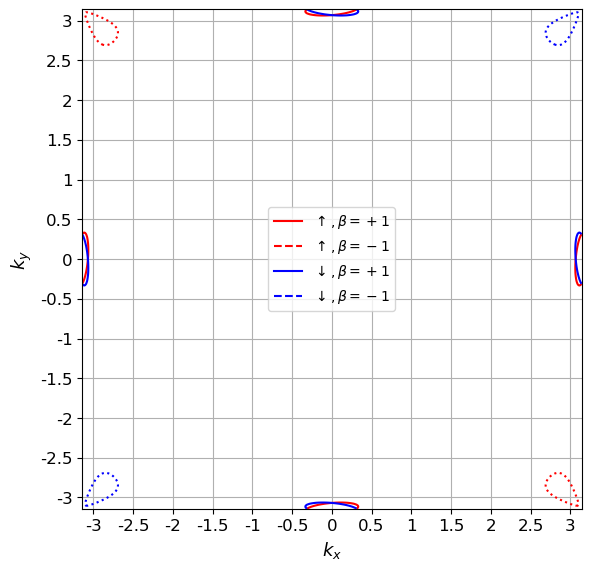

In [275]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

# === Your energy function should already be defined like this ===
# def energy_split(KX, KY, delta_up, delta_down, t, mu, epsilon):
#     ... return E_up_plus, E_up_minus, E_down_plus, E_down_minus

# === Function to compute area from contour lines ===
def compute_area_from_contour(contour_set):
    total_area = 0.0
    for path in contour_set.get_paths():
        verts = path.vertices
        x, y = verts[:, 0], verts[:, 1]
        # Shoelace formula for polygon area
        area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
        total_area += area
    return total_area


# === Grid and constants ===
plt.figure(figsize=(6, 6))
n_k2 = 500
kx = np.linspace(-np.pi, np.pi, n_k2)
ky = np.linspace(-np.pi, np.pi, n_k2)
KX, KY = np.meshgrid(kx, ky)



# === Unstrained Case ===
E_up_plus, E_up_minus, E_down_plus, E_down_minus = energy_split(KX, KY, N_A_current, N_B_current, U,  mu_current, eps)

cont1 = plt.contour(KX, KY, E_up_plus, levels=[0], colors='red', linewidths=1.5)
cont2 = plt.contour(KX, KY, E_up_minus, levels=[0], colors='red', linestyles='dotted', linewidths=1.5)
cont3 = plt.contour(KX, KY, E_down_plus, levels=[0], colors='blue', linewidths=1.5)
cont4 = plt.contour(KX, KY, E_down_minus, levels=[0], colors='blue', linestyles='dotted', linewidths=1.5)

# Compute areas
area_up_unstrained = compute_area_from_contour(cont1) + compute_area_from_contour(cont2)
area_down_unstrained = compute_area_from_contour(cont3) + compute_area_from_contour(cont4)
magnetization_unstrained = area_up_unstrained - area_down_unstrained

# === Strained Case ===
#E_up_plus_s, E_up_minus_s, E_down_plus_s, E_down_minus_s = energy_split(KX, KY,  0.206, -0.155, 1, 0.107887, epsilo)

#cont5 = plt.contour(KX, KY, E_up_plus_s, levels=[0], colors='orange', linestyles='dashed', linewidths=1.5)
#cont6 = plt.contour(KX, KY, E_up_minus_s, levels=[0], colors='orange', linestyles='dashdot', linewidths=1.5)
#cont7 = plt.contour(KX, KY, E_down_plus_s, levels=[0], colors='green', linestyles='dashed', linewidths=1.5)
#cont8 = plt.contour(KX, KY, E_down_minus_s, levels=[0], colors='green', linestyles='dashdot', linewidths=1.5)

# Compute areas
#area_up_strained = compute_area_from_contour(cont5) + compute_area_from_contour(cont6)
#area_down_strained = compute_area_from_contour(cont7) + compute_area_from_contour(cont8)
#magnetization_strained = area_up_strained - area_down_strained

# === Display results ===
print("=== Magnetization Summary ===")
print(f"Unstrained:   Area Up = {area_up_unstrained:.4f}, Area Down = {area_down_unstrained:.4f}, ΔArea = {magnetization_unstrained:.4f}")
#print(f"Strained:     Area Up = {area_up_strained:.4f}, Area Down = {area_down_strained:.4f}, ΔArea = {magnetization_strained:.4f}")

# === Plot labels, grid, etc. ===
tick_positions = [-3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]
tick_labels = tick_positions
plt.xticks(tick_positions, tick_labels, fontsize=12)
plt.yticks(tick_positions, tick_labels, fontsize=12)

#plt.title(f"$E_F = 0$, $\epsilon={epsilo}$, $M_s={magnetization_strained:.4f}$  ")
plt.xlabel("$k_x$",fontsize=13)
plt.ylabel("$k_y$",fontsize=13)
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

# === Legend ===
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', label=r'$\uparrow, \beta=+1$'),
    Line2D([0], [0], color='red', linestyle='dashed', label=r'$\uparrow, \beta=-1$'),
    Line2D([0], [0], color='blue', label=r'$\downarrow, \beta=+1$'),
    Line2D([0], [0], color='blue', linestyle='dashed', label=r'$\downarrow, \beta=-1$')
]
plt.legend(handles=legend_elements, loc='center', fontsize=10)

plt.tight_layout()
plt.savefig('fermi surface unstrained,strained.png')
plt.show()


In [226]:
#k grid
n_k = 150
kx = np.linspace(-np.pi, np.pi, n_k)
ky = np.linspace(-np.pi, np.pi, n_k)
KX, KY = np.meshgrid(kx, ky)

# Initial values
eps=0.05
x = 0

U = 3
N_A_current = 0.4
N_B_current = -0.4

#starting mu
n_0=0.985
N_0=0
U_0=1


try:
    mu_0 = brentq(density_difference_total, -10, 10, args=(N_0,-N_0 ,U_0, n_0, T,eps), xtol=1e-5)
except ValueError:
    print("mu not found")

print(mu_0)
mu_current = mu_0



for i in range(1000):
    # Compute updated order parameters
    N_A_new = x * N_A_current + (1 - x) * order_param(N_A_current, N_B_current, U, mu_current, T,eps)
    N_B_new = x * N_B_current + (1 - x) * order_param2(N_A_current, N_B_current, U, mu_current, T,eps)

    # Update mu to maintain total density ~1
    try:
        mu_new = brentq(density_difference_total, -10, 10, args=(N_A_new, N_B_new, U, n_0, T,eps), xtol=1e-5)
    except ValueError:
        print("mu not found")
        break

    # Check total density
    n_new_A = n_e(N_A_new, N_B_new, U, mu_new, T, eps)
    n_new_B = n_e2(N_A_new, N_B_new, U, mu_new, T, eps)
    n_total = (n_new_A + n_new_B) / 2

    #print(f"step {i+1}: N_A = {N_A_new:.3f}, N_B = {N_B_new:.3f}, μ = {mu_new:.3f}, n = {n_total:.3f}")

    # Check convergence
    if (np.abs(N_A_new - N_A_current) +
        np.abs(N_B_new - N_B_current) +
        np.abs(n_total - n_0)) < 1e-5:
        print(f"✅ Converged in {i+1} steps.")
        break

    # Update for next step
    N_A_current = N_A_new
    N_B_current = N_B_new
    mu_current = mu_new


print("\n📌 Final self-consistent results:")
print(f"N_A = {N_A_current:.6f}")
print(f"N_B = {N_B_current:.6f}")
print(f"μ   = {mu_current:.6f}")
print(f"n   = {(n_e(N_A_current, N_B_current, U, mu_current, T,eps) + n_e2(N_A_current, N_B_current, U, mu_current, T,eps)) / 2:.6f}")
print(f"N_A + N_B = {N_A_current + N_B_current:.6e}")

0.10590375991991548
✅ Converged in 12 steps.

📌 Final self-consistent results:
N_A = 0.861571
N_B = -0.831570
μ   = -0.945686
n   = 0.985003
N_A + N_B = 3.000109e-02


=== Magnetization Summary ===
Unstrained:   Area Up = 5.9390, Area Down = 5.9390, ΔArea = 0.0000
Strained:     Area Up = 16.7523, Area Down = 22.9929, ΔArea = -6.2406


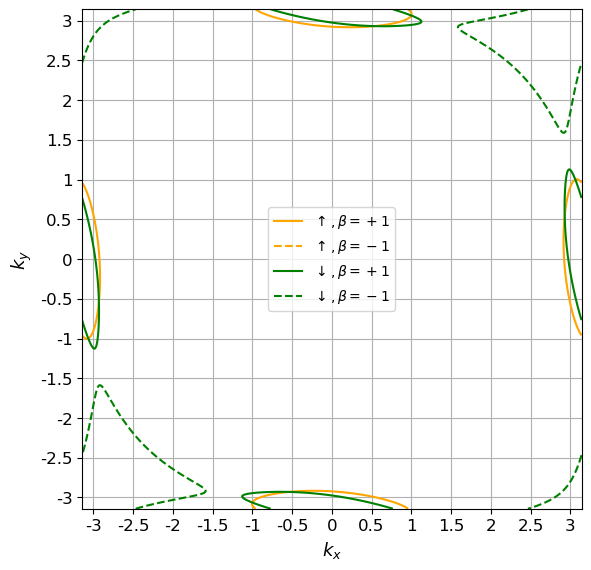

In [278]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

# === Your energy function should already be defined like this ===
# def energy_split(KX, KY, delta_up, delta_down, t, mu, epsilon):
#     ... return E_up_plus, E_up_minus, E_down_plus, E_down_minus

# === Function to compute area from contour lines ===
def compute_area_from_contour(contour_set):
    total_area = 0.0
    for path in contour_set.get_paths():
        verts = path.vertices
        x, y = verts[:, 0], verts[:, 1]
        # Shoelace formula for polygon area
        area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
        total_area += area
    return total_area


# === Grid and constants ===
plt.figure(figsize=(6, 6))
n_k2 = 500
kx = np.linspace(-np.pi, np.pi, n_k2)
ky = np.linspace(-np.pi, np.pi, n_k2)
KX, KY = np.meshgrid(kx, ky)



# === Unstrained Case ===
E_up_plus, E_up_minus, E_down_plus, E_down_minus = energy_split(KX, KY, 0.416, -0.416, 1,  mu, 0)

#cont1 = plt.contour(KX, KY, E_up_plus, levels=[0], colors='red', linewidths=1.5)
#cont2 = plt.contour(KX, KY, E_up_minus, levels=[0], colors='red', linestyles='dashed', linewidths=1.5)
#cont3 = plt.contour(KX, KY, E_down_plus, levels=[0], colors='blue', linewidths=1.5)
#cont4 = plt.contour(KX, KY, E_down_minus, levels=[0], colors='blue', linestyles='dashed', linewidths=1.5)

# Compute areas
area_up_unstrained = compute_area_from_contour(cont1) + compute_area_from_contour(cont2)
area_down_unstrained = compute_area_from_contour(cont3) + compute_area_from_contour(cont4)
magnetization_unstrained = area_up_unstrained - area_down_unstrained

# === Strained Case ===
E_up_plus_s, E_up_minus_s, E_down_plus_s, E_down_minus_s = energy_split(KX, KY, N_A_current, N_B_current, U, mu_current, eps)

cont5 = plt.contour(KX, KY, E_up_plus_s, levels=[0], colors='orange', linewidths=1.5)
cont6 = plt.contour(KX, KY, E_up_minus_s, levels=[0], colors='orange', linestyles='dashed', linewidths=1.5)
cont7 = plt.contour(KX, KY, E_down_plus_s, levels=[0], colors='green', linewidths=1.5)
cont8 = plt.contour(KX, KY, E_down_minus_s, levels=[0], colors='green', linestyles='dashed', linewidths=1.5)

# Compute areas
area_up_strained = compute_area_from_contour(cont5) + compute_area_from_contour(cont6)
area_down_strained = compute_area_from_contour(cont7) + compute_area_from_contour(cont8)
magnetization_strained = area_up_strained - area_down_strained

# === Display results ===
print("=== Magnetization Summary ===")
print(f"Unstrained:   Area Up = {area_up_unstrained:.4f}, Area Down = {area_down_unstrained:.4f}, ΔArea = {magnetization_unstrained:.4f}")
print(f"Strained:     Area Up = {area_up_strained:.4f}, Area Down = {area_down_strained:.4f}, ΔArea = {magnetization_strained:.4f}")

# === Plot labels, grid, etc. ===
tick_positions = [-3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]
tick_labels = tick_positions
plt.xticks(tick_positions, tick_labels, fontsize=12)
plt.yticks(tick_positions, tick_labels, fontsize=12)

#plt.title(f"$E_F = 0$, $\epsilon={epsilo}$, $M_s={magnetization_strained:.4f}$  ")
plt.xlabel("$k_x$",fontsize=13)
plt.ylabel("$k_y$",fontsize=13)
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

# === Legend ===
from matplotlib.lines import Line2D
legend_elements = [
    #Line2D([0], [0], color='red', linestyle='solid', label=r'$\uparrow$ unstrained'),
    #Line2D([0], [0], color='blue', linestyle='solid', label=r'$\downarrow$ unstrained'),
    Line2D([0], [0], color='orange', label=r'$\uparrow, \beta=+1$'),
    Line2D([0], [0], color='orange', linestyle='dashed', label=r'$\uparrow, \beta=-1$'),
    Line2D([0], [0], color='green', label=r'$\downarrow, \beta=+1$'),
    Line2D([0], [0], color='green', linestyle='dashed', label=r'$\downarrow, \beta=-1$')
]
plt.legend(handles=legend_elements, loc='center', fontsize=10)

plt.tight_layout()
plt.savefig('fermi surface unstrained,strained.png')
plt.show()


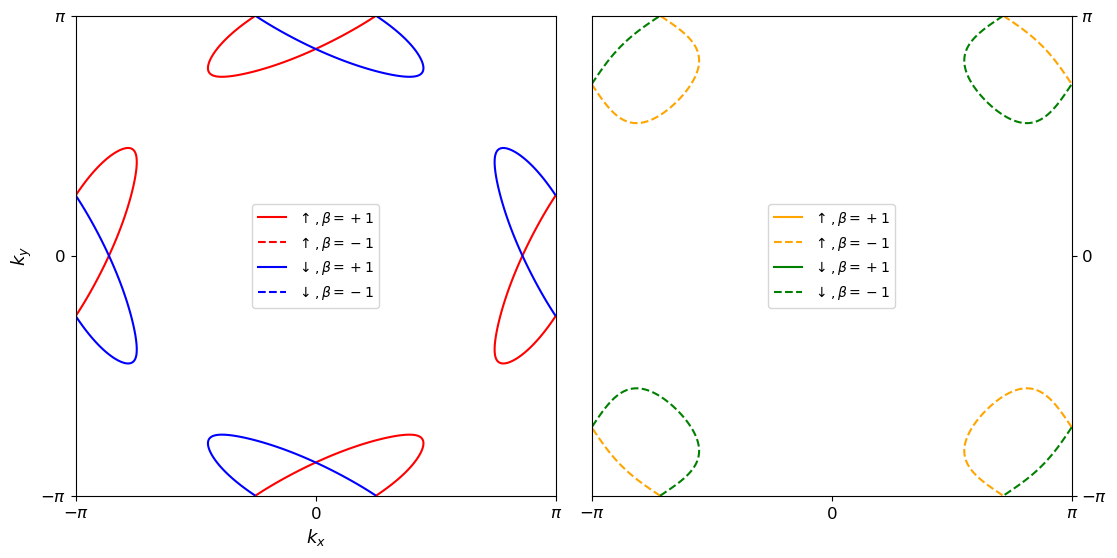

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

#with strain
#N_A = 0.831680
#N_B = -0.861704
#mu  = 1.156991
#N_A2 = 0.861549
#N_B2 = -0.831546
#mu_2 = -0.945651


#without strain at n=0.9 and n=1.1
N_A = 0.739204
N_B = -0.739204
mu   = 1.067960
N_A2 = 0.736592
N_B2 = -0.736592
mu_2   = -0.879926

U = 3



fig= plt.figure( figsize=(12, 6))

# === Grid and constants ===
n_k2 = 500
kx = np.linspace(-np.pi, np.pi, n_k2)
ky = np.linspace(-np.pi, np.pi, n_k2)
KX, KY = np.meshgrid(kx, ky)

ax1=fig.add_axes([0.05,0.1,0.45,0.8])

E_up_plus, E_up_minus, E_down_plus, E_down_minus = energy_split(KX, KY, N_A, N_B, U,  mu, 0)

cont1 = ax1.contour(KX, KY, E_up_plus, levels=[0], colors='red', linewidths=1.5)
cont2 = ax1.contour(KX, KY, E_up_minus, levels=[0], colors='red', linestyles='dotted', linewidths=1.5)
cont3 = ax1.contour(KX, KY, E_down_plus, levels=[0], colors='blue', linewidths=1.5)
cont4 = ax1.contour(KX, KY, E_down_minus, levels=[0], colors='blue', linestyles='dotted', linewidths=1.5)

ax1.set_xlabel("$k_x$",fontsize=13)
ax1.set_ylabel("$k_y$",fontsize=13)

ax1.set_aspect('equal', adjustable='box')

tick_positions = [-np.pi,0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
ax1.set_xticks(tick_positions, tick_labels, fontsize=12)
ax1.set_yticks(tick_positions, tick_labels, fontsize=12)

# === Legend ===
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', label=r'$\uparrow, \beta=+1$'),
    Line2D([0], [0], color='red', linestyle='dashed', label=r'$\uparrow, \beta=-1$'),
    Line2D([0], [0], color='blue', label=r'$\downarrow, \beta=+1$'),
    Line2D([0], [0], color='blue', linestyle='dashed', label=r'$\downarrow, \beta=-1$')
]
ax1.legend(handles=legend_elements, loc='center', fontsize=10)



# === Strained Case ===
ax2=fig.add_axes([0.48,0.1,0.45,0.8])

E_up_plus_s, E_up_minus_s, E_down_plus_s, E_down_minus_s = energy_split(KX, KY, N_A2, N_B2, U, mu_2, 0)

cont5 = ax2.contour(KX, KY, E_up_plus_s, levels=[0], colors='orange', linewidths=1.5)
cont6 = ax2.contour(KX, KY, E_up_minus_s, levels=[0], colors='orange', linestyles='dashed', linewidths=1.5)
cont7 = ax2.contour(KX, KY, E_down_plus_s, levels=[0], colors='green', linewidths=1.5)
cont8 = ax2.contour(KX, KY, E_down_minus_s, levels=[0], colors='green', linestyles='dashed', linewidths=1.5)


# === Plot labels, grid, etc. ===
tick_positions = [-np.pi,0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
ax2.set_xticks(tick_positions, tick_labels, fontsize=12)
ax2.set_yticks(tick_positions, tick_labels, fontsize=12)
ax2.yaxis.tick_right()


#plt.title(f"$E_F = 0$, $\epsilon={epsilo}$, $M_s={magnetization_strained:.4f}$  ")
#ax2.set_xlabel("$k_x$",fontsize=13)
#ax2.set_ylabel("$k_y$",fontsize=13)



# === Legend ===
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='orange', label=r'$\uparrow, \beta=+1$'),
    Line2D([0], [0], color='orange', linestyle='dashed', label=r'$\uparrow, \beta=-1$'),
    Line2D([0], [0], color='green', label=r'$\downarrow, \beta=+1$'),
    Line2D([0], [0], color='green', linestyle='dashed', label=r'$\downarrow, \beta=-1$')
]
ax2.legend(handles=legend_elements, loc='center', fontsize=10)
ax2.set_aspect('equal', adjustable='box')


plt.savefig('fermi surface electron hole doping U=3 .png', bbox_inches='tight', pad_inches=0.1)
plt.show()


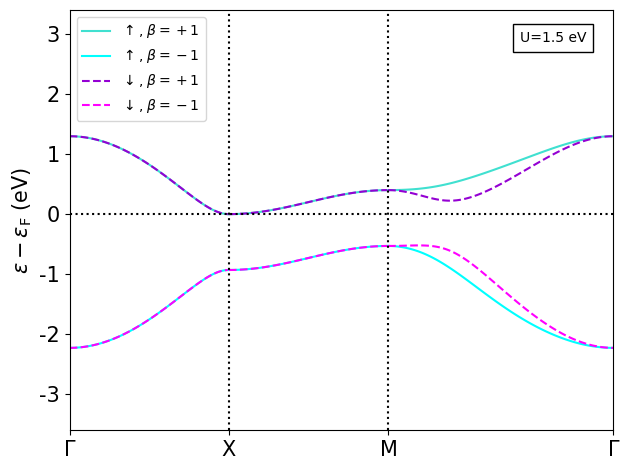

In [108]:
# High-symmetry points: Γ → X → M → Γ
G = np.array([0, 0])
X = np.array([np.pi, 0])
M = np.array([np.pi, np.pi])
path = [G, X, M, G]
labels = [r'$\Gamma$', r'$\text{X}$', r'$\text{M}$', r'$\Gamma$']
points_per_segment = 200


#U=1.5
N_A = 0.620242
N_B = -0.620242
mu  = 0.364980

#U=3
#N_A = 0.866006
#N_B = -0.866006
#mu  = 1.198803

epsilo= 0 

k1=np.linspace(0,np.pi,100)
k0=np.full_like(k1,0) 
k2=np.full_like(k1,np.pi)
k3=np.linspace(np.pi,0,100)


E1=energy_split(k1, k0, N_A, N_B, U, mu, epsilo)
E2=energy_split(k2, k1, N_A, N_B, U, mu, epsilo)
E3=energy_split(k3, k3, N_A, N_B, U, mu, epsilo)


#plotting all bands for each path between high symmetry points
fig, ax = plt.subplots()

plt.plot(np.linspace(0,1,100), E1[0], label=r'$\uparrow$, $\beta=+1$', color='turquoise')
plt.plot(np.linspace(0,1,100), E1[1], label=r'$\uparrow$, $\beta=-1$ ', color='cyan')
plt.plot(np.linspace(0,1,100), E1[2], '--',color='darkviolet')
plt.plot(np.linspace(0,1,100), E1[3],'--', color='magenta')

plt.plot(np.linspace(1,2,100), E2[0], color='turquoise')
plt.plot(np.linspace(1,2,100), E2[1], color='cyan')
plt.plot(np.linspace(1,2,100), E2[2], '--',color='darkviolet')
plt.plot(np.linspace(1,2,100), E2[3],'--',  color='magenta')

plt.plot(np.linspace(2,2+np.sqrt(2),100), E3[0], color='turquoise')
plt.plot(np.linspace(2,2+np.sqrt(2),100), E3[1], color='cyan')
plt.plot(np.linspace(2,2+np.sqrt(2),100), E3[2], '--',label=r'$\downarrow$, $\beta=+1$', color='darkviolet')
plt.plot(np.linspace(2,2+np.sqrt(2),100), E3[3],'--', label=r'$\downarrow$, $\beta=-1$', color='magenta')




# Set custom x-axis ticks and labels
tick_positions = [0,1,2,2+np.sqrt(2)]
tick_labels = labels
plt.xticks(tick_positions, tick_labels, fontsize=15)

y_tick_positions=[-3,-2,-1,0,1,2,3]
y_tick_labels=[-3,-2,-1,0,1,2,3]
plt.yticks(y_tick_positions,y_tick_labels, fontsize=15)



# Dotted vertical line at x = 2
ax.axvline(x=1, linestyle=':', linewidth=1.5,color='black')
ax.axvline(x=2, linestyle=':', linewidth=1.5,color='black')

# Dotted horizontal line at y = 3
ax.axhline(y=0, linestyle=':', linewidth=1.5,color='black')


ax.text(
    0.95, 0.95,                    # x, y position in axes coordinates (0–1)
    'U=1.5 eV',              # text content
    transform=ax.transAxes,        # interpret x,y as relative to the axes
    ha='right', va='top',          # align text to the top-right
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',         # border color
        boxstyle='square,pad=0.5'   # rounded box (optional)
    )
)

#plt.xlabel("k-path")
plt.ylabel(r"$\epsilon-\epsilon_\text{F}\text{ }(\text{eV})$",fontsize=15)
#plt.title(f"Band Dispersion along High-Symmetry Path for $\epsilon$={epsilo}")
plt.xlim(0,2+np.sqrt(2))
plt.ylim(-3.6,3.4)
#plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('dispersion along path electron 1.1 hole 0.9 doping U=3.png', bbox_inches='tight', pad_inches=0.1)
plt.show()


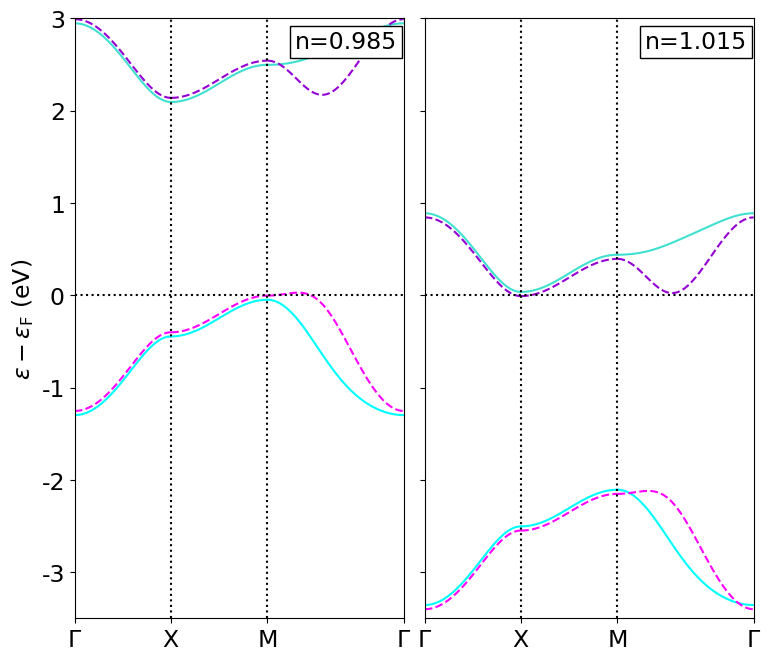

In [229]:
fig= plt.figure( figsize=(7, 6))


ax1 = fig.add_axes([0, 0, 0.47, 1])
ax2 = fig.add_axes([0.5, 0, 0.47, 1])

G = np.array([0, 0])
X = np.array([np.pi, 0])
M = np.array([np.pi, np.pi])
path = [G, X, M, G]
labels = [r'$\Gamma$', r'$\text{X}$', r'$\text{M}$', r'$\Gamma$']
points_per_segment = 200


#U=1.5
#N_A = 0.620242
#N_B = -0.620242
#mu  = 0.364980

#U2=3
#N_A2 = 0.866006
#N_B2 = -0.866006
#mu2  = 1.198803

#strain and doping
#n=0.985
U=3
N_A = 0.861571
N_B = -0.831570
mu  = -0.945686

#n=1.015
U2=3
N_A2 = 0.831679
N_B2 = -0.861695
mu2  = 1.156989

epsilo= 0.05 

k1=np.linspace(0,np.pi,100)
k0=np.full_like(k1,0) 
k2=np.full_like(k1,np.pi)
k3=np.linspace(np.pi,0,100)


E1=energy_split(k1, k0, N_A, N_B, U, mu, epsilo)
E2=energy_split(k2, k1, N_A, N_B, U, mu, epsilo)
E3=energy_split(k3, k3, N_A, N_B, U, mu, epsilo)


#plotting all bands for each path between high symmetry points
ax1.plot(np.linspace(0,1,100), E1[0], label=r'$\uparrow$, $\beta=+1$', color='turquoise')
ax1.plot(np.linspace(0,1,100), E1[1], label=r'$\uparrow$, $\beta=-1$ ', color='cyan')
ax1.plot(np.linspace(0,1,100), E1[2], '--',color='darkviolet')
ax1.plot(np.linspace(0,1,100), E1[3],'--', color='magenta')

ax1.plot(np.linspace(1,2,100), E2[0], color='turquoise')
ax1.plot(np.linspace(1,2,100), E2[1], color='cyan')
ax1.plot(np.linspace(1,2,100), E2[2], '--',color='darkviolet')
ax1.plot(np.linspace(1,2,100), E2[3],'--',  color='magenta')

ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[0], color='turquoise')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[1], color='cyan')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[2], '--',label=r'$\downarrow$, $\beta=+1$', color='darkviolet')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[3],'--', label=r'$\downarrow$, $\beta=-1$', color='magenta')




# Set custom x-axis ticks and labels
tick_positions = [0,1,2,2+np.sqrt(2)]
tick_labels = labels
ax1.set_xticks(tick_positions, tick_labels, fontsize=17)

y_tick_positions=[-3,-2,-1,0,1,2,3]
y_tick_labels=[-3,-2,-1,0,1,2,3]
ax1.set_yticks(y_tick_positions,y_tick_labels, fontsize=17)



# Dotted vertical line at x = 2
ax1.axvline(x=1, linestyle=':', linewidth=1.5,color='black')
ax1.axvline(x=2, linestyle=':', linewidth=1.5,color='black')

# Dotted horizontal line at y = 3
ax1.axhline(y=0, linestyle=':', linewidth=1.5,color='black')


ax1.text(
    0.98, 0.98,                    # x, y position in axes coordinates (0–1)
    'n=0.985',              # text content
    transform=ax1.transAxes,        # interpret x,y as relative to the axes
    ha='right', va='top',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',         # border color
        linewidth=1,
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)

#plt.xlabel("k-path")
ax1.set_ylabel(r"$\epsilon-\epsilon_\text{F}\text{ }(\text{eV})$",fontsize=17)
#plt.title(f"Band Dispersion along High-Symmetry Path for $\epsilon$={epsilo}")
ax1.set_xlim(0,2+np.sqrt(2))
ax1.set_ylim(-3.5,3)
#plt.grid(True)
#ax1.legend(loc='upper left')



E12=energy_split(k1, k0, N_A2, N_B2, U2, mu2, epsilo)
E22=energy_split(k2, k1, N_A2, N_B2, U2, mu2, epsilo)
E32=energy_split(k3, k3, N_A2, N_B2, U2, mu2, epsilo)


#plotting all bands for each path between high symmetry points
ax2.plot(np.linspace(0,1,100), E12[0], label=r'$\uparrow$, $\beta=+1$', color='turquoise')
ax2.plot(np.linspace(0,1,100), E12[1], label=r'$\uparrow$, $\beta=-1$ ', color='cyan')
ax2.plot(np.linspace(0,1,100), E12[2], '--',color='darkviolet')
ax2.plot(np.linspace(0,1,100), E12[3],'--', color='magenta')

ax2.plot(np.linspace(1,2,100), E22[0], color='turquoise')
ax2.plot(np.linspace(1,2,100), E22[1], color='cyan')
ax2.plot(np.linspace(1,2,100), E22[2], '--',color='darkviolet')
ax2.plot(np.linspace(1,2,100), E22[3],'--',  color='magenta')

ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[0], color='turquoise')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[1], color='cyan')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[2], '--',label=r'$\downarrow$, $\beta=+1$', color='darkviolet')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[3],'--', label=r'$\downarrow$, $\beta=-1$', color='magenta')




# Set custom x-axis ticks and labels
tick_positions = [0,1,2,2+np.sqrt(2)]
tick_labels = labels
ax2.set_xticks(tick_positions, tick_labels, fontsize=17)

y_tick_positions=[-3,-2,-1,0,1,2,3]
y_tick_labels=[]
ax2.set_yticks(y_tick_positions,y_tick_labels, fontsize=15)



# Dotted vertical line at x = 2
ax2.axvline(x=1, linestyle=':', linewidth=1.5,color='black')
ax2.axvline(x=2, linestyle=':', linewidth=1.5,color='black')

# Dotted horizontal line at y = 3
ax2.axhline(y=0, linestyle=':', linewidth=1.5,color='black')


ax2.text(
    0.98, 0.98,                    # x, y position in axes coordinates (0–1)
    'n=1.015',              # text content
    transform=ax2.transAxes,        # interpret x,y as relative to the axes
    ha='right', va='top',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',
        linewidth=1,         # border color
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)

#plt.xlabel("k-path")
#ax2.set_ylabel(r"$\epsilon-\epsilon_\text{F}\text{ }(\text{eV})$",fontsize=15)
#plt.title(f"Band Dispersion along High-Symmetry Path for $\epsilon$={epsilo}")
ax2.set_xlim(0,2+np.sqrt(2))
ax2.set_ylim(-3.5,3)
#plt.grid(True)
#ax2.legend(loc='upper left')






#plt.tight_layout()
plt.savefig('dispersion along path half filling U=1.5, U=3.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()



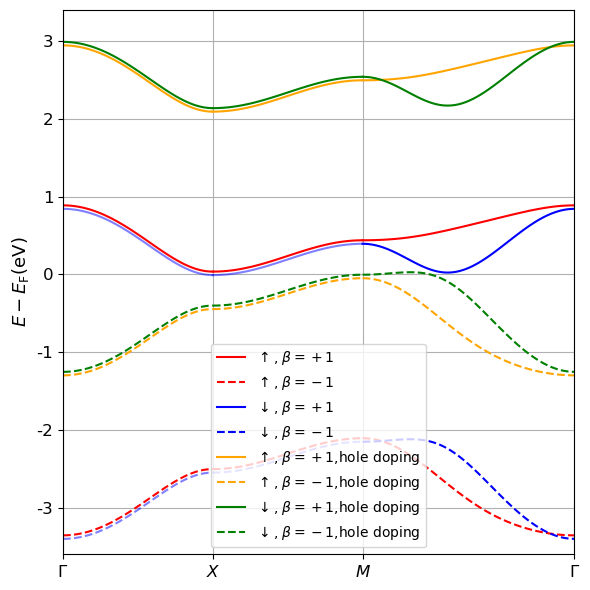

In [63]:
# High-symmetry points: Γ → X → M → Γ
G = np.array([0, 0])
X = np.array([np.pi, 0])
M = np.array([np.pi, np.pi])
path = [G, X, M, G]
labels = [r'$\Gamma$', r'$X$', r'$M$', r'$\Gamma$']
points_per_segment = 200

#N_A = 0.831680
#N_B = -0.861704
#mu  = 1.156991
#N_A2 = 0.861549
#N_B2 = -0.831546
#mu_2 = -0.945651
#U = 3
#n=1.015
#epsilo=0.05

#N_A = 0.739204
#N_B = -0.739204
#mu   = 1.067960
#N_A2 = 0.736592
#N_B2 = -0.736592
#mu_2   = -0.879926


epsilo= 0 

k1=np.linspace(0,np.pi,100)
k0=np.full_like(k1,0) 
k2=np.full_like(k1,np.pi)
k3=np.linspace(np.pi,0,100)


E1=energy_split(k1, k0, N_A, N_B, U, mu, epsilo)
E2=energy_split(k2, k1, N_A, N_B, U, mu, epsilo)
E3=energy_split(k3, k3, N_A, N_B, U, mu, epsilo)


#plotting all bands for each path between high symmetry points
plt.figure(figsize=(6, 6))

plt.plot(np.linspace(0,1,100), E1[0], label=r'$\uparrow$, $\beta=+1$', color='red')
plt.plot(np.linspace(0,1,100), E1[1], '--', label=r'$\uparrow$, $\beta=-1$ ', color='red')
plt.plot(np.linspace(0,1,100), E1[2], color='blue',alpha=0.5)
plt.plot(np.linspace(0,1,100), E1[3],'--', color='blue',alpha=0.5)

plt.plot(np.linspace(1,2,100), E2[0], color='red')
plt.plot(np.linspace(1,2,100), E2[1], '--', color='red')
plt.plot(np.linspace(1,2,100), E2[2], color='blue',alpha=0.5)
plt.plot(np.linspace(1,2,100), E2[3],'--',  color='blue',alpha=0.5)

plt.plot(np.linspace(2,2+np.sqrt(2),100), E3[0], color='red')
plt.plot(np.linspace(2,2+np.sqrt(2),100), E3[1], '--', color='red')
plt.plot(np.linspace(2,2+np.sqrt(2),100), E3[2], label=r'$\downarrow$, $\beta=+1$', color='blue')
plt.plot(np.linspace(2,2+np.sqrt(2),100), E3[3],'--', label=r'$\downarrow$, $\beta=-1$', color='blue')




# Band structure calculation
E12=energy_split(k1, k0, N_A2, N_B2, U, mu_2, epsilo)
E22=energy_split(k2, k1, N_A2, N_B2, U, mu_2, epsilo)
E32=energy_split(k3, k3, N_A2, N_B2, U, mu_2, epsilo)


#plotting all bands for each path between high symmetry points

plt.plot(np.linspace(0,1,100), E12[0], label=r'$\uparrow$, $\beta=+1$,hole doping', color='orange')
plt.plot(np.linspace(0,1,100), E12[1], '--', label=r'$\uparrow$, $\beta=-1$,hole doping', color='orange')
plt.plot(np.linspace(0,1,100), E12[2],label=r'$\downarrow$, $\beta=+1$,hole doping', color='green')
plt.plot(np.linspace(0,1,100), E12[3],'--', label=r'$\downarrow$, $\beta=-1$,hole doping', color='green')

plt.plot(np.linspace(1,2,100), E22[0], color='orange')
plt.plot(np.linspace(1,2,100), E22[1], '--' ,color='orange')
plt.plot(np.linspace(1,2,100), E22[2], color='green')
plt.plot(np.linspace(1,2,100), E22[3],'--',  color='green')

plt.plot(np.linspace(2,2+np.sqrt(2),100), E32[0], color='orange')
plt.plot(np.linspace(2,2+np.sqrt(2),100), E32[1], '--', color='orange')
plt.plot(np.linspace(2,2+np.sqrt(2),100), E32[2], color='green')
plt.plot(np.linspace(2,2+np.sqrt(2),100), E32[3],'--', color='green')

# Set custom x-axis ticks and labels
tick_positions = [0,1,2,2+np.sqrt(2)]
tick_labels = labels
plt.xticks(tick_positions, tick_labels, fontsize=12)

y_tick_positions=[-3,-2,-1,0,1,2,3]
y_tick_labels=[-3,-2,-1,0,1,2,3]
plt.yticks(y_tick_positions,y_tick_labels, fontsize=12)



#plt.xlabel("k-path")
plt.ylabel(r"$E-E_\text{F}(\text{eV})$",fontsize=13)
#plt.title(f"Band Dispersion along High-Symmetry Path for $\epsilon$={epsilo}")
plt.xlim(0,2+np.sqrt(2))
plt.ylim(-3.6,3.4)
plt.grid(True)
plt.legend(loc='lower center')
plt.tight_layout()
plt.savefig('dispersion along path electron 1.1 hole 0.9 doping U=3.png', bbox_inches='tight', pad_inches=0.1)
plt.show()


# N_A + N_B check

In [125]:
#check via reduced form
def aplusb(N,U,mu,T):
    E_up_plus,E_up_minus,E_down_plus,E_down_minus = energy_split(KX, KY, N, U, mu)
    f_up_plus = fermi(E_up_plus, mu, T)
    f_up_minus = fermi(E_up_minus, mu, T)
    f_down_plus = fermi(E_down_plus, mu, T)
    f_down_minus = fermi(E_down_minus, mu, T)
    return 1/n_k**2*np.sum(f_up_plus+f_up_minus-(f_down_plus+f_down_minus))

aplusb(0.424,1,0.047,0.1)

0.0

In [126]:
#check via order parameter function
print(order_param(0.2,1,0.3,0.1)+order_param2(0.2,1,0.3,0.1))

print(order_param(0.424,1,0.047,0.1),order_param2(0.424,1,0.047,0.1))

0.0
0.41097029562306636 -0.41097029562306636


# epsilon dependence

  epsi |     N_A |     N_B |       dN |      mu |      n
---------------------------------------------------------
converged
 0.000 |   0.847 |  -0.847 | -0.00000 |  -0.964 |  0.985
converged
 0.010 |   0.862 |  -0.832 | 0.02999 |  -0.949 |  0.985
converged
 0.020 |   0.862 |  -0.832 | 0.03001 |  -0.948 |  0.985
converged
 0.030 |   0.862 |  -0.832 | 0.03001 |  -0.948 |  0.985
converged
 0.040 |   0.862 |  -0.832 | 0.02998 |  -0.947 |  0.985
converged
 0.050 |   0.862 |  -0.832 | 0.02999 |  -0.946 |  0.985
converged
 0.060 |   0.861 |  -0.831 | 0.02999 |  -0.945 |  0.985
converged
 0.070 |   0.861 |  -0.831 | 0.03000 |  -0.943 |  0.985
converged
 0.080 |   0.861 |  -0.831 | 0.02999 |  -0.942 |  0.985
converged
 0.088 |   0.860 |  -0.830 | 0.03001 |  -0.942 |  0.985
converged
 0.090 |   0.860 |  -0.830 | 0.02999 |  -0.942 |  0.985
converged
 0.092 |   0.860 |  -0.830 | 0.02999 |  -0.941 |  0.985
converged
 0.094 |   0.860 |  -0.830 | 0.02999 |  -0.941 |  0.985
converged
 0.096 |   0.860

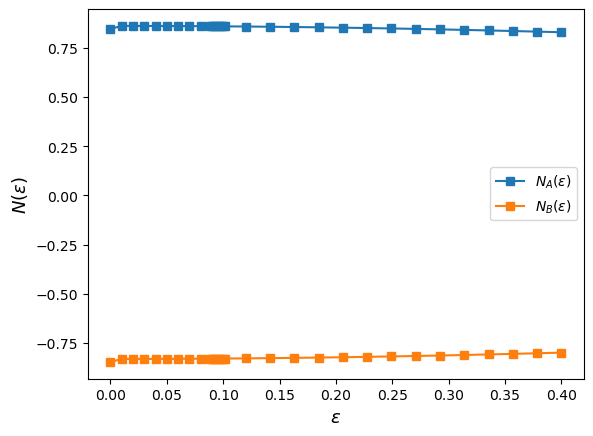

In [71]:
n_k = 150
kx = np.linspace(-np.pi, np.pi, n_k)
ky = np.linspace(-np.pi, np.pi, n_k)
KX, KY = np.meshgrid(kx, ky)


epsi_values = np.concatenate((np.linspace(0,0.08,9),np.linspace(0.088, 0.102, 8),np.linspace(0.12,0.4,14)))
U = 3
x = 0

print(f"{'epsi':>6} | {'N_A':>7} | {'N_B':>7} | {'dN':>8} | {'mu':>7} | {'n':>6}")
print("-" * 57)
N_A_list=[]
N_B_list=[]


for epsi in epsi_values:
    N_A, N_B = 0.5, -0.5

    try:
        mu_0 = brentq(density_difference, -10, 10, args=(0, 0, U, 0.985, T, epsi), xtol=1e-5)
    except ValueError:
        print(f"{epsi:6.3f} | error finding mu_0")
        continue

    mu = mu_0

    for i in range(200):
        N_A_new = x * N_A + (1 - x) * order_param(N_A, N_B, U, mu, T, epsi)
        N_B_new = x * N_B + (1 - x) * order_param2(N_A, N_B, U, mu, T, epsi)

        try:
            mu_new = brentq(density_difference_total, -10, 10, args=(N_A_new, N_B_new, U, 0.985, T, epsi), xtol=1e-5)
        except ValueError:
            print(f"{epsi:6.3f} | error finding mu")
            break

        # Check total density
        n_new_A = n_e(N_A_new, N_B_new, U, mu_new, T, epsi)
        n_new_B = n_e2(N_A_new, N_B_new, U, mu_new, T, epsi)
        n_total = (n_new_A + n_new_B) / 2

        if np.abs(N_A_new - N_A) + np.abs(N_B_new - N_B) + np.abs(n_total - 0.985) < 1e-3:
            N_A, N_B, mu = N_A_new, N_B_new, mu_new
            N_A_list.append(N_A)
            N_B_list.append(N_B)
            print('converged')
            break

        N_A, N_B, mu = N_A_new, N_B_new, mu_new

    print(f"{epsi:6.3f} | {N_A:7.3f} | {N_B:7.3f} | {N_A+N_B:7.5f} | {mu:7.3f} | {n_total:6.3f}")


plt.plot(epsi_values, N_A_list, marker='s',label=r'$N_A(\epsilon)$')
plt.plot(epsi_values, N_B_list, marker='s',label=r'$N_B(\epsilon)$')
plt.xlabel(r'$\epsilon$',fontsize=13)
plt.ylabel(r'$N(\epsilon)$',fontsize=13)
plt.legend()
#plt.xlim(0,310)
#plt.ylim(0,np.max(W_T_array)+0.005)
#plt.title(f'U_c where N ≈ 0: {U_critical:.2f} meV for T = {T}')
plt.savefig('NA,NB and epsi  hole doping 0.985 U=3.png')
plt.show()


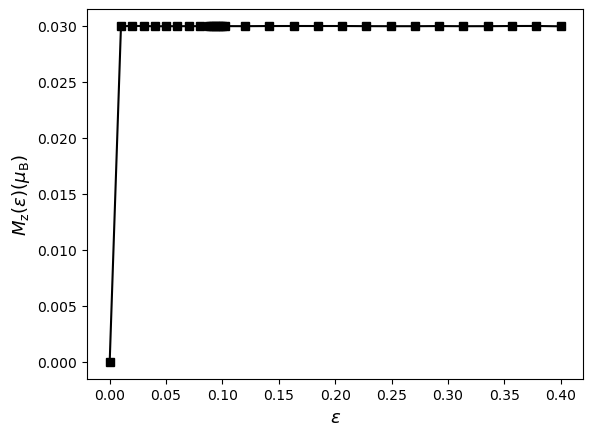

In [72]:
N_A_arr=np.array(N_A_list)
N_B_arr=np.array(N_B_list)

dN_arr=N_A_arr+N_B_arr

plt.plot(epsi_values, dN_arr, c='black',marker='s',label=r'$dN(\epsilon)$')
plt.xlabel(r'$\epsilon$',fontsize=13)
plt.ylabel(r'$M_\text{z}(\epsilon)(\mu_\text{B})$',fontsize=13)
#plt.legend()
#plt.xlim(0,310)
#plt.ylim(0,np.max(W_T_array)+0.005)
#plt.title(f'U_c where N ≈ 0: {U_critical:.2f} meV for T = {T}')
plt.savefig('M and epsi hole doping 0.985 U=3.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

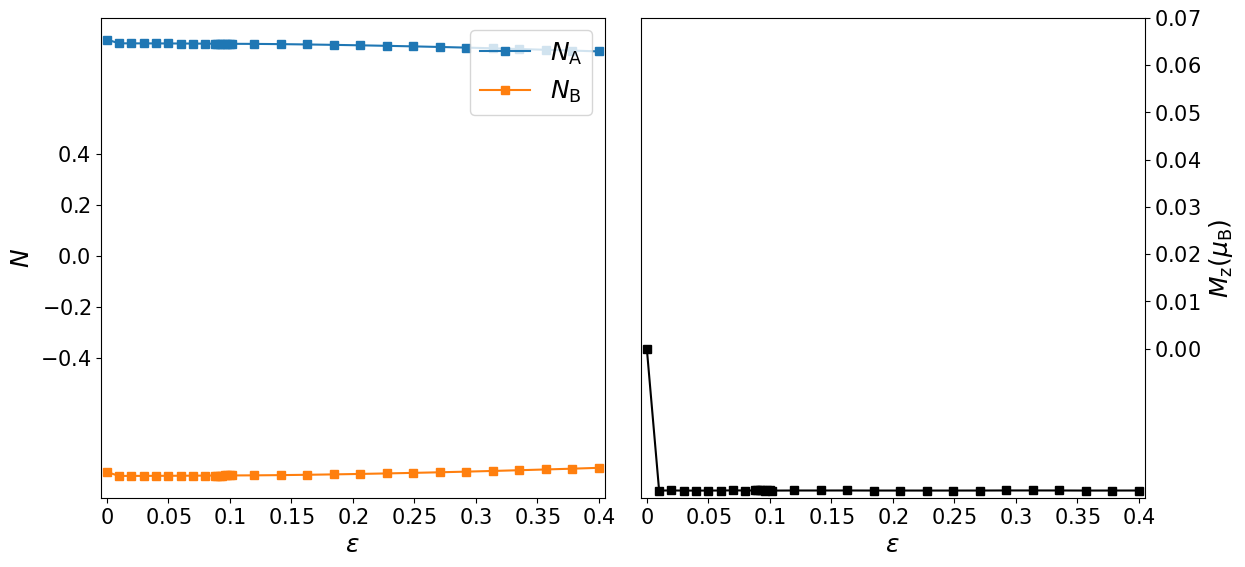

In [23]:
fig= plt.figure( figsize=(12, 6))

ax1=fig.add_axes([0.05,0.1,0.42,0.8])

ax1.plot(epsi_values, N_A_list, marker='s',label=r'$N_\text{A}$')
ax1.plot(epsi_values, N_B_list, marker='s',label=r'$N_\text{B}$')

ax1.set_xlabel(r'$\epsilon$',fontsize=18)
ax1.set_ylabel(r'$N$',fontsize=18)
ax1.legend(loc='upper right',fontsize=18)

ax1.set_xlim(-0.005,0.405)

#ax1.set_aspect('equal', adjustable='box')

xtick_positions = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4]
xtick_labels = [r'$0$', r'$0.05$', r'$0.1$',r'$0.15$', r'$0.2$', r'$0.25$',r'$0.3$', r'$0.35$', r'$0.4$']
ax1.set_xticks(xtick_positions, xtick_labels, fontsize=15)

y2tick_positions = [-0.4,-0.2,0,0.2,0.4]
y2tick_labels = [r'$-0.4$',r'$-0.2$',r'$0.0$',r'$0.2$',r'$0.4$']
ax1.set_yticks(y2tick_positions, y2tick_labels, fontsize=15)

ax2=fig.add_axes([0.5,0.1,0.42,0.8])

ax2.plot(epsi_values, dN_arr, c='black',marker='s',label=r'$M_z$')
ax2.set_xlabel(r'$\epsilon$',fontsize=18)
ax2.set_ylabel(r'$M_\text{z}(\mu_\text{B})$',fontsize=18)
ax2.yaxis.set_label_position("right")
ax2.set_xlim(-0.005,0.405)

xtick_positions = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4]
xtick_labels = [r'$0$', r'$0.05$', r'$0.1$',r'$0.15$', r'$0.2$', r'$0.25$',r'$0.3$', r'$0.35$', r'$0.4$']
ax2.set_xticks(xtick_positions, xtick_labels, fontsize=15)

ytick_positions = [0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07]
ytick_labels = [r'$0.00$',r'$0.01$',r'$0.02$',r'$0.03$',r'$0.04$',r'$0.05$',r'$0.06$',r'$0.07$']
ax2.set_yticks(ytick_positions, ytick_labels, fontsize=15)
ax2.yaxis.tick_right()

#ax2.set_aspect('equal', adjustable='box')

plt.savefig('NA,NB,Mz and epsilon.png', bbox_inches='tight', pad_inches=0.1)
plt.show()


# fermi surfaces

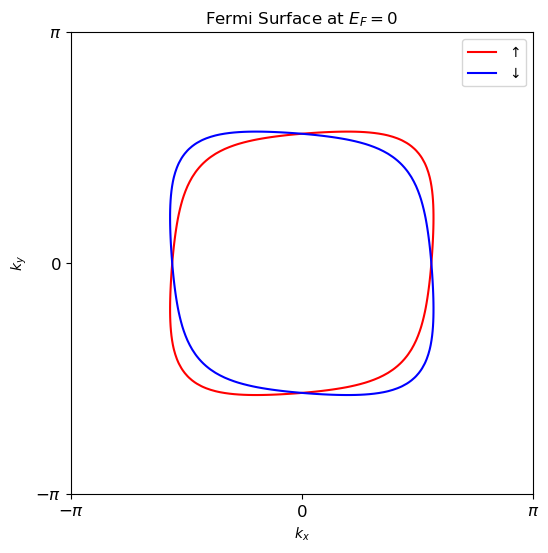

In [344]:
# Plotting
plt.figure(figsize=(6, 6))

# Colors for spin
colors = {+1: 'red', -1: 'blue'}
labels = {+1: 'Spin Up', -1: 'Spin Down'}


#energy values
E_up_plus,E_up_minus,E_down_plus,E_down_minus=energy_split(KX,KY,0.2,-0.2,2,1,0)

#contours for spin up
    
plt.contour(KX, KY, E_up_plus, levels=[0], colors='red', linewidths=1.5)
#plt.contour(KX, KY, E_up_minus, levels=[0], colors='red', linewidths=1.5)


#contours for spin down    
plt.contour(KX, KY, E_down_plus, levels=[0], colors='blue', linewidths=1.5)
#plt.contour(KX, KY, E_down_minus, levels=[0], colors='blue', linewidths=1.5)


#legend
spin_up_line1 = plt.Line2D([0], [0], color='red', linewidth=1.5, label=r'$\uparrow$')
spin_down_line1 = plt.Line2D([0], [0], color='blue', linewidth=1.5, label=r'$\downarrow$')
plt.legend(handles=[spin_up_line1, spin_down_line1], loc='upper right', fontsize=10)



tick_positions = [-np.pi,0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']

# Set custom x-axis ticks and labels
plt.xticks(tick_positions, tick_labels, fontsize=12)
plt.yticks(tick_positions, tick_labels, fontsize=12)


plt.title("Fermi Surface at $E_F = 0$")
plt.xlabel("$k_x$")
plt.ylabel("$k_y$")

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.savefig('fermi surface at mu 1.png')
plt.show()

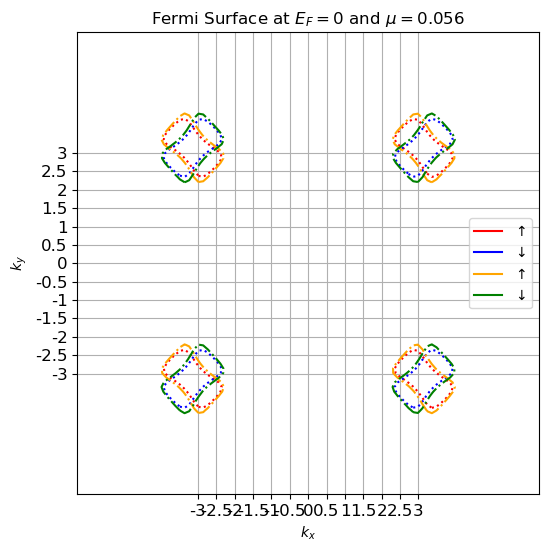

In [420]:
# Plotting
plt.figure(figsize=(6, 6))

n_k = 100
kx = np.linspace(-2*np.pi, 2*np.pi, n_k)
ky = np.linspace(-2*np.pi, 2*np.pi, n_k)
KX, KY = np.meshgrid(kx, ky)

# Colors for spin
colors = {+1: 'red', -1: 'blue'}
labels = {+1: 'Spin Up', -1: 'Spin Down'}

mu=0.056

#energy values
E_up_plus,E_up_minus,E_down_plus,E_down_minus=energy_split(KX,KY,0.424,-0.424,1,mu,0)

#contours for spin up
    
plt.contour(KX, KY, E_up_plus, levels=[0], colors='red', linewidths=1.5)
plt.contour(KX, KY, E_up_minus, levels=[0], colors='red',linestyles='dotted', linewidths=1.5)


#contours for spin down    
plt.contour(KX, KY, E_down_plus, levels=[0], colors='blue', linewidths=1.5)
plt.contour(KX, KY, E_down_minus, levels=[0], colors='blue',linestyles='dotted', linewidths=1.5)


#legend
spin_up_line1 = plt.Line2D([0], [0], color='red', linewidth=1.5, label=r'$\uparrow$')
spin_down_line1 = plt.Line2D([0], [0], color='blue', linewidth=1.5, label=r'$\downarrow$')
#plt.legend(handles=[spin_up_line1, spin_down_line1], loc='right', fontsize=10)



#tick_positions = [-np.pi,0, np.pi]
#tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
tick_positions=[-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3]
tick_labels=[-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3]

# Set custom x-axis ticks and labels
plt.xticks(tick_positions, tick_labels, fontsize=12)
plt.yticks(tick_positions, tick_labels, fontsize=12)


plt.title(f"Fermi Surface at $E_F = 0$ and $\mu={mu}$")
plt.xlabel("$k_x$")
plt.ylabel("$k_y$")
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
#plt.savefig('fermi surface at mu 1.png')




# Plotting for strain
#plt.figure(figsize=(6, 6))

# Colors for spin
colors = {+1: 'red', -1: 'blue'}
labels = {+1: 'Spin Up', -1: 'Spin Down'}

epsilo=0.2
#energy values
E_up_plus,E_up_minus,E_down_plus,E_down_minus=energy_split(KX,KY,0.389,-0.389,1,mu,epsilo)

#contours for spin up
    
plt.contour(KX, KY, E_up_plus, levels=[0], colors='orange',linestyles='dashed', linewidths=1.5)
plt.contour(KX, KY, E_up_minus, levels=[0], colors='orange',linestyles='dashdot', linewidths=1.5)


#contours for spin down    
plt.contour(KX, KY, E_down_plus, levels=[0], colors='green',linestyles='dashed', linewidths=1.5)
plt.contour(KX, KY, E_down_minus, levels=[0], colors='green',linestyles='dashdot', linewidths=1.5)


#legend
spin_up_line2 = plt.Line2D([0], [0], color='orange', linewidth=1.5, label=r'$\uparrow$')
spin_down_line2 = plt.Line2D([0], [0], color='green', linewidth=1.5, label=r'$\downarrow$')
plt.legend(handles=[spin_up_line1, spin_down_line1,spin_up_line2, spin_down_line2], loc='right', fontsize=10)



#tick_positions = [-np.pi,0, np.pi]
#tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']

tick_positions=[-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3]
tick_labels=[-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3]

# Set custom x-axis ticks and labels
#plt.xticks(tick_positions, tick_labels, fontsize=12)
#plt.yticks(tick_positions, tick_labels, fontsize=12)


#plt.title(f"Fermi Surface at $E_F = 0$ with strain $\epsilon={epsilo}$")
#plt.xlabel("$k_x$")
#plt.ylabel("$k_y$")
#plt.grid(True)
#ax = plt.gca()
#ax.set_aspect('equal', adjustable='box')
#plt.savefig('fermi surface at mu 1.png')
#plt.show()



plt.show()

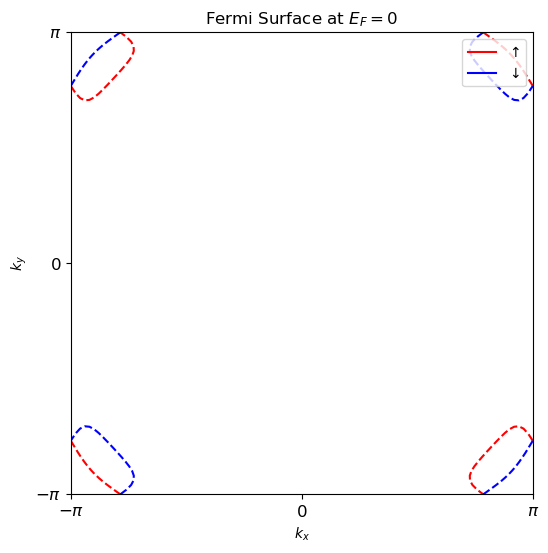

In [353]:
# Plotting
plt.figure(figsize=(6, 6))

# Colors for spin
colors = {+1: 'red', -1: 'blue'}
labels = {+1: 'Spin Up', -1: 'Spin Down'}


#energy values
E_up_plus,E_up_minus,E_down_plus,E_down_minus=energy_split(KX,KY,0.408,-0.408,1,0.048,0.15)

#contours for spin up
    
plt.contour(KX, KY, E_up_plus, levels=[0], colors='red', linewidths=1.5)
plt.contour(KX, KY, E_up_minus, levels=[0], colors='red',linestyles='dashed', linewidths=1.5)


#contours for spin down    
plt.contour(KX, KY, E_down_plus, levels=[0], colors='blue', linewidths=1.5)
plt.contour(KX, KY, E_down_minus, levels=[0], colors='blue',linestyles='dashed', linewidths=1.5)


#legend
spin_up_line1 = plt.Line2D([0], [0], color='red', linewidth=1.5, label=r'$\uparrow$')
spin_down_line1 = plt.Line2D([0], [0], color='blue', linewidth=1.5, label=r'$\downarrow$')
plt.legend(handles=[spin_up_line1, spin_down_line1], loc='upper right', fontsize=10)



tick_positions = [-np.pi,0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']

# Set custom x-axis ticks and labels
plt.xticks(tick_positions, tick_labels, fontsize=12)
plt.yticks(tick_positions, tick_labels, fontsize=12)


plt.title("Fermi Surface at $E_F = 0$")
plt.xlabel("$k_x$")
plt.ylabel("$k_y$")

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.savefig('fermi surface at mu 1.png')
plt.show()

=== Magnetization Summary ===
Unstrained:   Area Up = 5.9389, Area Down = 5.9389, ΔArea = -0.0000
Strained:     Area Up = 21.2244, Area Down = 22.7936, ΔArea = -1.5693


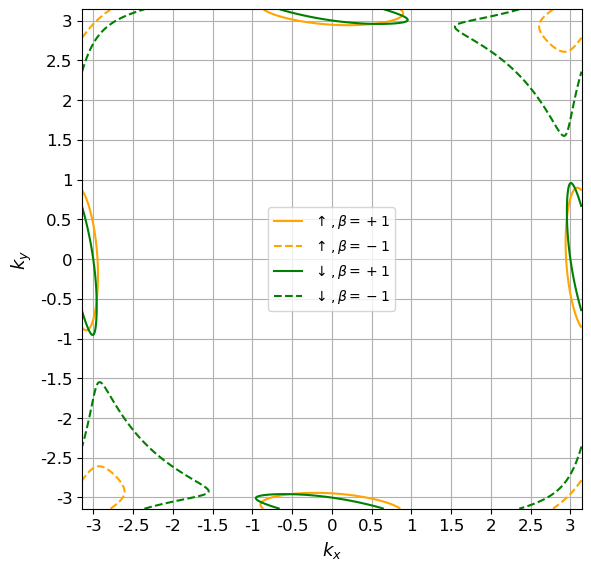

In [694]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

# === Your energy function should already be defined like this ===
# def energy_split(KX, KY, delta_up, delta_down, t, mu, epsilon):
#     ... return E_up_plus, E_up_minus, E_down_plus, E_down_minus

# === Function to compute area from contour lines ===
def compute_area_from_contour(contour_set):
    total_area = 0.0
    for path in contour_set.get_paths():
        verts = path.vertices
        x, y = verts[:, 0], verts[:, 1]
        # Shoelace formula for polygon area
        area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
        total_area += area
    return total_area


# === Grid and constants ===
plt.figure(figsize=(6, 6))
n_k2 = 500
kx = np.linspace(-np.pi, np.pi, n_k2)
ky = np.linspace(-np.pi, np.pi, n_k2)
KX, KY = np.meshgrid(kx, ky)

mu = 0.064
epsilo = 0.1 # for strained case

# === Unstrained Case ===
E_up_plus, E_up_minus, E_down_plus, E_down_minus = energy_split(KX, KY, 0.416, -0.416, 1,  mu, 0)

#cont1 = plt.contour(KX, KY, E_up_plus, levels=[0], colors='red', linewidths=1.5)
#cont2 = plt.contour(KX, KY, E_up_minus, levels=[0], colors='red', linestyles='dashed', linewidths=1.5)
#cont3 = plt.contour(KX, KY, E_down_plus, levels=[0], colors='blue', linewidths=1.5)
#cont4 = plt.contour(KX, KY, E_down_minus, levels=[0], colors='blue', linestyles='dashed', linewidths=1.5)

# Compute areas
area_up_unstrained = compute_area_from_contour(cont1) + compute_area_from_contour(cont2)
area_down_unstrained = compute_area_from_contour(cont3) + compute_area_from_contour(cont4)
magnetization_unstrained = area_up_unstrained - area_down_unstrained

# === Strained Case ===

E_up_plus_s, E_up_minus_s, E_down_plus_s, E_down_minus_s = energy_split(KX, KY,  0.237, -0.163, 1,0.07394, epsilo)

cont5 = plt.contour(KX, KY, E_up_plus_s, levels=[0], colors='orange', linewidths=1.5)
cont6 = plt.contour(KX, KY, E_up_minus_s, levels=[0], colors='orange', linestyles='dashed', linewidths=1.5)
cont7 = plt.contour(KX, KY, E_down_plus_s, levels=[0], colors='green', linewidths=1.5)
cont8 = plt.contour(KX, KY, E_down_minus_s, levels=[0], colors='green', linestyles='dashed', linewidths=1.5)

# Compute areas
area_up_strained = compute_area_from_contour(cont5) + compute_area_from_contour(cont6)
area_down_strained = compute_area_from_contour(cont7) + compute_area_from_contour(cont8)
magnetization_strained = area_up_strained - area_down_strained

# === Display results ===
print("=== Magnetization Summary ===")
print(f"Unstrained:   Area Up = {area_up_unstrained:.4f}, Area Down = {area_down_unstrained:.4f}, ΔArea = {magnetization_unstrained:.4f}")
print(f"Strained:     Area Up = {area_up_strained:.4f}, Area Down = {area_down_strained:.4f}, ΔArea = {magnetization_strained:.4f}")

# === Plot labels, grid, etc. ===
tick_positions = [-3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]
tick_labels = tick_positions
plt.xticks(tick_positions, tick_labels, fontsize=12)
plt.yticks(tick_positions, tick_labels, fontsize=12)

#plt.title(f"$E_F = 0$, $\epsilon={epsilo}$, $M_s={magnetization_strained:.4f}$  ")
plt.xlabel("$k_x$",fontsize=13)
plt.ylabel("$k_y$",fontsize=13)
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

# === Legend ===
from matplotlib.lines import Line2D
legend_elements = [
    #Line2D([0], [0], color='red', linestyle='solid', label=r'$\uparrow$ unstrained'),
    #Line2D([0], [0], color='blue', linestyle='solid', label=r'$\downarrow$ unstrained'),
    Line2D([0], [0], color='orange', label=r'$\uparrow, \beta=+1$'),
    Line2D([0], [0], color='orange', linestyle='dashed', label=r'$\uparrow, \beta=-1$'),
    Line2D([0], [0], color='green', label=r'$\downarrow, \beta=+1$'),
    Line2D([0], [0], color='green', linestyle='dashed', label=r'$\downarrow, \beta=-1$')
]
plt.legend(handles=legend_elements, loc='center', fontsize=10)

plt.tight_layout()
plt.savefig('fermi surface unstrained,strained.png')
plt.show()


=== Magnetization Summary ===
Unstrained:   Area Up = 0.0000, Area Down = 0.0000, ΔArea = 0.0000


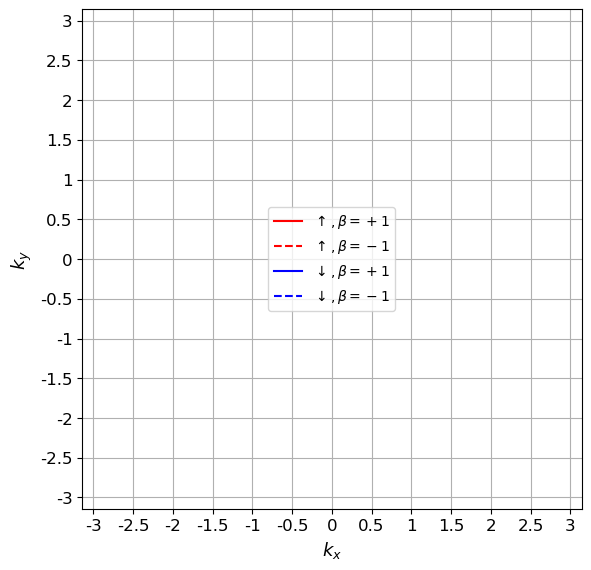

In [208]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

# === Your energy function should already be defined like this ===
# def energy_split(KX, KY, delta_up, delta_down, t, mu, epsilon):
#     ... return E_up_plus, E_up_minus, E_down_plus, E_down_minus

# === Function to compute area from contour lines ===
def compute_area_from_contour(contour_set):
    total_area = 0.0
    for path in contour_set.get_paths():
        verts = path.vertices
        x, y = verts[:, 0], verts[:, 1]
        # Shoelace formula for polygon area
        area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
        total_area += area
    return total_area


# === Grid and constants ===
plt.figure(figsize=(6, 6))
n_k2 = 500
kx = np.linspace(-np.pi, np.pi, n_k2)
ky = np.linspace(-np.pi, np.pi, n_k2)
KX, KY = np.meshgrid(kx, ky)

mu = 0.064
epsilo = 0.15 # for strained case

# === Unstrained Case ===
E_up_plus, E_up_minus, E_down_plus, E_down_minus = energy_split(KX, KY, 0.415680, -0.415680, 1,  0.107, 0)

cont1 = plt.contour(KX, KY, E_up_plus, levels=[0], colors='red', linewidths=1.5)
cont2 = plt.contour(KX, KY, E_up_minus, levels=[0], colors='red', linestyles='dotted', linewidths=1.5)
cont3 = plt.contour(KX, KY, E_down_plus, levels=[0], colors='blue', linewidths=1.5)
cont4 = plt.contour(KX, KY, E_down_minus, levels=[0], colors='blue', linestyles='dotted', linewidths=1.5)

# Compute areas
area_up_unstrained = compute_area_from_contour(cont1) + compute_area_from_contour(cont2)
area_down_unstrained = compute_area_from_contour(cont3) + compute_area_from_contour(cont4)
magnetization_unstrained = area_up_unstrained - area_down_unstrained

# === Strained Case ===
#E_up_plus_s, E_up_minus_s, E_down_plus_s, E_down_minus_s = energy_split(KX, KY,  0.206, -0.155, 1, 0.107887, epsilo)

#cont5 = plt.contour(KX, KY, E_up_plus_s, levels=[0], colors='orange', linestyles='dashed', linewidths=1.5)
#cont6 = plt.contour(KX, KY, E_up_minus_s, levels=[0], colors='orange', linestyles='dashdot', linewidths=1.5)
#cont7 = plt.contour(KX, KY, E_down_plus_s, levels=[0], colors='green', linestyles='dashed', linewidths=1.5)
#cont8 = plt.contour(KX, KY, E_down_minus_s, levels=[0], colors='green', linestyles='dashdot', linewidths=1.5)

# Compute areas
#area_up_strained = compute_area_from_contour(cont5) + compute_area_from_contour(cont6)
#area_down_strained = compute_area_from_contour(cont7) + compute_area_from_contour(cont8)
#magnetization_strained = area_up_strained - area_down_strained

# === Display results ===
print("=== Magnetization Summary ===")
print(f"Unstrained:   Area Up = {area_up_unstrained:.4f}, Area Down = {area_down_unstrained:.4f}, ΔArea = {magnetization_unstrained:.4f}")
#print(f"Strained:     Area Up = {area_up_strained:.4f}, Area Down = {area_down_strained:.4f}, ΔArea = {magnetization_strained:.4f}")

# === Plot labels, grid, etc. ===
tick_positions = [-3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]
tick_labels = tick_positions
plt.xticks(tick_positions, tick_labels, fontsize=12)
plt.yticks(tick_positions, tick_labels, fontsize=12)

#plt.title(f"$E_F = 0$, $\epsilon={epsilo}$, $M_s={magnetization_strained:.4f}$  ")
plt.xlabel("$k_x$",fontsize=13)
plt.ylabel("$k_y$",fontsize=13)
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

# === Legend ===
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', label=r'$\uparrow, \beta=+1$'),
    Line2D([0], [0], color='red', linestyle='dashed', label=r'$\uparrow, \beta=-1$'),
    Line2D([0], [0], color='blue', label=r'$\downarrow, \beta=+1$'),
    Line2D([0], [0], color='blue', linestyle='dashed', label=r'$\downarrow, \beta=-1$')
]
plt.legend(handles=legend_elements, loc='center', fontsize=10)

plt.tight_layout()
plt.savefig('fermi surface unstrained,strained.png')
plt.show()


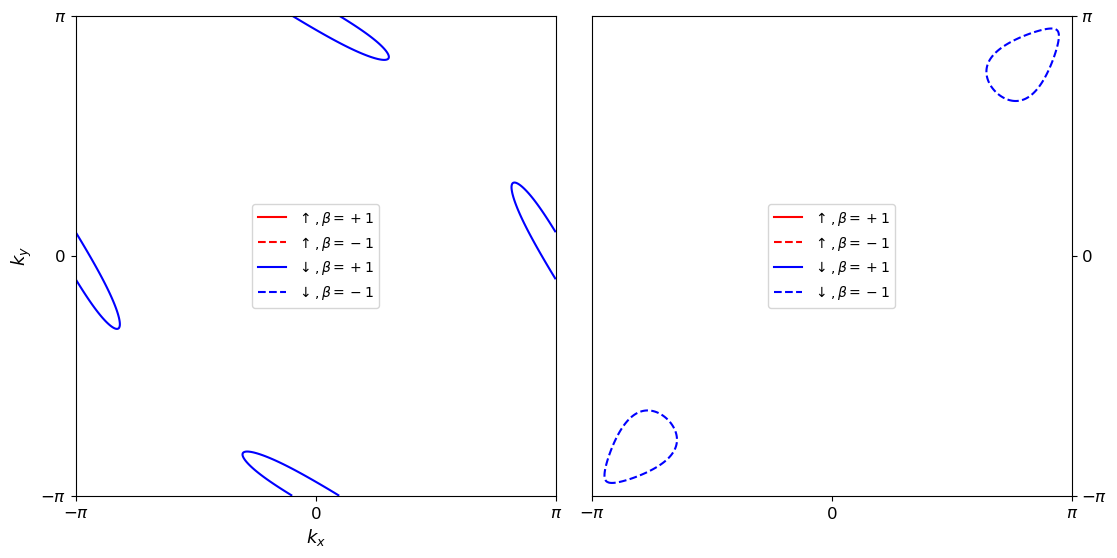

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

N_A = 0.831680
N_B = -0.861704
mu  = 1.156991
N_A2 = 0.861549
N_B2 = -0.831546
mu_2 = -0.945651

U = 3



fig= plt.figure( figsize=(12, 6))

# === Grid and constants ===
n_k2 = 500
kx = np.linspace(-np.pi, np.pi, n_k2)
ky = np.linspace(-np.pi, np.pi, n_k2)
KX, KY = np.meshgrid(kx, ky)

ax1=fig.add_axes([0.05,0.1,0.45,0.8])

E_up_plus, E_up_minus, E_down_plus, E_down_minus = energy_split(KX, KY, N_A, N_B, U,  mu, 0.05)

cont1 = ax1.contour(KX, KY, E_up_plus, levels=[0], colors='red', linewidths=1.5)
cont2 = ax1.contour(KX, KY, E_up_minus, levels=[0], colors='red', linestyles='dotted', linewidths=1.5)
cont3 = ax1.contour(KX, KY, E_down_plus, levels=[0], colors='blue', linewidths=1.5)
cont4 = ax1.contour(KX, KY, E_down_minus, levels=[0], colors='blue', linestyles='dotted', linewidths=1.5)

ax1.set_xlabel("$k_x$",fontsize=13)
ax1.set_ylabel("$k_y$",fontsize=13)

ax1.set_aspect('equal', adjustable='box')

tick_positions = [-np.pi,0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
ax1.set_xticks(tick_positions, tick_labels, fontsize=12)
ax1.set_yticks(tick_positions, tick_labels, fontsize=12)

# === Legend ===
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', label=r'$\uparrow, \beta=+1$'),
    Line2D([0], [0], color='red', linestyle='dashed', label=r'$\uparrow, \beta=-1$'),
    Line2D([0], [0], color='blue', label=r'$\downarrow, \beta=+1$'),
    Line2D([0], [0], color='blue', linestyle='dashed', label=r'$\downarrow, \beta=-1$')
]
ax1.legend(handles=legend_elements, loc='center', fontsize=10)



# === Strained Case ===
ax2=fig.add_axes([0.48,0.1,0.45,0.8])

E_up_plus_s, E_up_minus_s, E_down_plus_s, E_down_minus_s = energy_split(KX, KY, N_A2, N_B2, U, mu_2, 0.05)

cont5 = ax2.contour(KX, KY, E_up_plus_s, levels=[0], colors='red', linewidths=1.5)
cont6 = ax2.contour(KX, KY, E_up_minus_s, levels=[0], colors='red', linestyles='dashed', linewidths=1.5)
cont7 = ax2.contour(KX, KY, E_down_plus_s, levels=[0], colors='blue', linewidths=1.5)
cont8 = ax2.contour(KX, KY, E_down_minus_s, levels=[0], colors='blue', linestyles='dashed', linewidths=1.5)


# === Plot labels, grid, etc. ===
tick_positions = [-np.pi,0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
ax2.set_xticks(tick_positions, tick_labels, fontsize=12)
ax2.set_yticks(tick_positions, tick_labels, fontsize=12)
ax2.yaxis.tick_right()


#plt.title(f"$E_F = 0$, $\epsilon={epsilo}$, $M_s={magnetization_strained:.4f}$  ")
#ax2.set_xlabel("$k_x$",fontsize=13)
#ax2.set_ylabel("$k_y$",fontsize=13)



# === Legend ===
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', label=r'$\uparrow, \beta=+1$'),
    Line2D([0], [0], color='red', linestyle='dashed', label=r'$\uparrow, \beta=-1$'),
    Line2D([0], [0], color='blue', label=r'$\downarrow, \beta=+1$'),
    Line2D([0], [0], color='blue', linestyle='dashed', label=r'$\downarrow, \beta=-1$')
]
ax2.legend(handles=legend_elements, loc='center', fontsize=10)
ax2.set_aspect('equal', adjustable='box')


plt.savefig('fermi surface U=0.996 unstrained,strained.png', bbox_inches='tight', pad_inches=0.1)
plt.show()


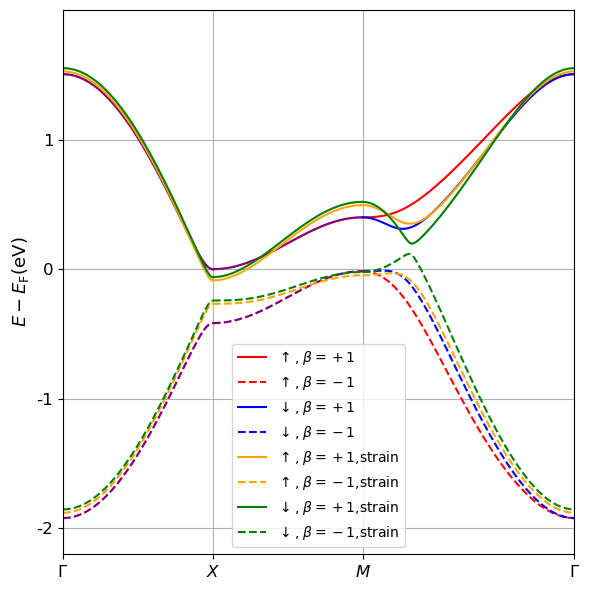

In [33]:
# High-symmetry points: Γ → X → M → Γ
G = np.array([0, 0])
X = np.array([np.pi, 0])
M = np.array([np.pi, np.pi])
path = [G, X, M, G]
labels = [r'$\Gamma$', r'$X$', r'$M$', r'$\Gamma$']
points_per_segment = 200

mu=0.108
epsilo=0.15

k1=np.linspace(0,np.pi,100)
k0=np.full_like(k1,0) 
k2=np.full_like(k1,np.pi)
k3=np.linspace(np.pi,0,100)


E1=energy_split(k1, k0, 0.416, -0.416, 1, mu, 0)
E2=energy_split(k2, k1, 0.416, -0.416, 1, mu, 0)
E3=energy_split(k3, k3, 0.416, -0.416, 1, mu, 0)


#plotting all bands for each path between high symmetry points
plt.figure(figsize=(6, 6))

plt.plot(np.linspace(0,1,100), E1[0], label=r'$\uparrow$, $\beta=+1$', color='red')
plt.plot(np.linspace(0,1,100), E1[1], '--', label=r'$\uparrow$, $\beta=-1$ ', color='red')
plt.plot(np.linspace(0,1,100), E1[2], color='blue',alpha=0.5)
plt.plot(np.linspace(0,1,100), E1[3],'--', color='blue',alpha=0.5)

plt.plot(np.linspace(1,2,100), E2[0], color='red')
plt.plot(np.linspace(1,2,100), E2[1], '--', color='red')
plt.plot(np.linspace(1,2,100), E2[2], color='blue',alpha=0.5)
plt.plot(np.linspace(1,2,100), E2[3],'--',  color='blue',alpha=0.5)

plt.plot(np.linspace(2,2+np.sqrt(2),100), E3[0], color='red')
plt.plot(np.linspace(2,2+np.sqrt(2),100), E3[1], '--', color='red')
plt.plot(np.linspace(2,2+np.sqrt(2),100), E3[2], label=r'$\downarrow$, $\beta=+1$', color='blue')
plt.plot(np.linspace(2,2+np.sqrt(2),100), E3[3],'--', label=r'$\downarrow$, $\beta=-1$', color='blue')




# Band structure calculation
N_A= 0.206
N_B=-0.155
mu2=0.064

E12=energy_split(k1, k0, N_A, N_B, 1, mu2, epsilo)
E22=energy_split(k2, k1, N_A, N_B, 1, mu2, epsilo)
E32=energy_split(k3, k3, N_A, N_B, 1, mu2, epsilo)


#plotting all bands for each path between high symmetry points

plt.plot(np.linspace(0,1,100), E12[0], label=r'$\uparrow$, $\beta=+1$,strain', color='orange')
plt.plot(np.linspace(0,1,100), E12[1], '--', label=r'$\uparrow$, $\beta=-1$,strain', color='orange')
plt.plot(np.linspace(0,1,100), E12[2],label=r'$\downarrow$, $\beta=+1$,strain', color='green')
plt.plot(np.linspace(0,1,100), E12[3],'--', label=r'$\downarrow$, $\beta=-1$,strain', color='green')

plt.plot(np.linspace(1,2,100), E22[0], color='orange')
plt.plot(np.linspace(1,2,100), E22[1], '--' ,color='orange')
plt.plot(np.linspace(1,2,100), E22[2], color='green')
plt.plot(np.linspace(1,2,100), E22[3],'--',  color='green')

plt.plot(np.linspace(2,2+np.sqrt(2),100), E32[0], color='orange')
plt.plot(np.linspace(2,2+np.sqrt(2),100), E32[1], '--', color='orange')
plt.plot(np.linspace(2,2+np.sqrt(2),100), E32[2], color='green')
plt.plot(np.linspace(2,2+np.sqrt(2),100), E32[3],'--', color='green')

# Set custom x-axis ticks and labels
tick_positions = [0,1,2,2+np.sqrt(2)]
tick_labels = labels
plt.xticks(tick_positions, tick_labels, fontsize=12)

y_tick_positions=[-2,-1,0,1]
y_tick_labels=[-2,-1,0,1]
plt.yticks(y_tick_positions,y_tick_labels, fontsize=12)



#plt.xlabel("k-path")
plt.ylabel(r"$E-E_\text{F}(\text{eV})$",fontsize=13)
#plt.title(f"Band Dispersion along High-Symmetry Path for $\epsilon$={epsilo}")
plt.xlim(0,2+np.sqrt(2))
plt.ylim(-2.2,2)
plt.grid(True)
plt.legend(loc='lower center')
plt.tight_layout()
plt.savefig('dispersion along path strained,unstrained.png', bbox_inches='tight', pad_inches=0.1)
plt.show()


# N(U)

In [546]:
#k grid
n_k = 150
kx = np.linspace(-np.pi, np.pi, n_k)
ky = np.linspace(-np.pi, np.pi, n_k)
KX, KY = np.meshgrid(kx, ky)

# Initial values
eps=0
x = 0
U_arr0 = np.concatenate((np.linspace(0.8,0.9,3),np.linspace(0.92,1,5),np.linspace(1.2,6,5))) 


#starting mu
n_0=1
N_0=0
U_0=1



#self consistent
N_A_U0=[]
N_B_U0=[]
mu_U0=[]

for U in U_arr0:
    try:
        mu_0 = brentq(density_difference_total, -10, 10, args=(N_0,-N_0 ,U, n_0, T,eps), xtol=1e-5)
    except ValueError:
        print("mu not found")
    mu_current = mu_0
    N_A_current = 0.4
    N_B_current = -0.4
    for i in range(200):
        # Compute updated order parameters
        N_A_new = x * N_A_current + (1 - x) * order_param(N_A_current, N_B_current, U, mu_current, T,eps)
        N_B_new = x * N_B_current + (1 - x) * order_param2(N_A_current, N_B_current, U, mu_current, T,eps)

        # Update mu to maintain total density ~1
        try:
            mu_new = brentq(density_difference_total, -10, 10, args=(N_A_new, N_B_new, U, n_0, T,eps), xtol=1e-5)
        except ValueError:
            print("mu not found")
            break

        # Check total density
        n_new_A = n_e(N_A_new, N_B_new, U, mu_new, T, eps)
        n_new_B = n_e2(N_A_new, N_B_new, U, mu_new, T, eps)
        n_total = (n_new_A + n_new_B) / 2

        #print(f"step {i+1}: N_A = {N_A_new:.3f}, N_B = {N_B_new:.3f}, μ = {mu_new:.3f}, n = {n_total:.3f}")

        # Check convergence
        if (np.abs(N_A_new - N_A_current) +
            np.abs(N_B_new - N_B_current) +
            np.abs(n_total - n_0)) < 1e-4:
            print(f"✅ Converged in {i+1} steps.")
            break
        elif i+1==1000:
            print(f"Did not converge in {i+1} steps.")

        # Update for next step
        N_A_current = N_A_new
        N_B_current = N_B_new
        mu_current = mu_new
    N_A_U0.append(N_A_current)
    N_B_U0.append(N_B_current)
    mu_U0.append(mu_current)


#print("\n📌 Final self-consistent results:")
#print(f"N_A = {N_A_current:.6f}")
#print(f"N_B = {N_B_current:.6f}")
#print(f"μ   = {mu_current:.6f}")
#print(f"n   = {(n_e(N_A_current, N_B_current, U, mu_current, T,eps) + n_e2(N_A_current, N_B_current, U, mu_current, T,eps)) / 2:.6f}")
#print(f"N_A + N_B = {N_A_current + N_B_current:.6e}")



print(N_A_U0,N_B_U0,mu_U0)
N_A_U_array0=np.array(N_A_U0)
N_B_U_array0=np.array(N_B_U0)
mu_U_array0=np.array(mu_U0)

# Find critical temperature where W becomes nearly zero
epsilon = 1e-1
U_values0 = U_arr0


#Find first index where W < epsilon
try:
    idx = np.where(np.abs(N_A_U_array0) > epsilon)[0][0]
    U_A_critical0 = U_values0[idx-1]
    print(f"Estimated critical interaction U_c where N_A ≈ 0: {U_A_critical0:.2f} meV")
except IndexError:
    print("N_A does not drop below threshold within U range.")
    U_A_critical0 = None

try:
    idx = np.where(np.abs(N_B_U_array0) > epsilon)[0][0]
    U_B_critical0 = U_values0[idx-1]
    print(f"Estimated critical interaction U_c where N_B ≈ 0: {U_B_critical0:.2f} meV")
except IndexError:
    print("N_B does not drop below threshold within U range.")
    U_B_critical0 = None

✅ Converged in 30 steps.
✅ Converged in 38 steps.
✅ Converged in 56 steps.
✅ Converged in 49 steps.
✅ Converged in 59 steps.
✅ Converged in 69 steps.
✅ Converged in 71 steps.
✅ Converged in 15 steps.
✅ Converged in 12 steps.
✅ Converged in 12 steps.
✅ Converged in 12 steps.
[0.00012320218605179294, 0.00017303668872001277, 0.0001874864089502941, 0.0022458784904012307, 0.002443509359924989, 0.003592371270652167, 0.005328034531056195, 0.4154925005770898, 0.46431808595636176, 0.5091172299557597, 0.5499081673765847] [-0.00012320218605179324, -0.00017303668872001375, -0.00018748640895029488, -0.0022458784904012307, -0.002443509359924989, -0.003592371270658309, -0.005328034531056195, -0.4154925005770898, -0.46431808595636176, -0.5091172299557597, -0.5499081673765847] [0.1279854117025772, 0.12797755147560635, 0.12797587958796622, 0.12826179760522066, 0.1282381638406713, 0.12810552522754848, 0.12806068188322445, 0.10753920763264818, 0.15516780279204176, 0.20525233957271255, 0.25723979229927096]

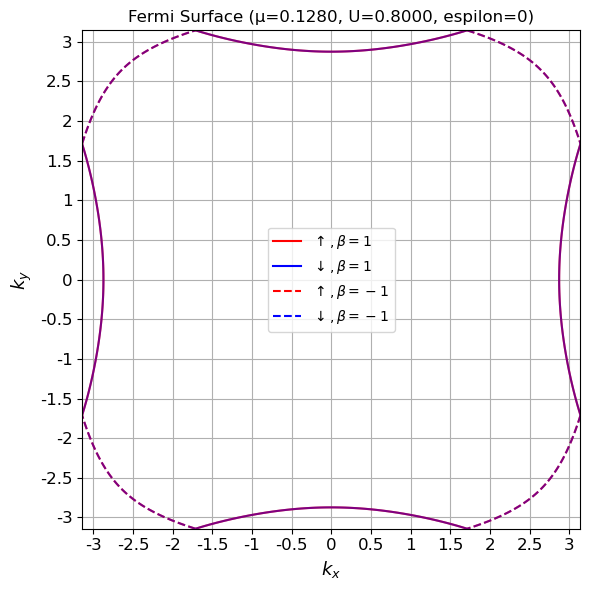

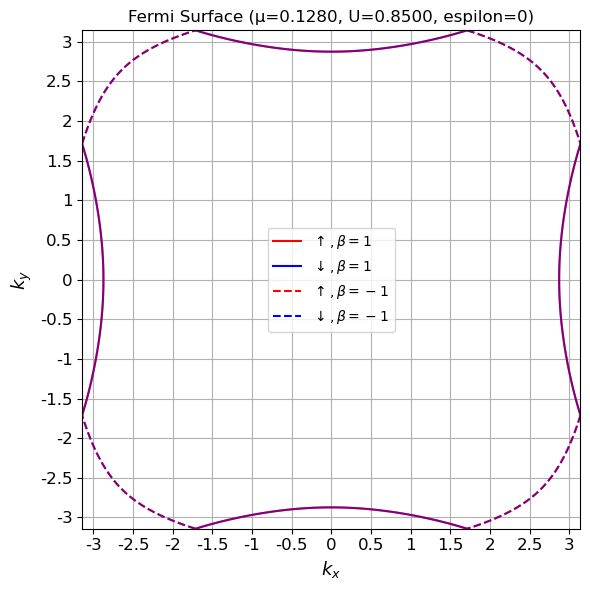

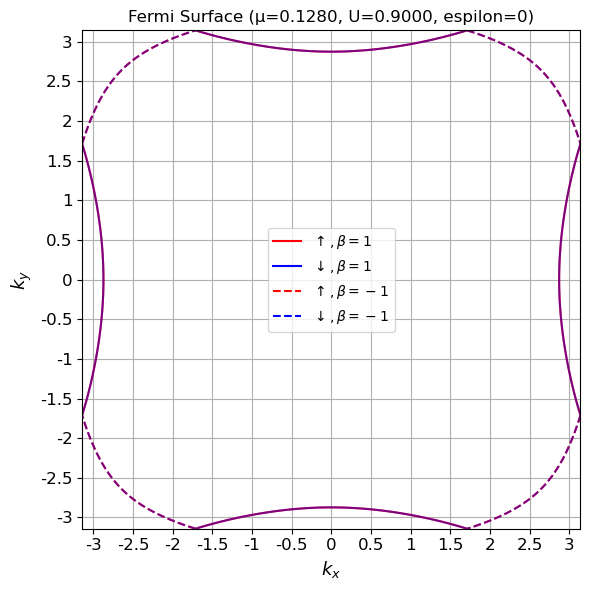

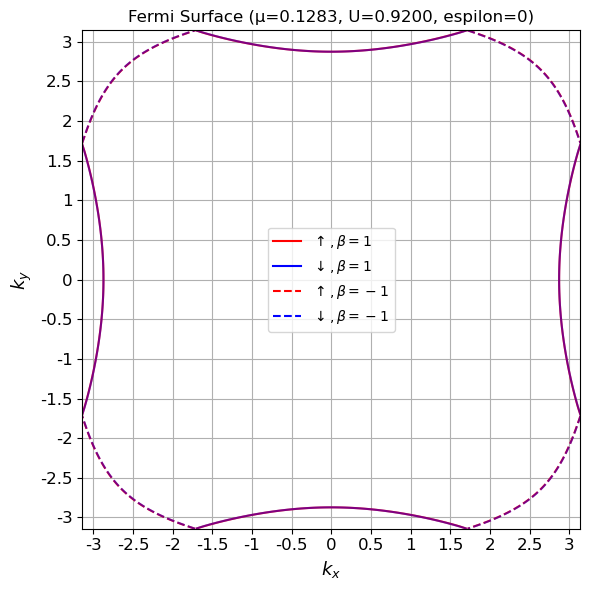

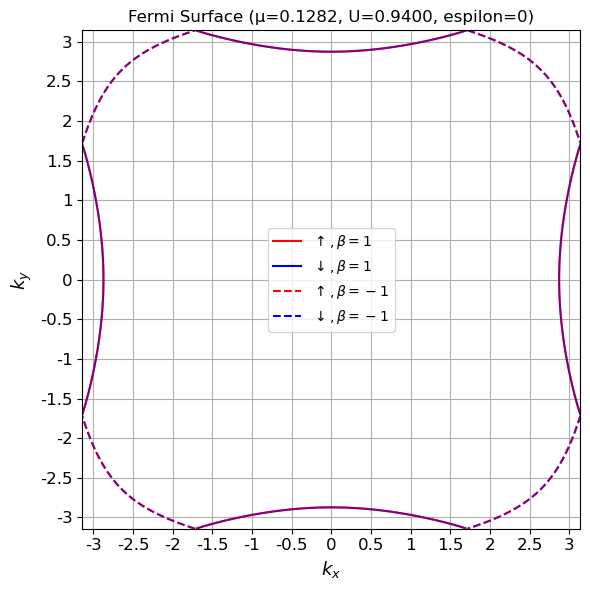

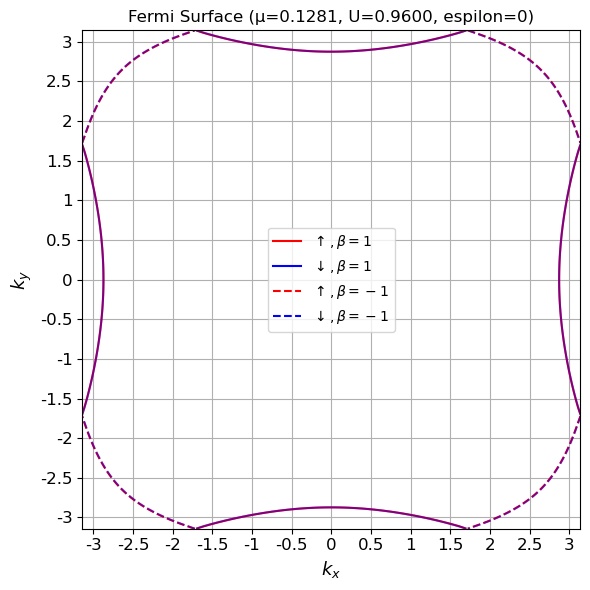

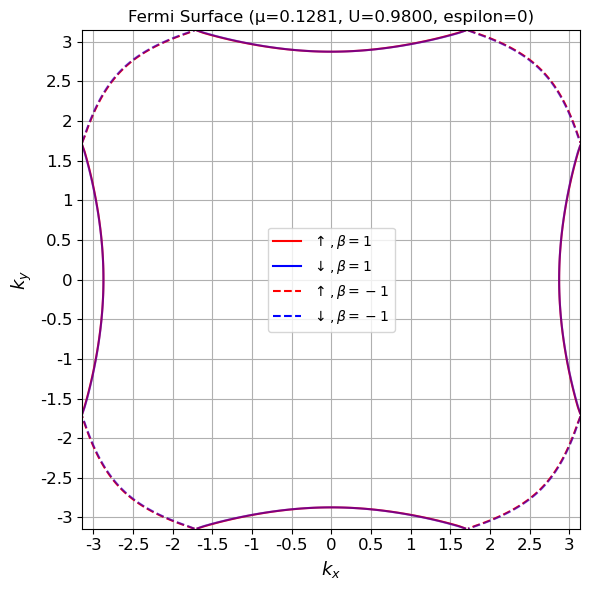

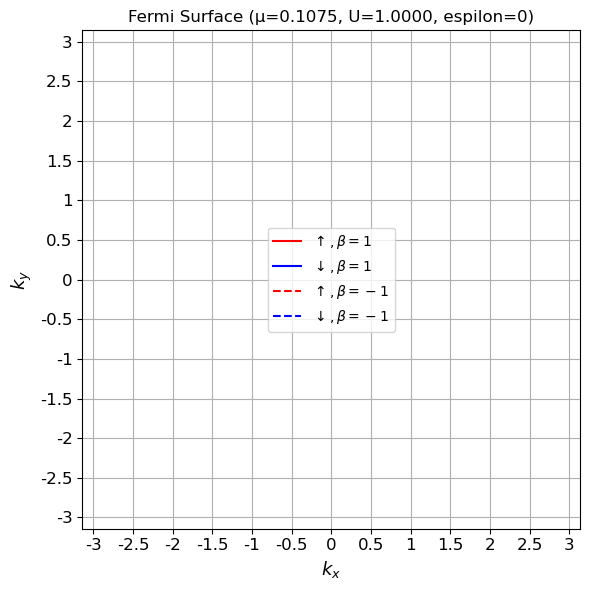

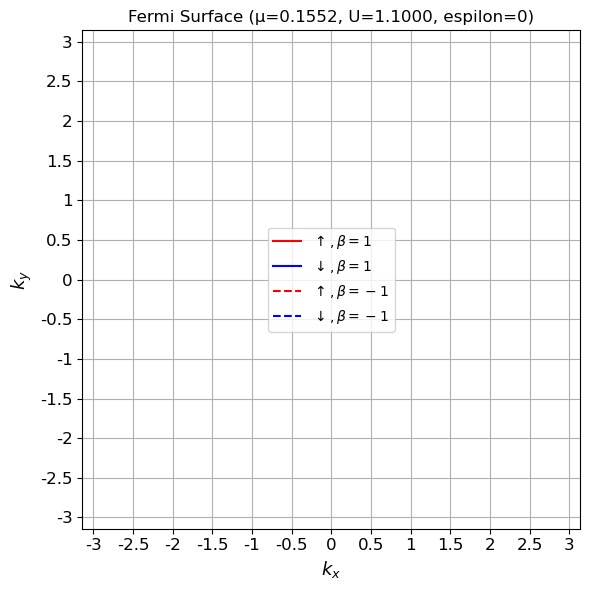

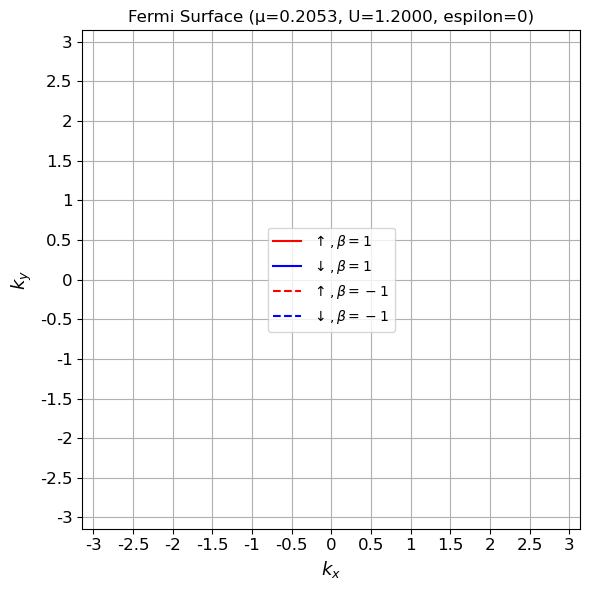

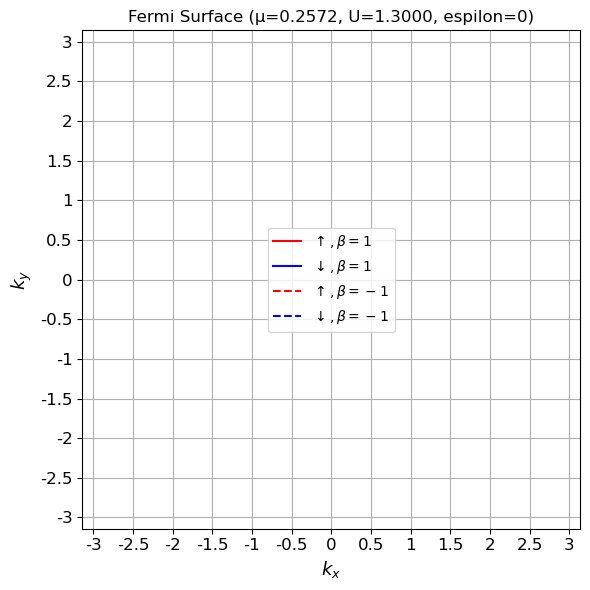

In [558]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# === Grid Setup ===
n_k2 = 200
kx = np.linspace(-np.pi, np.pi, n_k2)
ky = np.linspace(-np.pi, np.pi, n_k2)
KX, KY = np.meshgrid(kx, ky)


# === Loop over parameter sets ===
for i, (N_A_U, N_B_U, mu_U, U_val) in enumerate(zip(N_A_U_array0, N_B_U_array0, mu_U_array0, U_arr0)):

    # Compute energies
    E_up_plus, E_up_minus, E_down_plus, E_down_minus = energy_split(KX, KY, N_A_U, N_B_U, U_val, mu_U, 0)

    # === Plotting ===
    plt.figure(figsize=(6, 6))

    cont1 = plt.contour(KX, KY, E_up_plus, levels=[0], colors='red', linewidths=1.5)
    cont2 = plt.contour(KX, KY, E_up_minus, levels=[0], colors='red', linestyles='dashed', linewidths=1.5)
    cont3 = plt.contour(KX, KY, E_down_plus, levels=[0], colors='blue',linewidths=1.5,alpha=0.5)
    cont4 = plt.contour(KX, KY, E_down_minus, levels=[0], colors='blue', linestyles='dashed', linewidths=1.5,alpha=0.5)

    # === Axis ticks and grid ===
    tick_positions = [-3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]
    tick_labels = tick_positions
    plt.xticks(tick_positions, tick_labels, fontsize=12)
    plt.yticks(tick_positions, tick_labels, fontsize=12)
    plt.grid(True)

    # === Title and labels ===
    plt.title(f"Fermi Surface (μ={mu_U:.4f}, U={U_val:.4f}, espilon={eps})")
    plt.xlabel("$k_x$",fontsize=13)
    plt.ylabel("$k_y$",fontsize=13)
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

    # === Legend ===
    legend_elements = [
        Line2D([0], [0], color='red', linestyle='solid', label=r'$\uparrow,\beta=1$'),
        Line2D([0], [0], color='blue', linestyle='solid', label=r'$\downarrow,\beta=1$'),
        Line2D([0], [0], color='red', linestyle='dashed', label=r'$\uparrow,\beta=-1$'),
        Line2D([0], [0], color='blue', linestyle='dashed', label=r'$\downarrow,\beta=-1$')
    ]
    plt.legend(handles=legend_elements, loc='center', fontsize=10)

    # === Save and show ===
    plt.tight_layout()
    filename = f"1fermi_surface_mu{mu_U:.3f}_U{U_val:.2f}_i{i}.png"
    plt.savefig(filename)
    plt.show()
    plt.close()


🧊 System becomes insulating at U ≈ 0.990


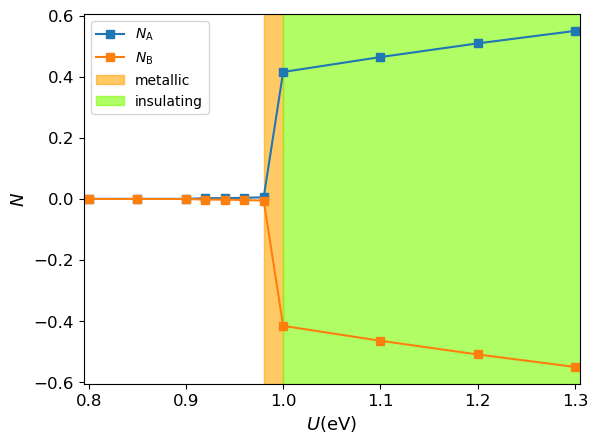

In [903]:
# Track whether Fermi surface exists
has_fermi_surface0 = []

for i in range(len(U_arr0)):
    N_A = N_A_U_array0[i]
    N_B = N_B_U_array0[i]
    mu = mu_U_array0[i]
    U = U_arr0[i]

    # Calculate band energies
    E_up_plus, E_up_minus, E_down_plus, E_down_minus = energy_split(KX, KY, N_A, N_B, U, mu, eps)

    # Check if any band crosses E = 0
    surfaces_exist0 = False
    for E in [E_up_plus, E_up_minus, E_down_plus, E_down_minus]:
        if np.any(np.signbit(E) != np.signbit(E[0, 0])):  # crude check for sign change (E=0 crossing)
            surfaces_exist0 = True
            break

    has_fermi_surface0.append(surfaces_exist0)

# Determine critical U
try:
    insulating_idx0 = np.where(np.array(has_fermi_surface0) == False)[0][0]
    U_c_insulator0 = U_arr[insulating_idx0]
    print(f"🧊 System becomes insulating at U ≈ {U_c_insulator0:.3f}")
except IndexError:
    print("⚠️ Fermi surface never disappears in the tested U range.")
    U_c_insulator0 = None


plt.plot(U_values0, N_A_U_array0, marker='s', label=r'$N_\text{A}$')
plt.plot(U_values0, N_B_U_array0, marker='s', label=r'$N_\text{B}$')
#if U_critical is not None:
 #   plt.axvline(U_critical, color='r', linestyle='--', label=f'U_c ≈ {U_critical:.1f} K')


#if U_c_insulator0:
    #plt.axvline(U_c_insulator, color='purple', linestyle='--', label=f'$U_i$={U_c_insulator:.3f}')
    
plt.axvspan(U_A_critical0,1 , color='orange', alpha=0.6,label=f'metallic')
plt.axvspan(1, U_arr0[-1]+0.05, color='lawngreen', alpha=0.6,label=f'insulating')


#plt.plot(np.linspace(0,U_max,n_U),N_U_array, label='N(U)')
#plt.axvline(U_A_critical, color='r', linestyle='--', label=f'$U_c$={U_A_critical:.3f}')
#plt.axvline(U_B_critical, color='r', linestyle='--')


plt.xlim(0.795,1.305)

plt.xlabel(r'$U (\text{eV})$',fontsize=13)
plt.ylabel(r'$N$',fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
#plt.title(f'')
plt.savefig('NA,NB and U.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

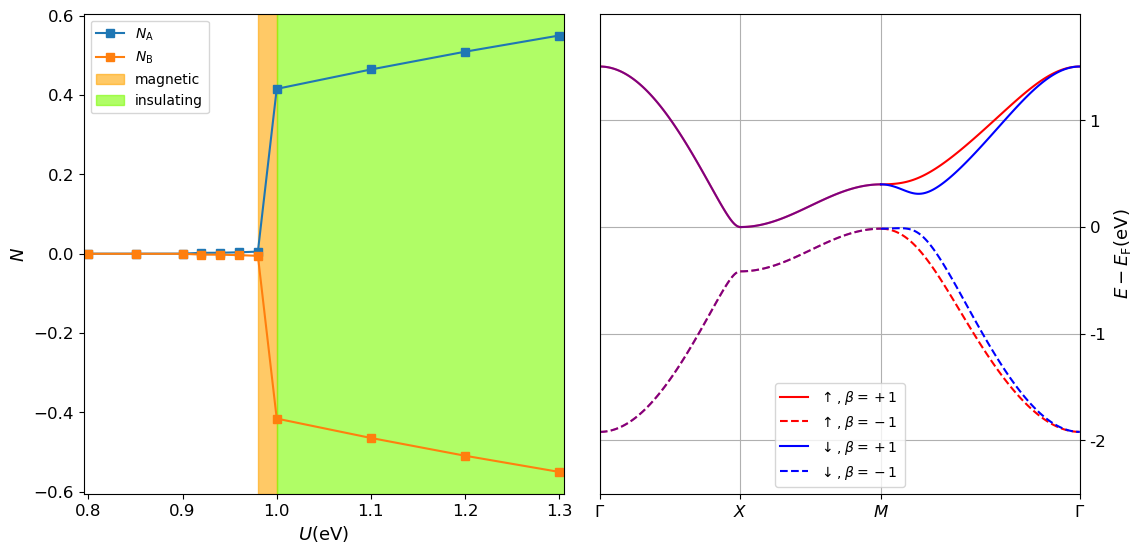

In [912]:
fig=plt.figure(figsize=(12, 6))

ax1=fig.add_axes([0.05,0.1,0.4,0.8])

ax1.plot(U_values0, N_A_U_array0, marker='s', label=r'$N_\text{A}$')
ax1.plot(U_values0, N_B_U_array0, marker='s', label=r'$N_\text{B}$')

ax1.axvspan(U_A_critical0,1 , color='orange', alpha=0.6,label=f'metallic')
ax1.axvspan(1, U_arr0[-1]+0.05, color='lawngreen', alpha=0.6,label=f'insulating')
    



ax1.set_xlim(0.795,1.305)
ax1.tick_params(axis='both', labelsize=12)
ax1.set_xlabel(r'$U (\text{eV})$',fontsize=13)
ax1.set_ylabel(r'$N$',fontsize=13)
ax1.legend()


ax2=fig.add_axes([0.48,0.1,0.4,0.8])



G = np.array([0, 0])
X = np.array([np.pi, 0])
M = np.array([np.pi, np.pi])
path = [G, X, M, G]
labels = [r'$\Gamma$', r'$X$', r'$M$', r'$\Gamma$']
points_per_segment = 200

k1=np.linspace(0,np.pi,100)
k0=np.full_like(k1,0) 
k2=np.full_like(k1,np.pi)
k3=np.linspace(np.pi,0,100)


i=[-4]


E1=energy_split(k1, k0, N_A_U_array0[i], N_B_U_array0[i], U_arr0[i], mu_U_array0[i], 0)
E2=energy_split(k2, k1, N_A_U_array0[i], N_B_U_array0[i], U_arr0[i], mu_U_array0[i], 0)
E3=energy_split(k3, k3, N_A_U_array0[i], N_B_U_array0[i], U_arr0[i], mu_U_array0[i], 0)


#plotting all bands for each path between high symmetry points

ax2.plot(np.linspace(0,1,100), E1[0], label=r'$\uparrow$, $\beta=+1$', color='red')
ax2.plot(np.linspace(0,1,100), E1[1], '--', label=r'$\uparrow$, $\beta=-1$ ', color='red')
ax2.plot(np.linspace(0,1,100), E1[2], color='blue',alpha=0.5)
ax2.plot(np.linspace(0,1,100), E1[3],'--',  color='blue',alpha=0.5)

ax2.plot(np.linspace(1,2,100), E2[0], color='red')
ax2.plot(np.linspace(1,2,100), E2[1], '--', color='red')
ax2.plot(np.linspace(1,2,100), E2[2], color='blue',alpha=0.5)
ax2.plot(np.linspace(1,2,100), E2[3],'--',  color='blue',alpha=0.5)

ax2.plot(np.linspace(2,2+np.sqrt(2),100), E3[0], color='red')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E3[1], '--', color='red')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E3[2], label=r'$\downarrow$, $\beta=+1$',color='blue')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E3[3],'--', label=r'$\downarrow$, $\beta=-1$',color='blue')

# Set custom x-axis ticks and labels
tick_positions = [0,1,2,2+np.sqrt(2)]
tick_labels = labels
ax2.set_xticks(tick_positions, tick_labels, fontsize=12)

y_tick_positions=[-3,-2,-1,0,1]
y_tick_labels=[-3,-2,-1,0,1]
ax2.set_yticks(y_tick_positions,y_tick_labels, fontsize=12)
ax2.yaxis.tick_right()

ax2.yaxis.set_label_position("right")

#plt.xlabel("k-path")
ax2.set_ylabel(r"$E-E_\text{F}(\text{eV})$",fontsize=13)
ax2.set_xlim(0,2+np.sqrt(2))
ax2.set_ylim(-2.5,2)
ax2.grid(True)
ax2.legend(loc='lower center')


plt.savefig('N and U and dispersion along path.png', bbox_inches='tight', pad_inches=0.1)
plt.show()


# NA(U)

In [888]:
#k grid
n_k = 150
kx = np.linspace(-np.pi, np.pi, n_k)
ky = np.linspace(-np.pi, np.pi, n_k)
KX, KY = np.meshgrid(kx, ky)

# Initial values
eps=0.05
x = 0
U_arr = np.concatenate((np.linspace(0.8,0.95,4),np.linspace(0.96,1,5),np.linspace(1.1,1.6,3),np.linspace(1.7,1.85,4))) 


#starting mu
n_0=1.015
N_0=0
U_0=1



#self consistent
N_A_U=[]
N_B_U=[]
n_up_A_list=[]
n_down_A_list=[]
n_up_B_list=[]
n_down_B_list=[]
mu_U=[]

for U in U_arr:
    try:
        mu_0 = brentq(density_difference_total, -10, 10, args=(N_0,-N_0 ,U, n_0, T,eps), xtol=1e-5)
    except ValueError:
        print("mu not found")
    mu_current = mu_0
    N_A_current = 0.4
    N_B_current = -0.4
    for i in range(200):
        # Compute updated order parameters
        N_A_new = x * N_A_current + (1 - x) * order_param(N_A_current, N_B_current, U, mu_current, T,eps)
        N_B_new = x * N_B_current + (1 - x) * order_param2(N_A_current, N_B_current, U, mu_current, T,eps)

        # Update mu to maintain total density ~1
        try:
            mu_new = brentq(density_difference_total, -10, 10, args=(N_A_new, N_B_new, U, n_0, T,eps), xtol=1e-5)
        except ValueError:
            print("mu not found")
            break

        # Check total density
        n_new_A = n_e(N_A_new, N_B_new, U, mu_new, T, eps)
        n_new_B = n_e2(N_A_new, N_B_new, U, mu_new, T, eps)
        n_total = (n_new_A + n_new_B) / 2

        n_up_A=n_up(N_A_new,N_B_new,U,mu_new,T,eps)
        n_down_A=n_down(N_A_new,N_B_new,U,mu_new,T,eps)

        n_up_B=n_up2(N_A_new,N_B_new,U,mu_new,T,eps)
        n_down_B=n_down2(N_A_new,N_B_new,U,mu_new,T,eps)

        #print(f"step {i+1}: N_A = {N_A_new:.3f}, N_B = {N_B_new:.3f}, μ = {mu_new:.3f}, n = {n_total:.3f}")

        # Check convergence
        if (np.abs(N_A_new - N_A_current) +
            np.abs(N_B_new - N_B_current) +
            np.abs(n_total - n_0)) < 1e-4:
            print(f"✅ Converged in {i+1} steps.")
            break
        elif i+1==1000:
            print(f"Did not converge in {i+1} steps.")

        # Update for next step
        N_A_current = N_A_new
        N_B_current = N_B_new
        mu_current = mu_new
    N_A_U.append(N_A_current)
    N_B_U.append(N_B_current)
    n_up_A_list.append(n_up_A)
    n_down_A_list.append(n_down_A)
    n_up_B_list.append(n_up_B)
    n_down_B_list.append(n_down_B)
    mu_U.append(mu_current)


#print("\n📌 Final self-consistent results:")
#print(f"N_A = {N_A_current:.6f}")
#print(f"N_B = {N_B_current:.6f}")
#print(f"μ   = {mu_current:.6f}")
#print(f"n   = {(n_e(N_A_current, N_B_current, U, mu_current, T,eps) + n_e2(N_A_current, N_B_current, U, mu_current, T,eps)) / 2:.6f}")
#print(f"N_A + N_B = {N_A_current + N_B_current:.6e}")



print(N_A_U,N_B_U,mu_U)
N_A_U_array=np.array(N_A_U)
N_B_U_array=np.array(N_B_U)
mu_U_array=np.array(mu_U)

# Find critical temperature where W becomes nearly zero
epsilon = 1e-1
U_values = U_arr


#Find first index where W < epsilon
try:
    idx = np.where(np.abs(N_A_U_array) > epsilon)[0][0]
    U_A_critical = U_values[idx-1]
    print(f"Estimated critical interaction U_c where N_A ≈ 0: {U_A_critical:.2f} meV")
except IndexError:
    print("N_A does not drop below threshold within U range.")
    U_A_critical = None

try:
    idx = np.where(np.abs(N_B_U_array) > epsilon)[0][0]
    U_B_critical = U_values[idx-1]
    print(f"Estimated critical interaction U_c where N_B ≈ 0: {U_B_critical:.2f} meV")
except IndexError:
    print("N_B does not drop below threshold within U range.")
    U_B_critical = None

✅ Converged in 27 steps.
✅ Converged in 35 steps.
✅ Converged in 45 steps.
✅ Converged in 71 steps.
✅ Converged in 81 steps.
✅ Converged in 98 steps.
✅ Converged in 18 steps.
✅ Converged in 16 steps.
✅ Converged in 15 steps.
✅ Converged in 14 steps.
✅ Converged in 9 steps.
✅ Converged in 11 steps.
✅ Converged in 11 steps.
✅ Converged in 11 steps.
✅ Converged in 11 steps.
✅ Converged in 11 steps.
[0.0013807359498099383, 0.0015392461301536682, 0.0020913110946355765, 0.0025020594144942927, 0.002747484088744409, 0.0028102948320814767, 0.2982056116231765, 0.3040666799946366, 0.30943510106160904, 0.3610833463772041, 0.4749963958724088, 0.5646610246901074, 0.5944591862974319, 0.6082656571066654, 0.6213556729713072, 0.6339623194812047] [-0.0013807359299595038, -0.001539246102791969, -0.0020914829343390757, -0.0025932679025076014, -0.0026568163691732087, -0.0028964005310810233, -0.298205603728196, -0.3040666799946266, -0.3094351010616154, -0.3610833463777427, -0.4749963958724088, -0.56466102469

⚠️ Fermi surface never disappears in the tested U range.


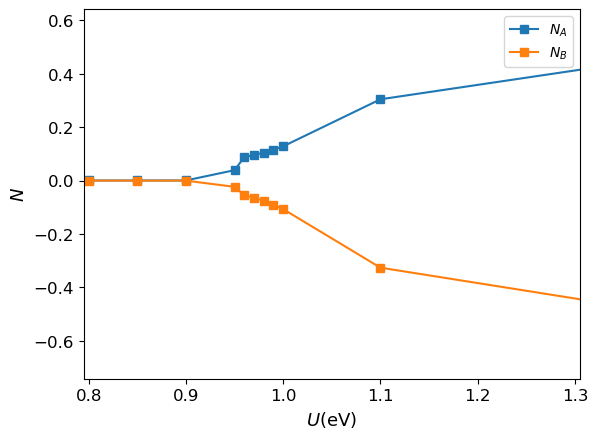

In [520]:
# Track whether Fermi surface exists
has_fermi_surface = []

for i in range(len(U_arr)):
    N_A = N_A_U_array[i]
    N_B = N_B_U_array[i]
    mu = mu_U_array[i]
    U = U_arr[i]

    # Calculate band energies
    E_up_plus, E_up_minus, E_down_plus, E_down_minus = energy_split(KX, KY, N_A, N_B, U, mu, eps)

    # Check if any band crosses E = 0
    surfaces_exist = False
    for E in [E_up_plus, E_up_minus, E_down_plus, E_down_minus]:
        if np.any(np.signbit(E) != np.signbit(E[0, 0])):  # crude check for sign change (E=0 crossing)
            surfaces_exist = True
            break

    has_fermi_surface.append(surfaces_exist)

# Determine critical U
try:
    insulating_idx = np.where(np.array(has_fermi_surface) == False)[0][0]
    U_c_insulator = U_arr[insulating_idx]
    print(f"🧊 System becomes insulating at U ≈ {U_c_insulator:.3f}")
except IndexError:
    print("⚠️ Fermi surface never disappears in the tested U range.")
    U_c_insulator = None


plt.plot(U_values, N_A_U_array, marker='s', label=r'$N_A$')
plt.plot(U_values, N_B_U_array, marker='s', label=r'$N_B$')
#if U_critical is not None:
 #   plt.axvline(U_critical, color='r', linestyle='--', label=f'U_c ≈ {U_critical:.1f} K')


if U_c_insulator:
    #plt.axvline(U_c_insulator, color='purple', linestyle='--', label=f'$U_i$={U_c_insulator:.3f}')
    
    plt.axvspan(U_A_critical,U_c_insulator , color='orange', alpha=0.6,label=f'metallic')
    plt.axvspan(U_c_insulator, U_arr[-1]+0.05, color='lawngreen', alpha=0.6,label=f'insulating')


#plt.plot(np.linspace(0,U_max,n_U),N_U_array, label='N(U)')
#plt.axvline(U_A_critical, color='r', linestyle='--', label=f'$U_c$={U_A_critical:.3f}')
#plt.axvline(U_B_critical, color='r', linestyle='--')


plt.xlim(0.795,1.305)

plt.xlabel(r'$U (\text{eV})$',fontsize=13)
plt.ylabel(r'$N$',fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
#plt.title(f'')
plt.savefig('NA,NB and U.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

⚠️ No U found where only one band crosses the Fermi level.


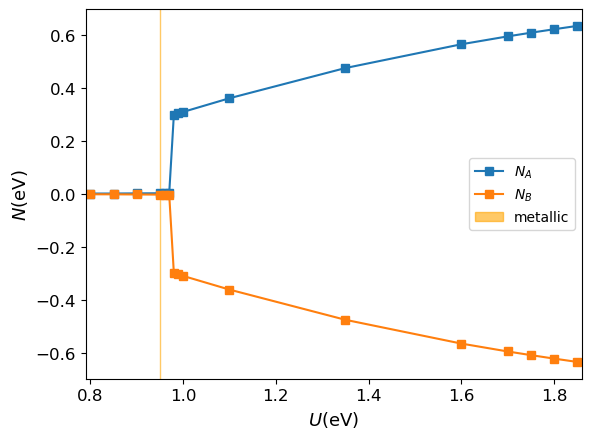

In [897]:
# Track how many bands cross the Fermi level
bands_crossing_count = []
band_labels = ['E_up_plus', 'E_up_minus', 'E_down_plus', 'E_down_minus']
bands_crossing_names = []

for i in range(len(U_arr)):
    N_A = N_A_U_array[i]
    N_B = N_B_U_array[i]
    mu = mu_U_array[i]
    U = U_arr[i]

    # Calculate band energies
    E_up_plus, E_up_minus, E_down_plus, E_down_minus = energy_split(KX, KY, N_A, N_B, U, mu, eps)

    energies = [E_up_plus, E_up_minus, E_down_plus, E_down_minus]
    crossing = []

    for E, label in zip(energies, band_labels):
        if np.any(np.signbit(E) != np.signbit(E[0, 0])):  # crude E = 0 crossing check
            crossing.append(label)

    bands_crossing_count.append(len(crossing))
    bands_crossing_names.append(crossing)

# Find first U where only **one band** crosses Fermi level
try:
    idx_one_band = np.where(np.array(bands_crossing_count) == 1)[0]
    if len(idx_one_band) > 0:
        idx_one_band = idx_one_band[0]
        U_one_band = U_arr[idx_one_band]
        band_surviving = bands_crossing_names[idx_one_band][0]
        print(f"🎯 Only one band ('{band_surviving}') remains at U ≈ {U_one_band:.3f}")
    else:
        raise IndexError
except IndexError:
    print("⚠️ No U found where only one band crosses the Fermi level.")
    U_one_band = None
    band_surviving = None



plt.plot(U_values, N_A_U_array, marker='s', label=r'$N_A$')
plt.plot(U_values, N_B_U_array, marker='s', label=r'$N_B$')

# Mark where the system becomes fully insulating (no FS)
#if U_c_insulator:
 #   plt.axvline(U_c_insulator, color='purple', linestyle='--', label=f'$U_i$={U_c_insulator:.3f}')

# Mark where N_A, N_B vanish
if U_A_critical:
    #plt.axvline(U_A_critical, color='r', linestyle='--', label=f'$U_c$={U_A_critical:.3f}')
    plt.axvspan(0.95,U_one_band , color='orange', alpha=0.6,label='metallic')
#if U_B_critical:
    #plt.axvline(U_B_critical, color='r', linestyle='--', label=f'$U_c^B$={U_B_critical:.3f}')

# Mark where only one band remains
if U_one_band:   
    plt.axvspan(U_one_band, U_arr[-1]+0.1, color='blueviolet', alpha=0.6,label='spin polarized')
    



plt.xlim(0.79,1.86)

plt.xlabel(r'$U (\text{eV})$',fontsize=13)
plt.ylabel(r'$N (\text{eV})$',fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.savefig('NA,NB and U strain.png', bbox_inches='tight', pad_inches=0.1)
plt.show()


=== Magnetization Summary ===
Unstrained:   Area Up = 12.6879, Area Down = 11.7323, ΔArea = 0.9556


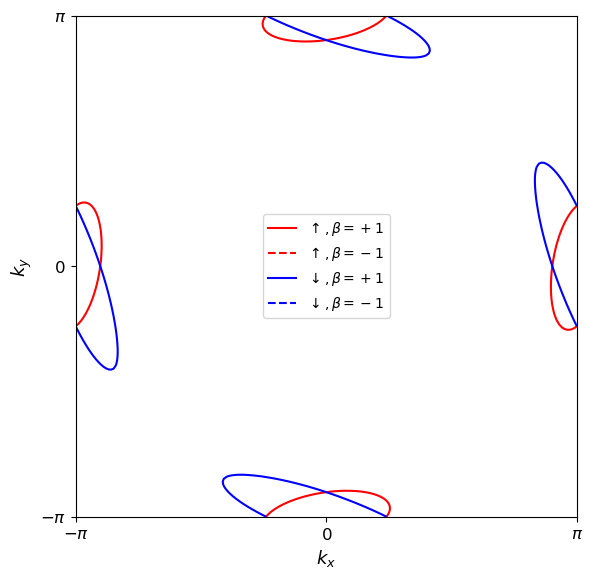

In [898]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

# === Your energy function should already be defined like this ===
# def energy_split(KX, KY, delta_up, delta_down, t, mu, epsilon):
#     ... return E_up_plus, E_up_minus, E_down_plus, E_down_minus

# === Function to compute area from contour lines ===
def compute_area_from_contour(contour_set):
    total_area = 0.0
    for path in contour_set.get_paths():
        verts = path.vertices
        x, y = verts[:, 0], verts[:, 1]
        # Shoelace formula for polygon area
        area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
        total_area += area
    return total_area


# === Grid and constants ===
plt.figure(figsize=(6, 6))
n_k2 = 200
kx = np.linspace(-np.pi, np.pi, n_k2)
ky = np.linspace(-np.pi, np.pi, n_k2)
KX, KY = np.meshgrid(kx, ky)



# === Unstrained Case ===
E_up_plus, E_up_minus, E_down_plus, E_down_minus = energy_split(KX, KY, N_A_U_array[-2], N_B_U_array[-2], 1.8, mu_U_array[-2], 0.1)

cont1 = plt.contour(KX, KY, E_up_plus, levels=[0], colors='red', linewidths=1.5)
cont2 = plt.contour(KX, KY, E_up_minus, levels=[0], colors='red', linestyles='dotted', linewidths=1.5)
cont3 = plt.contour(KX, KY, E_down_plus, levels=[0], colors='blue', linewidths=1.5)
cont4 = plt.contour(KX, KY, E_down_minus, levels=[0], colors='blue', linestyles='dotted', linewidths=1.5)

# Compute areas
area_up_unstrained = compute_area_from_contour(cont1) + compute_area_from_contour(cont2)
area_down_unstrained = compute_area_from_contour(cont3) + compute_area_from_contour(cont4)
magnetization_unstrained = area_up_unstrained - area_down_unstrained



# === Display results ===
print("=== Magnetization Summary ===")
print(f"Unstrained:   Area Up = {area_up_unstrained:.4f}, Area Down = {area_down_unstrained:.4f}, ΔArea = {magnetization_unstrained:.4f}")

# === Plot labels, grid, etc. ===



plt.xlabel("$k_x$",fontsize=13)
plt.ylabel("$k_y$",fontsize=13)
#plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

tick_positions = [-np.pi,0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(tick_positions, tick_labels, fontsize=12)
plt.yticks(tick_positions, tick_labels, fontsize=12)

# === Legend ===
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', label=r'$\uparrow, \beta=+1$'),
    Line2D([0], [0], color='red', linestyle='dashed', label=r'$\uparrow, \beta=-1$'),
    Line2D([0], [0], color='blue', label=r'$\downarrow, \beta=+1$'),
    Line2D([0], [0], color='blue', linestyle='dashed', label=r'$\downarrow, \beta=-1$')
]
plt.legend(handles=legend_elements, loc='center', fontsize=10)

plt.tight_layout()
plt.savefig('fermi surface at Us strain.png', bbox_inches='tight', pad_inches=0.1)
plt.show()


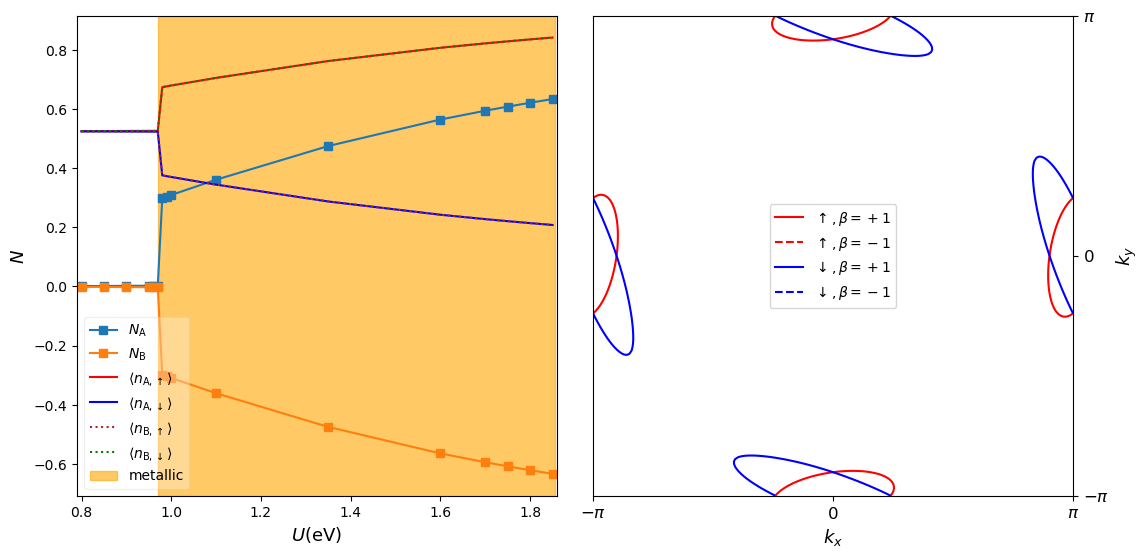

In [901]:
fig=plt.figure(figsize=(12, 6))

ax1=fig.add_axes([0.05,0.1,0.4,0.8])

ax1.plot(U_values, N_A_U_array, marker='s', label=r'$N_\text{A}$')
ax1.plot(U_values, N_B_U_array, marker='s', label=r'$N_\text{B}$')

ax1.plot(U_values, n_up_A_list, c='red', label=r'$\langle n_{\text{A},\uparrow} \rangle$')
ax1.plot(U_values, n_down_A_list, c='blue', label=r'$\langle n_{\text{A},\downarrow} \rangle$')

ax1.plot(U_values, n_up_B_list, c='brown', linestyle='dotted',label=r'$\langle n_{\text{B},\uparrow} \rangle$')
ax1.plot(U_values, n_down_B_list, c='green',linestyle='dotted',label=r'$\langle n_{\text{B},\downarrow} \rangle$')

# Mark where N_A, N_B vanish
if U_A_critical:
    ax1.axvspan(0.97,1.856 , color='orange', alpha=0.6,label='metallic')


# Mark where only one band remains
#if U_one_band:   
 #   ax1.axvspan(U_one_band, U_arr[-1]+0.1, color='blueviolet', alpha=0.6,label='spin polarized')
    



ax1.set_xlim(0.79,1.86)
#ax1.set_xticks(fontsize=12)
#ax1.set_yticks(fontsize=12)
ax1.set_xlabel(r'$U (\text{eV})$',fontsize=13)
ax1.set_ylabel(r'$N$',fontsize=13)
ax1.legend(loc='lower left',framealpha=0.3)


ax2=fig.add_axes([0.48,0.1,0.4,0.8])

n_k2 = 200
kx = np.linspace(-np.pi, np.pi, n_k2)
ky = np.linspace(-np.pi, np.pi, n_k2)
KX, KY = np.meshgrid(kx, ky)



# === Unstrained Case ===
E_up_plus, E_up_minus, E_down_plus, E_down_minus = energy_split(KX, KY, N_A_U_array[-2], N_B_U_array[-2], 1.8, mu_U_array[-2], 0.1)

cont1 = ax2.contour(KX, KY, E_up_plus, levels=[0], colors='red', linewidths=1.5)
cont2 = ax2.contour(KX, KY, E_up_minus, levels=[0], colors='red', linestyles='dotted', linewidths=1.5)
cont3 = ax2.contour(KX, KY, E_down_plus, levels=[0], colors='blue', linewidths=1.5)
cont4 = ax2.contour(KX, KY, E_down_minus, levels=[0], colors='blue', linestyles='dotted', linewidths=1.5)





ax2.set_xlabel("$k_x$",fontsize=13)
ax2.set_ylabel("$k_y$",fontsize=13)
#ax2.set_aspect('equal', adjustable='box')

tick_positions = [-np.pi,0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
ax2.set_xticks(tick_positions, tick_labels, fontsize=12)
ax2.set_yticks(tick_positions, tick_labels, fontsize=12)

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

# === Legend ===
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', label=r'$\uparrow, \beta=+1$'),
    Line2D([0], [0], color='red', linestyle='dashed', label=r'$\uparrow, \beta=-1$'),
    Line2D([0], [0], color='blue', label=r'$\downarrow, \beta=+1$'),
    Line2D([0], [0], color='blue', linestyle='dashed', label=r'$\downarrow, \beta=-1$')
]
ax2.legend(handles=legend_elements, loc='center', fontsize=10)


plt.savefig('fermi surface at Us and N and U.png', bbox_inches='tight', pad_inches=0.1)
plt.show()


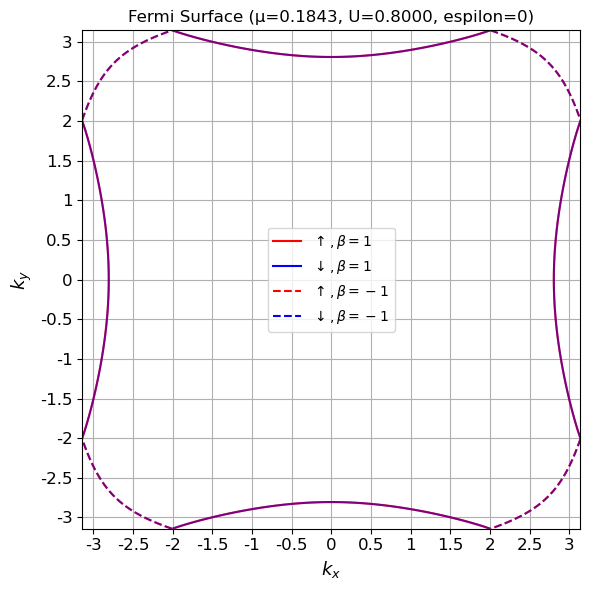

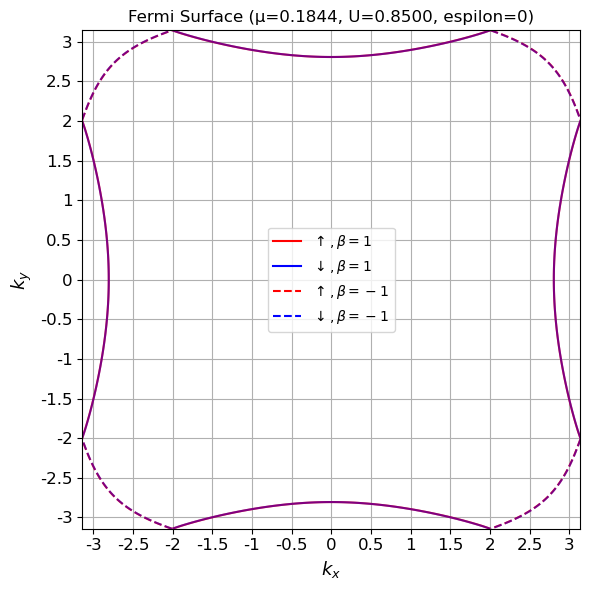

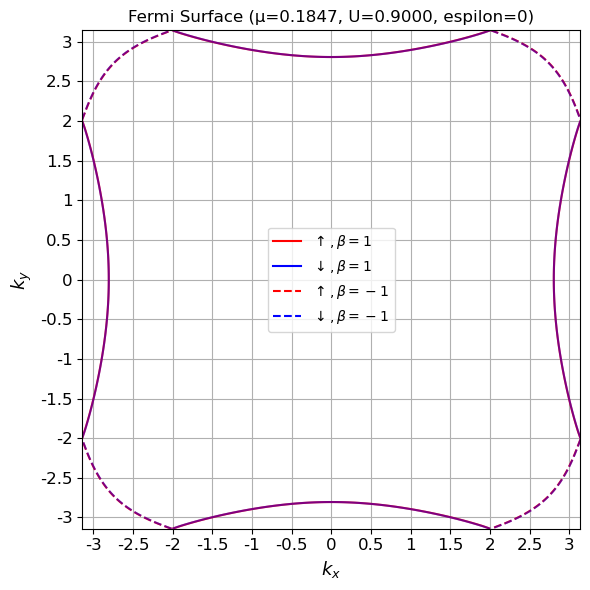

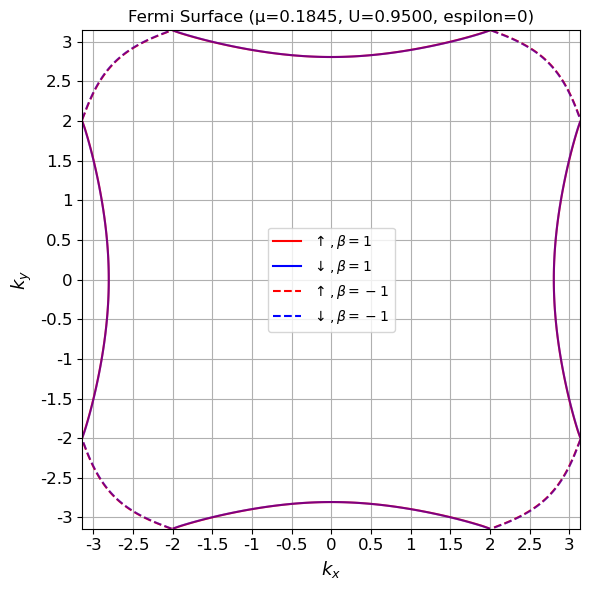

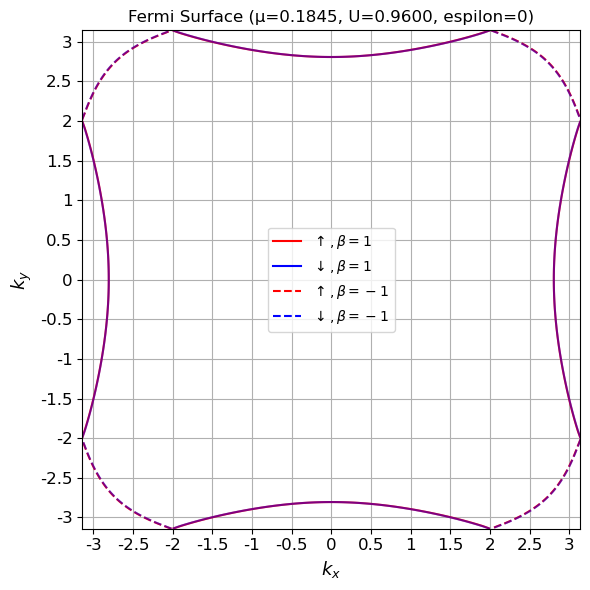

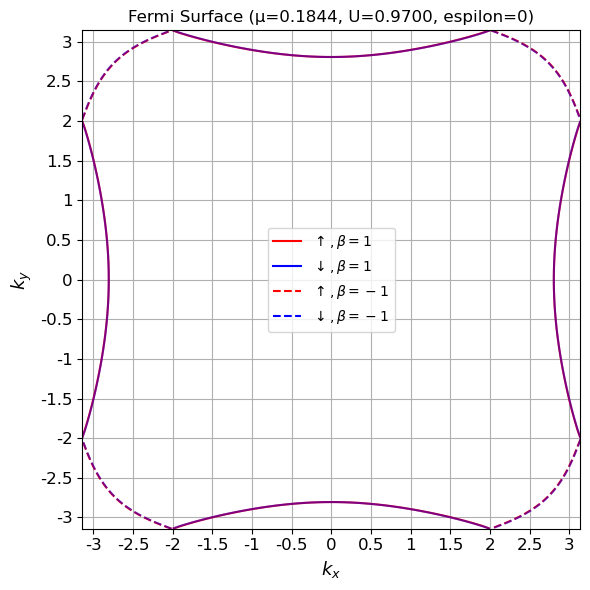

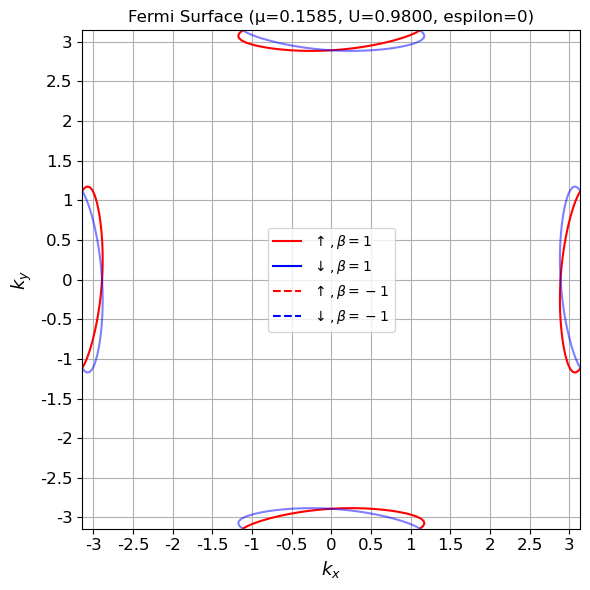

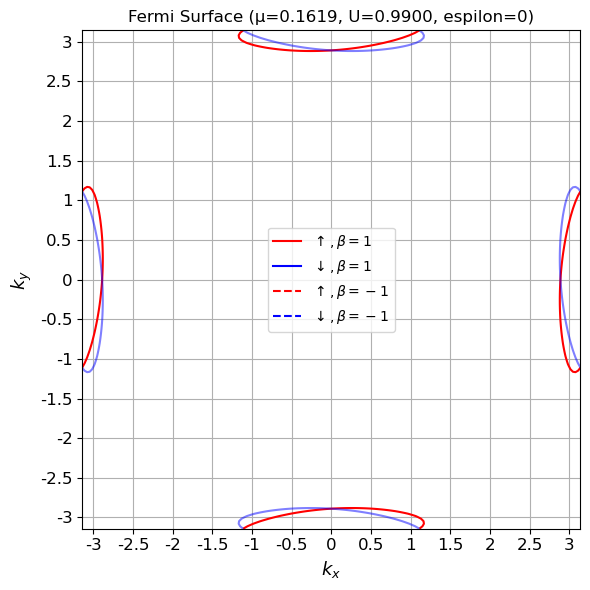

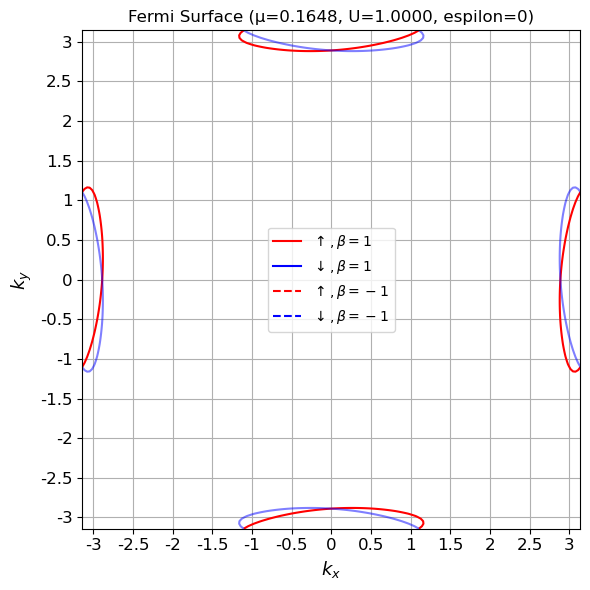

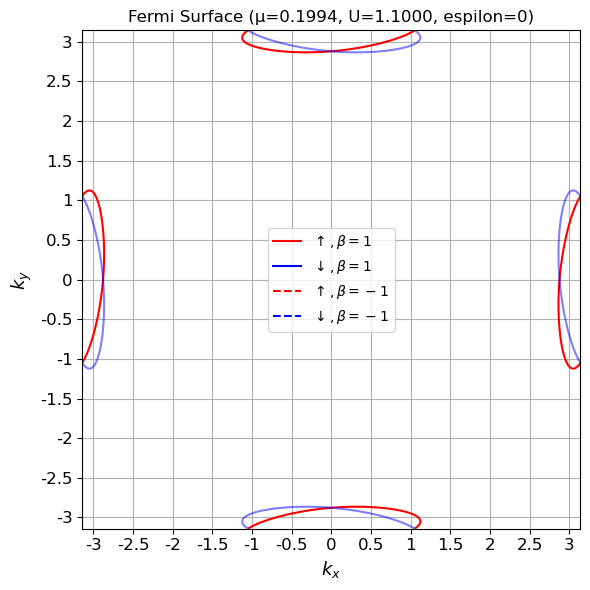

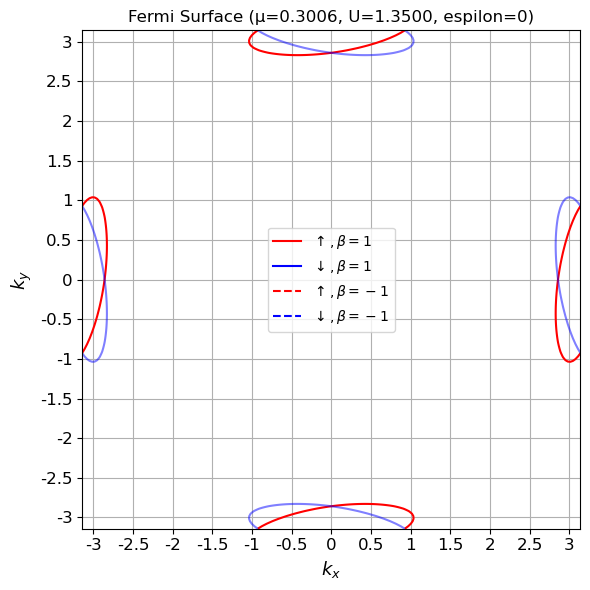

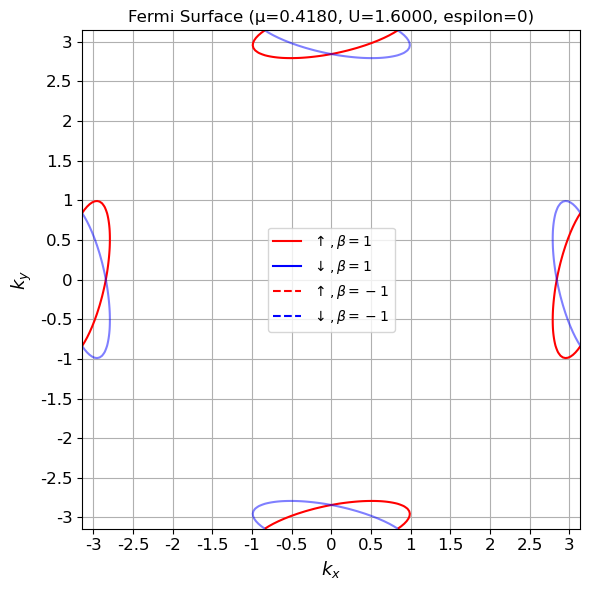

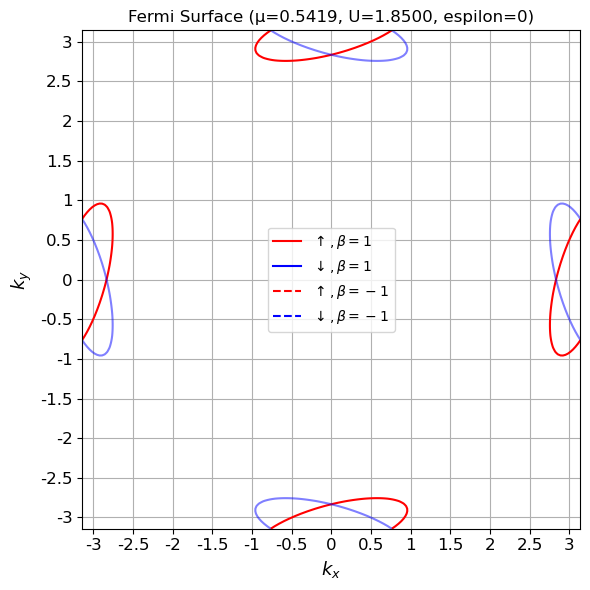

In [372]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# === Grid Setup ===
n_k2 = 200
kx = np.linspace(-np.pi, np.pi, n_k2)
ky = np.linspace(-np.pi, np.pi, n_k2)
KX, KY = np.meshgrid(kx, ky)


# === Loop over parameter sets ===
for i, (N_A_U, N_B_U, mu_U, U_val) in enumerate(zip(N_A_U_array, N_B_U_array, mu_U_array, U_arr)):

    # Compute energies
    E_up_plus, E_up_minus, E_down_plus, E_down_minus = energy_split(KX, KY, N_A_U, N_B_U, U_val, mu_U, eps)

    # === Plotting ===
    plt.figure(figsize=(6, 6))

    cont1 = plt.contour(KX, KY, E_up_plus, levels=[0], colors='red', linewidths=1.5)
    cont2 = plt.contour(KX, KY, E_up_minus, levels=[0], colors='red', linestyles='dashed', linewidths=1.5)
    cont3 = plt.contour(KX, KY, E_down_plus, levels=[0], colors='blue',linewidths=1.5,alpha=0.5)
    cont4 = plt.contour(KX, KY, E_down_minus, levels=[0], colors='blue', linestyles='dashed', linewidths=1.5,alpha=0.5)

    # === Axis ticks and grid ===
    tick_positions = [-3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]
    tick_labels = tick_positions
    plt.xticks(tick_positions, tick_labels, fontsize=12)
    plt.yticks(tick_positions, tick_labels, fontsize=12)
    plt.grid(True)

    # === Title and labels ===
    plt.title(f"Fermi Surface (μ={mu_U:.4f}, U={U_val:.4f}, espilon={eps})")
    plt.xlabel("$k_x$",fontsize=13)
    plt.ylabel("$k_y$",fontsize=13)
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

    # === Legend ===
    legend_elements = [
        Line2D([0], [0], color='red', linestyle='solid', label=r'$\uparrow,\beta=1$'),
        Line2D([0], [0], color='blue', linestyle='solid', label=r'$\downarrow,\beta=1$'),
        Line2D([0], [0], color='red', linestyle='dashed', label=r'$\uparrow,\beta=-1$'),
        Line2D([0], [0], color='blue', linestyle='dashed', label=r'$\downarrow,\beta=-1$')
    ]
    plt.legend(handles=legend_elements, loc='center', fontsize=10)

    # === Save and show ===
    plt.tight_layout()
    filename = f"1fermi_surface_mu{mu_U:.3f}_U{U_val:.2f}_i{i}.png"
    plt.savefig(filename)
    plt.show()
    plt.close()


In [506]:
from matplotlib import pyplot as plt

# Track whether Fermi surface exists
has_fermi_surface = []

for i in range(len(U_arr)):
    N_A = N_A_U_array[i]
    N_B = N_B_U_array[i]
    mu = mu_U_array[i]
    U = U_arr[i]

    # Calculate band energies
    E_up_plus, E_up_minus, E_down_plus, E_down_minus = energy_split(KX, KY, N_A, N_B, U, mu, 0)

    # Check if any band crosses E = 0
    surfaces_exist = False
    for E in [E_up_plus, E_up_minus, E_down_plus, E_down_minus]:
        if np.any(np.signbit(E) != np.signbit(E[0, 0])):  # crude check for sign change (E=0 crossing)
            surfaces_exist = True
            break

    has_fermi_surface.append(surfaces_exist)

# Determine critical U
try:
    insulating_idx = np.where(np.array(has_fermi_surface) == False)[0][0]
    U_c_insulator = U_arr[insulating_idx]
    print(f"🧊 System becomes insulating at U ≈ {U_c_insulator:.3f}")
except IndexError:
    print("⚠️ Fermi surface never disappears in the tested U range.")
    U_c_insulator = None


⚠️ Fermi surface never disappears in the tested U range.


In [329]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# === Parameters ===
eps = 0
x = 0
U_range = np.linspace(0.9, 1.5, 13)
n0_values = np.linspace(0.95, 1.05, 5)
U_critical_values = []

# === Tolerance for detecting insulating state ===
threshold = 1e-2  # if both |N_A| and |N_B| > threshold → insulator

# === Loop over densities ===
for n_0 in n0_values:
    print(f"\n📌 Density: n_0 = {n_0}")
    found = False
    for U in U_range:
        # === Initial guesses ===
        N_A, N_B = 0.2, -0.2
        try:
            mu_0 = brentq(density_difference, -10, 10, args=(N_A, N_B, U, n_0, T, eps), xtol=1e-5)
        except ValueError:
            continue

        mu = mu_0
        for _ in range(500):
            N_A_new = x * N_A + (1 - x) * order_param(N_A, N_B, U, mu, T, eps)
            N_B_new = x * N_B + (1 - x) * order_param2(N_A, N_B, U, mu, T, eps)
            try:
                mu = brentq(density_difference, -10, 10, args=(N_A_new, N_B_new, U, n_0, T, eps), xtol=1e-5)
            except ValueError:
                break

            n_A = n_e(N_A_new, N_B_new, U, mu, T, eps)
            n_B = n_e2(N_A_new, N_B_new, U, mu, T, eps)
            n_tot = (n_A + n_B) / 2

            # Convergence
            if (np.abs(N_A_new - N_A) + np.abs(N_B_new - N_B) + np.abs(n_tot - n_0)) < 1e-4:
                break

            N_A, N_B = N_A_new, N_B_new

        # === Check for insulating state ===
        if np.abs(N_A) > threshold and np.abs(N_B) > threshold:
            U_critical_values.append(U)
            print(f"✅ U_c ≈ {U:.3f} at n = {n_0}")
            found = True
            break

    if not found:
        U_critical_values.append(np.nan)
        print("❌ No transition found in U range")

# === Plotting ===
plt.figure(figsize=(7, 5))
plt.plot(n0_values, U_critical_values, 'o-', label=r'$U_c$ vs. $n_0$')
plt.xlabel('Density $n_0$')
plt.ylabel('Critical interaction $U_c$')
plt.title('Insulator Transition vs. Doping')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('U_c_vs_doping.png')
plt.show()



📌 Density: n_0 = 0.95
✅ U_c ≈ 1.050 at n = 0.95

📌 Density: n_0 = 0.975
✅ U_c ≈ 1.050 at n = 0.975

📌 Density: n_0 = 1.0
✅ U_c ≈ 1.050 at n = 1.0

📌 Density: n_0 = 1.025
✅ U_c ≈ 1.050 at n = 1.025

📌 Density: n_0 = 1.05


KeyboardInterrupt: 

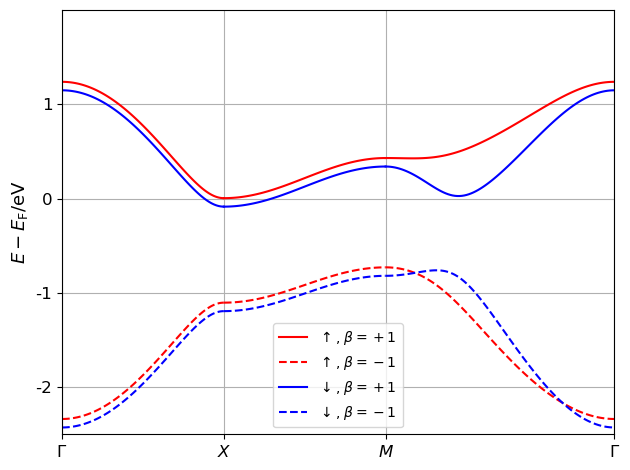

In [495]:
# High-symmetry points: Γ → X → M → Γ
G = np.array([0, 0])
X = np.array([np.pi, 0])
M = np.array([np.pi, np.pi])
path = [G, X, M, G]
labels = [r'$\Gamma$', r'$X$', r'$M$', r'$\Gamma$']
points_per_segment = 200

k1=np.linspace(0,np.pi,100)
k0=np.full_like(k1,0) 
k2=np.full_like(k1,np.pi)
k3=np.linspace(np.pi,0,100)

epsilo=0.1
i=-2


E1=energy_split(k1, k0, N_A_U_array[i], N_B_U_array[i], U_arr[i], mu_U_array[i], epsilo)
E2=energy_split(k2, k1, N_A_U_array[i], N_B_U_array[i], U_arr[i], mu_U_array[i], epsilo)
E3=energy_split(k3, k3, N_A_U_array[i], N_B_U_array[i], U_arr[i], mu_U_array[i], epsilo)


#plotting all bands for each path between high symmetry points

plt.plot(np.linspace(0,1,100), E1[0], label=r'$\uparrow$, $\beta=+1$', color='red')
plt.plot(np.linspace(0,1,100), E1[1], '--', label=r'$\uparrow$, $\beta=-1$ ', color='red')
plt.plot(np.linspace(0,1,100), E1[2],label=r'$\downarrow$, $\beta=+1$', color='blue')
plt.plot(np.linspace(0,1,100), E1[3],'--', label=r'$\downarrow$, $\beta=-1$', color='blue')

plt.plot(np.linspace(1,2,100), E2[0], color='red')
plt.plot(np.linspace(1,2,100), E2[1], '--', color='red')
plt.plot(np.linspace(1,2,100), E2[2], color='blue')
plt.plot(np.linspace(1,2,100), E2[3],'--',  color='blue')

plt.plot(np.linspace(2,2+np.sqrt(2),100), E3[0], color='red')
plt.plot(np.linspace(2,2+np.sqrt(2),100), E3[1], '--', color='red')
plt.plot(np.linspace(2,2+np.sqrt(2),100), E3[2], color='blue')
plt.plot(np.linspace(2,2+np.sqrt(2),100), E3[3],'--', color='blue')

# Set custom x-axis ticks and labels
tick_positions = [0,1,2,2+np.sqrt(2)]
tick_labels = labels
plt.xticks(tick_positions, tick_labels, fontsize=12)

y_tick_positions=[-3,-2,-1,0,1]
y_tick_labels=[-3,-2,-1,0,1]
plt.yticks(y_tick_positions,y_tick_labels, fontsize=12)



#plt.xlabel("k-path")
plt.ylabel(r"$E-E_\text{F}/\text{eV}$",fontsize=13)
#plt.title(f"Band Dispersion along High-Symmetry Path for $\epsilon$={epsilo}")
plt.xlim(0,2+np.sqrt(2))
plt.ylim(-2.5,2)
plt.grid(True)
plt.legend(loc='lower center')
plt.tight_layout()
plt.savefig('dispersion along path doped,strained.png')
plt.show()


# NB(U)

In [875]:
#k grid
n_k = 150
kx = np.linspace(-np.pi, np.pi, n_k)
ky = np.linspace(-np.pi, np.pi, n_k)
KX, KY = np.meshgrid(kx, ky)

# Initial values
eps=0
x = 0
U_arr2 = np.concatenate((np.linspace(0.8,0.98,4),np.linspace(0.99,1.1,5),np.linspace(1.2,1.5,7))) 


#starting mu
n_0=0.95
N_0=0
U_0=1



#self consistent
N_A_U2=[]
N_B_U2=[]
n_up_A2_list=[]
n_down_A2_list=[]
n_up_B2_list=[]
n_down_B2_list=[]
mu_U2=[]

for U in U_arr2:
    try:
        mu_0 = brentq(density_difference_total, -10, 10, args=(N_0,-N_0 ,U, n_0, T,eps), xtol=1e-5)
    except ValueError:
        print("mu not found")
    mu_current = mu_0
    N_A_current = 0.4
    N_B_current = -0.4
    for i in range(200):
        # Compute updated order parameters
        N_A_new = x * N_A_current + (1 - x) * order_param(N_A_current, N_B_current, U, mu_current, T,eps)
        N_B_new = x * N_B_current + (1 - x) * order_param2(N_A_current, N_B_current, U, mu_current, T,eps)

        # Update mu to maintain total density ~1
        try:
            mu_new = brentq(density_difference_total, -10, 10, args=(N_A_new, N_B_new, U, n_0, T,eps), xtol=1e-5)
        except ValueError:
            print("mu not found")
            break

        # Check total density
        n_new_A = n_e(N_A_new, N_B_new, U, mu_new, T, eps)
        n_new_B = n_e2(N_A_new, N_B_new, U, mu_new, T, eps)
        n_total = (n_new_A + n_new_B) / 2

        n_up_A=n_up(N_A_new,N_B_new,U,mu_new,T,eps)
        n_down_A=n_down(N_A_new,N_B_new,U,mu_new,T,eps)

        n_up_B=n_up2(N_A_new,N_B_new,U,mu_new,T,eps)
        n_down_B=n_down2(N_A_new,N_B_new,U,mu_new,T,eps)

        #print(f"step {i+1}: N_A = {N_A_new:.3f}, N_B = {N_B_new:.3f}, μ = {mu_new:.3f}, n = {n_total:.3f}")

        # Check convergence
        if (np.abs(N_A_new - N_A_current) +
            np.abs(N_B_new - N_B_current) +
            np.abs(n_total - n_0)) < 1e-4:
            print(f"✅ Converged in {i+1} steps.")
            break
        elif i+1==1000:
            print(f"Did not converge in {i+1} steps.")

        # Update for next step
        N_A_current = N_A_new
        N_B_current = N_B_new
        mu_current = mu_new
    N_A_U2.append(N_A_current)
    N_B_U2.append(N_B_current)
    n_up_A2_list.append(n_up_A)
    n_down_A2_list.append(n_down_A)
    n_up_B2_list.append(n_up_B)
    n_down_B2_list.append(n_down_B)
    mu_U2.append(mu_current)


#print("\n📌 Final self-consistent results:")
#print(f"N_A = {N_A_current:.6f}")
#print(f"N_B = {N_B_current:.6f}")
#print(f"μ   = {mu_current:.6f}")
#print(f"n   = {(n_e(N_A_current, N_B_current, U, mu_current, T,eps) + n_e2(N_A_current, N_B_current, U, mu_current, T,eps)) / 2:.6f}")
#print(f"N_A + N_B = {N_A_current + N_B_current:.6e}")



print(N_A_U2,N_B_U2,mu_U2)
N_A_U_array2=np.array(N_A_U2)
N_B_U_array2=np.array(N_B_U2)
mu_U_array2=np.array(mu_U2)

# Find critical temperature where W becomes nearly zero
epsilon = 1e-1
U_values2 = U_arr2


#Find first index where W < epsilon
try:
    idx = np.where(np.abs(N_A_U_array2) > epsilon)[0][0]
    U_A_critical2 = U_values2[idx-1]
    print(f"Estimated critical interaction U_c where N_A ≈ 0: {U_A_critical2:.2f} meV")
except IndexError:
    print("N_A does not drop below threshold within U range.")
    U_A_critical2 = None

try:
    idx = np.where(np.abs(N_B_U_array2) > epsilon)[0][0]
    U_B_critical2 = U_values2[idx-1]
    print(f"Estimated critical interaction U_c where N_B ≈ 0: {U_B_critical2:.2f} meV")
except IndexError:
    print("N_B does not drop below threshold within U range.")
    U_B_critical2 = None

✅ Converged in 27 steps.
✅ Converged in 33 steps.
✅ Converged in 46 steps.
✅ Converged in 77 steps.
✅ Converged in 88 steps.
✅ Converged in 108 steps.
✅ Converged in 16 steps.
✅ Converged in 16 steps.
✅ Converged in 15 steps.
✅ Converged in 13 steps.
✅ Converged in 12 steps.
✅ Converged in 11 steps.
✅ Converged in 9 steps.
✅ Converged in 8 steps.
✅ Converged in 10 steps.
✅ Converged in 11 steps.
[0.0004284085889879898, 0.0005710539132566564, 0.0007192253097922233, 0.0007576111176269908, 0.0010470209765963416, 0.004249006696308266, 0.3249111329086681, 0.34042585887387866, 0.35475070647987095, 0.4052232495251314, 0.4283902679216169, 0.45088905388477873, 0.47219518769450713, 0.4919723505553035, 0.5112046928235369, 0.5294046491394809] [-0.0004284085615251532, -0.0005710531568759974, -0.0006288403801578225, -0.0010332554675552283, -0.0007651567902080353, -0.004515795548571828, -0.3249111329120373, -0.34042585888615345, -0.35475070597743846, -0.40522324952371563, -0.42839026792142704, -0.450

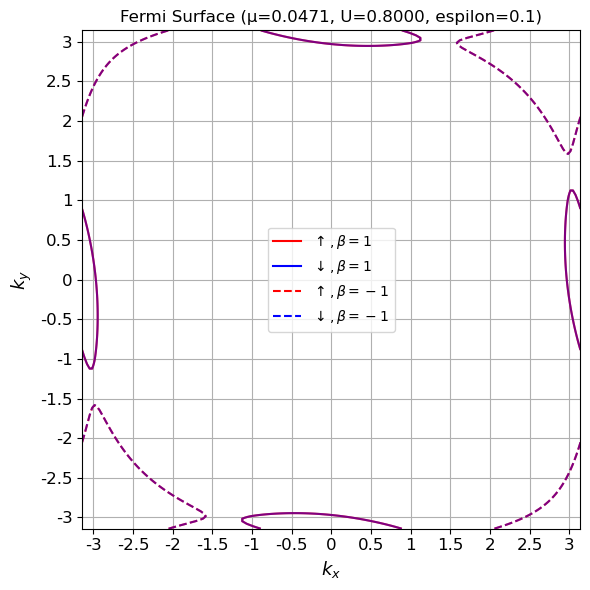

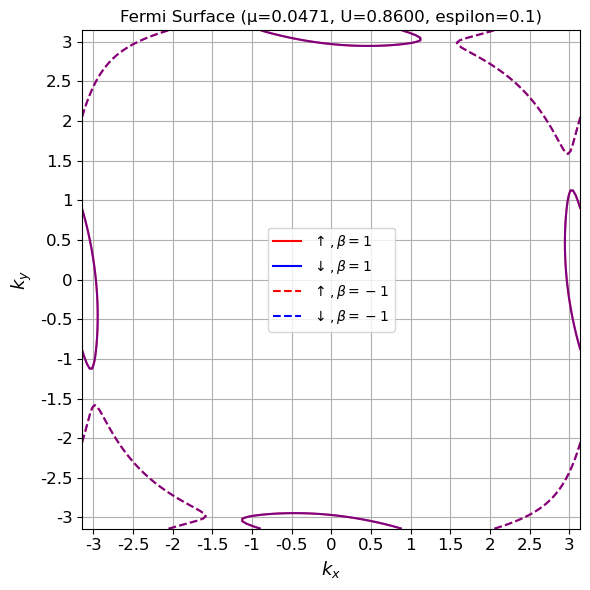

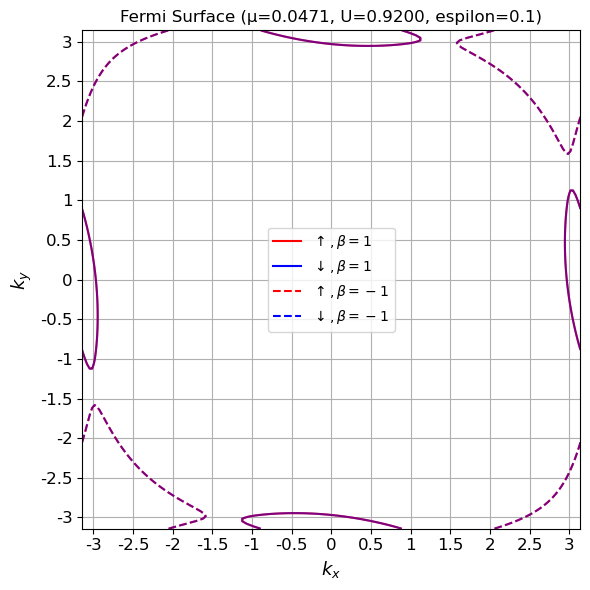

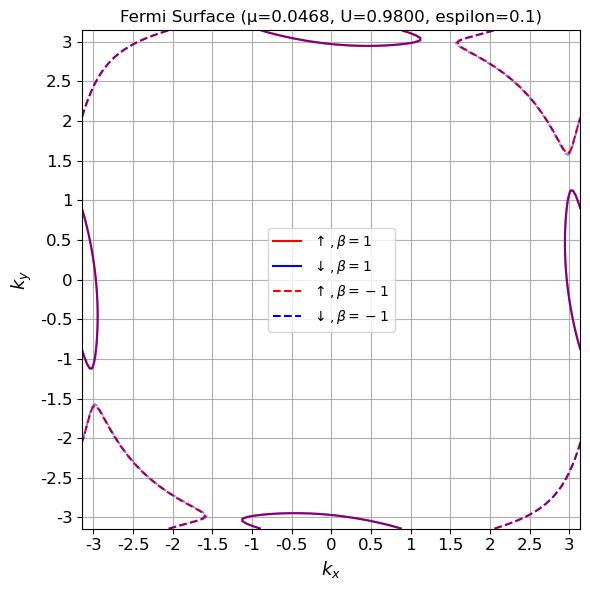

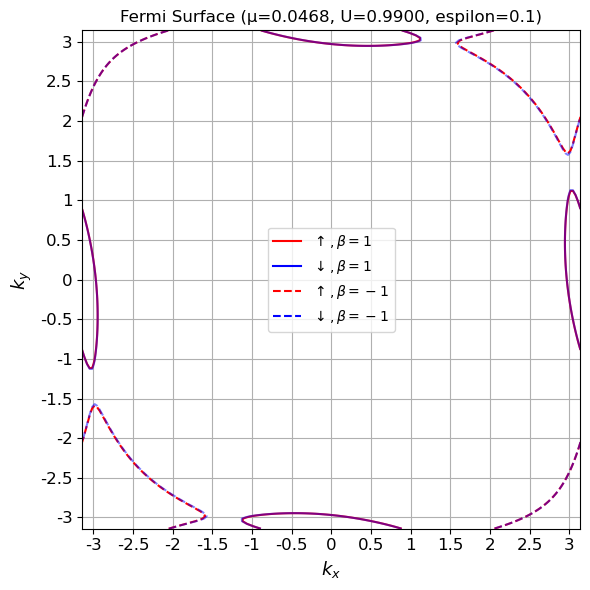

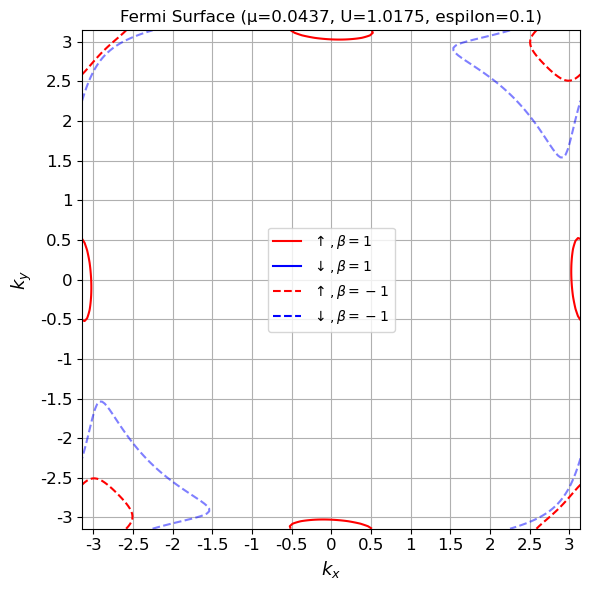

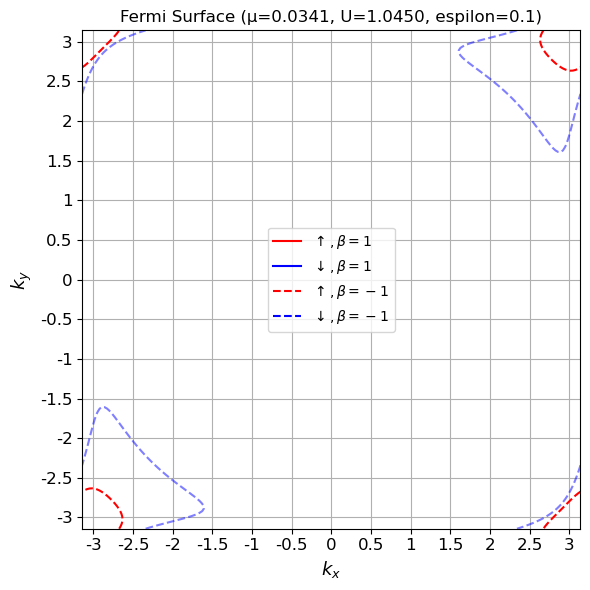

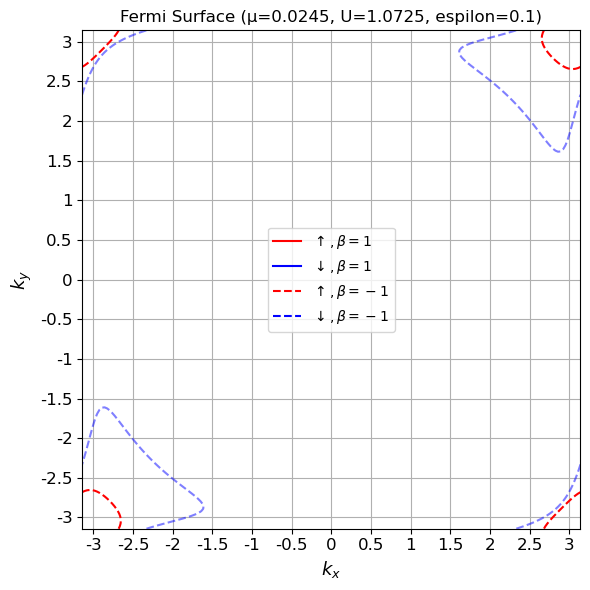

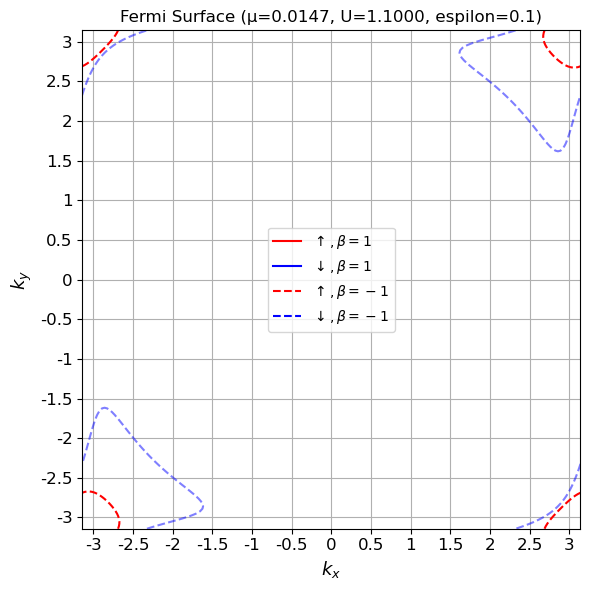

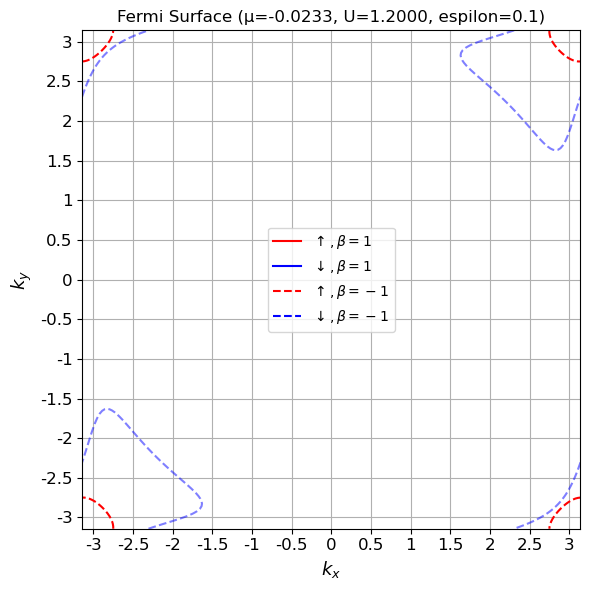

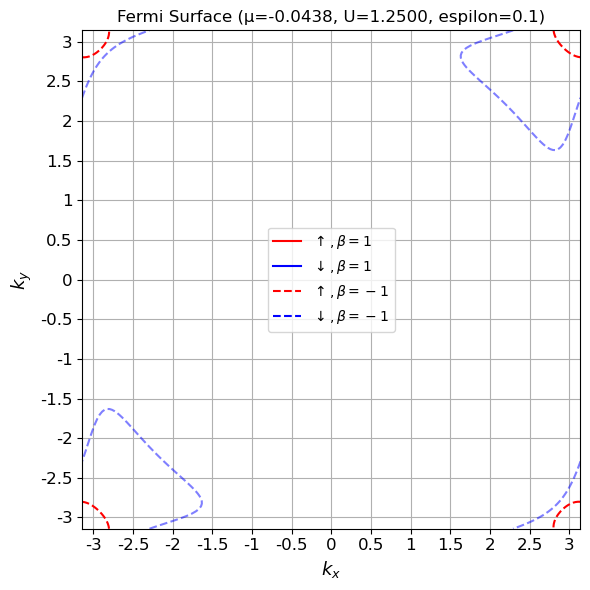

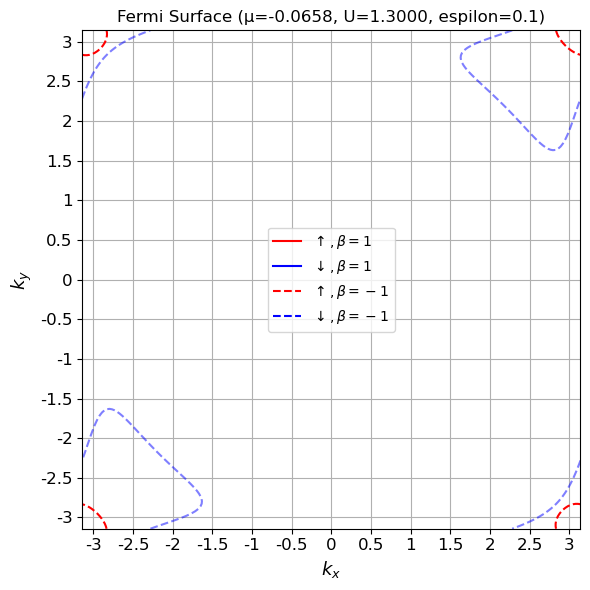

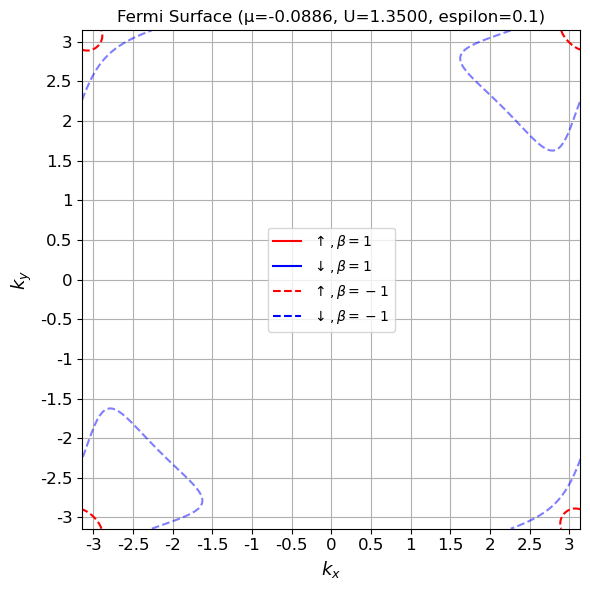

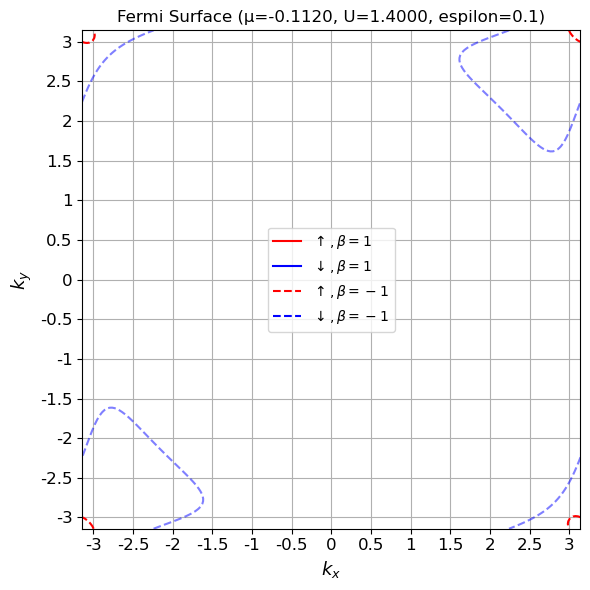

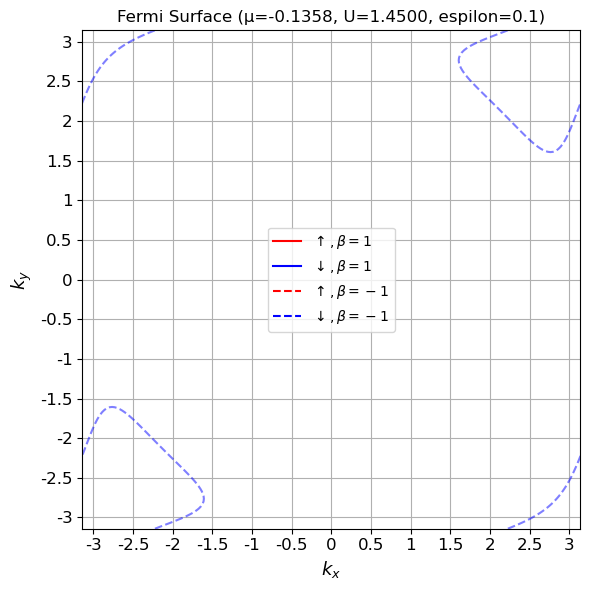

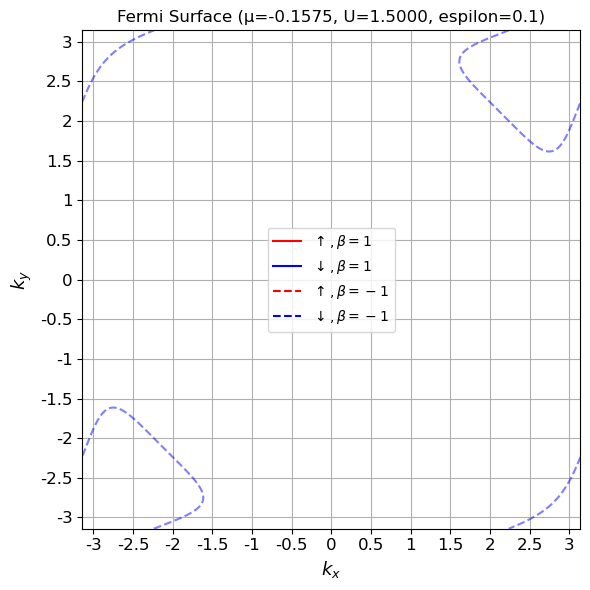

In [539]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# === Grid Setup ===
n_k2 = 200
kx = np.linspace(-np.pi, np.pi, n_k2)
ky = np.linspace(-np.pi, np.pi, n_k2)
KX, KY = np.meshgrid(kx, ky)


# === Loop over parameter sets ===
for i, (N_A_U, N_B_U, mu_U, U_val) in enumerate(zip(N_A_U_array2, N_B_U_array2, mu_U_array2, U_arr2)):

    # Compute energies
    E_up_plus, E_up_minus, E_down_plus, E_down_minus = energy_split(KX, KY, N_A_U, N_B_U, U_val, mu_U, eps)

    # === Plotting ===
    plt.figure(figsize=(6, 6))

    cont1 = plt.contour(KX, KY, E_up_plus, levels=[0], colors='red', linewidths=1.5)
    cont2 = plt.contour(KX, KY, E_up_minus, levels=[0], colors='red', linestyles='dashed', linewidths=1.5)
    cont3 = plt.contour(KX, KY, E_down_plus, levels=[0], colors='blue',linewidths=1.5,alpha=0.5)
    cont4 = plt.contour(KX, KY, E_down_minus, levels=[0], colors='blue', linestyles='dashed', linewidths=1.5,alpha=0.5)

    # === Axis ticks and grid ===
    tick_positions = [-3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]
    tick_labels = tick_positions
    plt.xticks(tick_positions, tick_labels, fontsize=12)
    plt.yticks(tick_positions, tick_labels, fontsize=12)
    plt.grid(True)

    # === Title and labels ===
    plt.title(f"Fermi Surface (μ={mu_U:.4f}, U={U_val:.4f}, espilon={eps})")
    plt.xlabel("$k_x$",fontsize=13)
    plt.ylabel("$k_y$",fontsize=13)
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

    # === Legend ===
    legend_elements = [
        Line2D([0], [0], color='red', linestyle='solid', label=r'$\uparrow,\beta=1$'),
        Line2D([0], [0], color='blue', linestyle='solid', label=r'$\downarrow,\beta=1$'),
        Line2D([0], [0], color='red', linestyle='dashed', label=r'$\uparrow,\beta=-1$'),
        Line2D([0], [0], color='blue', linestyle='dashed', label=r'$\downarrow,\beta=-1$')
    ]
    plt.legend(handles=legend_elements, loc='center', fontsize=10)

    # === Save and show ===
    plt.tight_layout()
    filename = f"1fermi_surface_mu{mu_U:.3f}_U{U_val:.2f}_i{i}.png"
    plt.savefig(filename)
    plt.show()
    plt.close()


In [876]:
# Track how many bands cross the Fermi level
bands_crossing_count2 = []
band_labels = ['E_up_plus', 'E_up_minus', 'E_down_plus', 'E_down_minus']
bands_crossing_names2 = []

for i in range(len(U_arr2)):
    N_A = N_A_U_array2[i]
    N_B = N_B_U_array2[i]
    mu = mu_U_array2[i]
    U = U_arr2[i]

    # Calculate band energies
    E_up_plus, E_up_minus, E_down_plus, E_down_minus = energy_split(KX, KY, N_A, N_B, U, mu, eps)

    energies = [E_up_plus, E_up_minus, E_down_plus, E_down_minus]
    crossing = []

    for E, label in zip(energies, band_labels):
        if np.any(np.signbit(E) != np.signbit(E[0, 0])):  # crude E = 0 crossing check
            crossing.append(label)

    bands_crossing_count2.append(len(crossing))
    bands_crossing_names2.append(crossing)

# Find first U where only **one band** crosses Fermi level
try:
    idx_one_band2 = np.where(np.array(bands_crossing_count2) == 1)[0]
    if len(idx_one_band2) > 0:
        idx_one_band2 = idx_one_band2[0]
        U_one_band2 = U_arr[idx_one_band2]
        band_surviving2 = bands_crossing_names2[idx_one_band2][0]
        print(f"🎯 Only one band ('{band_surviving2}') remains at U ≈ {U_one_band2:.3f}")
    else:
        raise IndexError
except IndexError:
    print("⚠️ No U found where only one band crosses the Fermi level.")
    U_one_band2 = None
    band_surviving2 = None



plt.plot(U_values2, N_A_U_array2, marker='s', label=r'$N_A$')
plt.plot(U_values2, N_B_U_array2, marker='s', label=r'$N_B$')

# Mark where the system becomes fully insulating (no FS)
#if U_c_insulator:

plt.axvspan(0.99,1.45 , color='orange', alpha=0.6,label='metallic')
    

# Mark where N_A, N_B vanish
#if U_A_critical2:
 
    #plt.axvspan(U_one_band2,U_arr2[-1]+0.01 , color='orange', alpha=0.6,label='metallic')


# Mark where only one band remains
if U_one_band2:  
    plt.axvspan(1.45, U_arr2[-1]+0.01, color='blueviolet', alpha=0.6,label='spin polarized')
    



plt.xlim(0.7905,1.505)

plt.xlabel(r'$U (\text{eV})$',fontsize=13)
plt.ylabel(r'$N$',fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.savefig('NA,NB and U 2.png', bbox_inches='tight', pad_inches=0.1)
plt.show()


TypeError: 'float' object is not callable

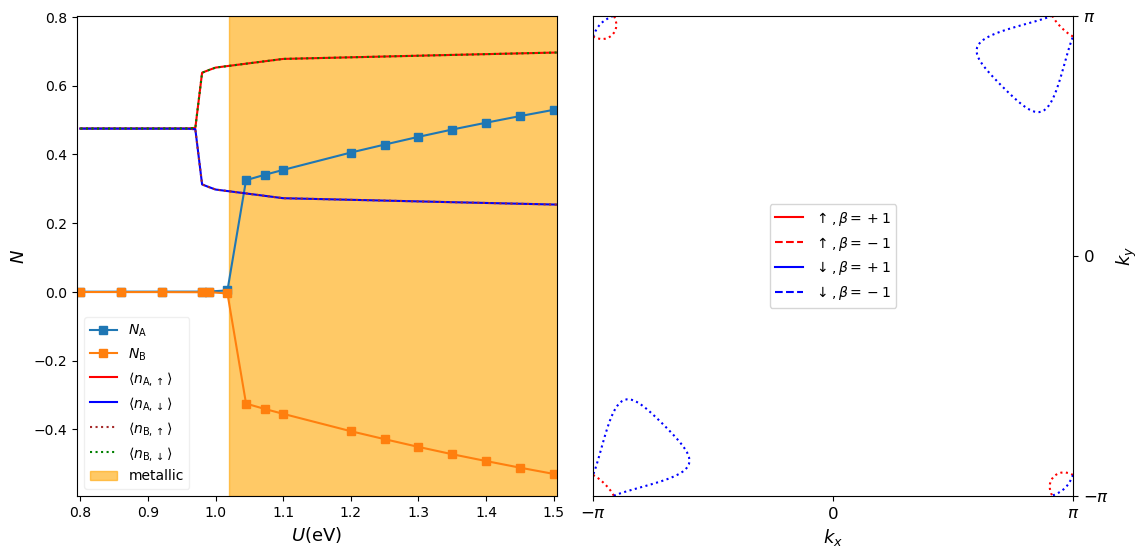

In [887]:
fig=plt.figure(figsize=(12, 6))

ax1=fig.add_axes([0.05,0.1,0.4,0.8])

ax1.plot(U_values2, N_A_U_array2, marker='s', label=r'$N_\text{A}$')
ax1.plot(U_values2, N_B_U_array2, marker='s', label=r'$N_\text{B}$')

ax1.plot(U_values, n_up_A2_list, c='red', label=r'$\langle n_{\text{A},\uparrow} \rangle$')
ax1.plot(U_values, n_down_A2_list, c='blue', label=r'$\langle n_{\text{A},\downarrow} \rangle$')

ax1.plot(U_values, n_up_B2_list, c='brown', linestyle='dotted',label=r'$\langle n_{\text{B},\uparrow} \rangle$')
ax1.plot(U_values, n_down_B2_list, c='green',linestyle='dotted',label=r'$\langle n_{\text{B},\downarrow} \rangle$')

# Mark where N_A, N_B vanish
#if U_A_critical2:
 #ax1.axvspan(U_A_critical2,U_arr2[-1]+0.1 , color='orange', alpha=0.6,label='metallic')
plt.axvspan(1.02,1.51 , color='orange', alpha=0.6,label='metallic')
#plt.axvspan(1.45, U_arr2[-1]+0.01, color='blueviolet', alpha=0.6,label='spin polarized')
# Mark where only one band remains
#if U_one_band2:   
 #   ax1.axvspan(1.45, U_arr2[-1]+0.1, color='blueviolet', alpha=0.6,label='spin polarized')
    



ax1.set_xlim(0.795,1.505)
#ax1.set_xticks(fontsize=12)
#ax1.set_yticks(fontsize=12)
ax1.set_xlabel(r'$U (\text{eV})$',fontsize=13)
ax1.set_ylabel(r'$N$',fontsize=13)
ax1.legend(loc='lower left',framealpha=0.3)


ax2=fig.add_axes([0.48,0.1,0.4,0.8])

n_k2 = 200
kx = np.linspace(-np.pi, np.pi, n_k2)
ky = np.linspace(-np.pi, np.pi, n_k2)
KX, KY = np.meshgrid(kx, ky)



# === Unstrained Case ===
E_up_plus, E_up_minus, E_down_plus, E_down_minus = energy_split(KX, KY, N_A_U_array2[-2], N_B_U_array2[-2], 1.45, mu_U_array2[-2], 0.1)

cont1 = ax2.contour(KX, KY, E_up_plus, levels=[0], colors='red', linewidths=1.5)
cont2 = ax2.contour(KX, KY, E_up_minus, levels=[0], colors='red', linestyles='dotted', linewidths=1.5)
cont3 = ax2.contour(KX, KY, E_down_plus, levels=[0], colors='blue', linewidths=1.5)
cont4 = ax2.contour(KX, KY, E_down_minus, levels=[0], colors='blue', linestyles='dotted', linewidths=1.5)





ax2.set_xlabel("$k_x$",fontsize=13)
ax2.set_ylabel("$k_y$",fontsize=13)
#ax2.set_aspect('equal', adjustable='box')

tick_positions = [-np.pi,0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
ax2.set_xticks(tick_positions, tick_labels, fontsize=12)
ax2.set_yticks(tick_positions, tick_labels, fontsize=12)

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

# === Legend ===
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', label=r'$\uparrow, \beta=+1$'),
    Line2D([0], [0], color='red', linestyle='dashed', label=r'$\uparrow, \beta=-1$'),
    Line2D([0], [0], color='blue', label=r'$\downarrow, \beta=+1$'),
    Line2D([0], [0], color='blue', linestyle='dashed', label=r'$\downarrow, \beta=-1$')
]
ax2.legend(handles=legend_elements, loc='center', fontsize=10)


plt.savefig('fermi surface at Us and N and U 2.png', bbox_inches='tight', pad_inches=0.1)
plt.show()


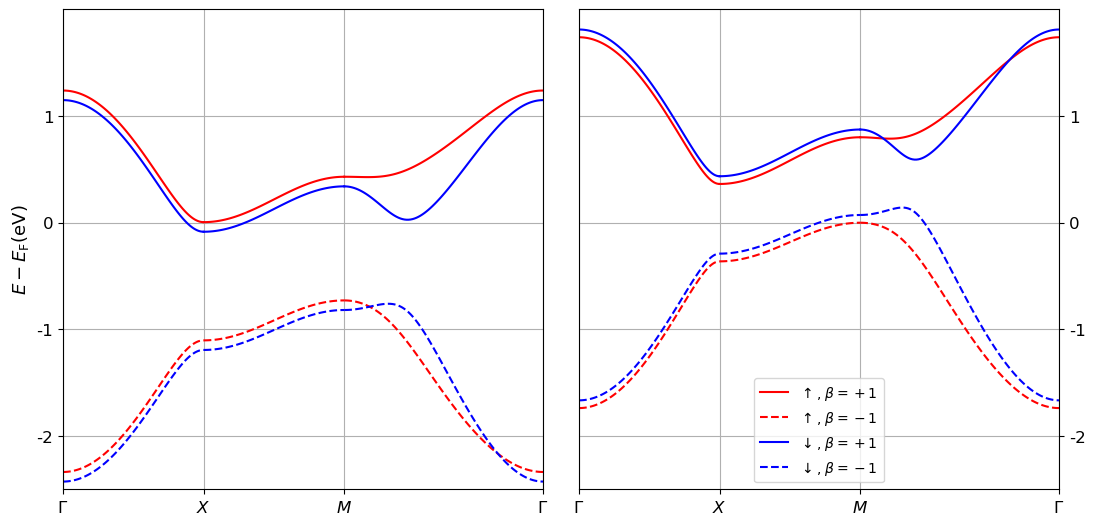

In [510]:
# High-symmetry points: Γ → X → M → Γ
G = np.array([0, 0])
X = np.array([np.pi, 0])
M = np.array([np.pi, np.pi])
path = [G, X, M, G]
labels = [r'$\Gamma$', r'$X$', r'$M$', r'$\Gamma$']
points_per_segment = 200

k1=np.linspace(0,np.pi,100)
k0=np.full_like(k1,0) 
k2=np.full_like(k1,np.pi)
k3=np.linspace(np.pi,0,100)

epsilo=0.1
i=-2

fig=plt.figure(figsize=(12, 6))

ax1=fig.add_axes([0.05,0.1,0.4,0.8])

E1=energy_split(k1, k0, N_A_U_array[i], N_B_U_array[i], U_arr[i], mu_U_array[i], epsilo)
E2=energy_split(k2, k1, N_A_U_array[i], N_B_U_array[i], U_arr[i], mu_U_array[i], epsilo)
E3=energy_split(k3, k3, N_A_U_array[i], N_B_U_array[i], U_arr[i], mu_U_array[i], epsilo)


#plotting all bands for each path between high symmetry points

ax1.plot(np.linspace(0,1,100), E1[0], label=r'$\uparrow$, $\beta=+1$', color='red')
ax1.plot(np.linspace(0,1,100), E1[1], '--', label=r'$\uparrow$, $\beta=-1$ ', color='red')
ax1.plot(np.linspace(0,1,100), E1[2],label=r'$\downarrow$, $\beta=+1$', color='blue')
ax1.plot(np.linspace(0,1,100), E1[3],'--', label=r'$\downarrow$, $\beta=-1$', color='blue')

ax1.plot(np.linspace(1,2,100), E2[0], color='red')
ax1.plot(np.linspace(1,2,100), E2[1], '--', color='red')
ax1.plot(np.linspace(1,2,100), E2[2], color='blue')
ax1.plot(np.linspace(1,2,100), E2[3],'--',  color='blue')

ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[0], color='red')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[1], '--', color='red')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[2], color='blue')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[3],'--', color='blue')

# Set custom x-axis ticks and labels
tick_positions = [0,1,2,2+np.sqrt(2)]
tick_labels = labels
ax1.set_xticks(tick_positions, tick_labels, fontsize=12)

y_tick_positions=[-2,-1,0,1]
y_tick_labels=[-2,-1,0,1]
ax1.set_yticks(y_tick_positions,y_tick_labels, fontsize=12)

ax1.set_ylabel(r"$E-E_\text{F}(\text{eV})$",fontsize=13)
#plt.title(f"Band Dispersion along High-Symmetry Path for $\epsilon$={epsilo}")
ax1.set_xlim(0,2+np.sqrt(2))
ax1.set_ylim(-2.5,2)
ax1.grid(True)
#ax1.legend(loc='lower center')

ax2=fig.add_axes([0.48,0.1,0.4,0.8])

E12=energy_split(k1, k0, N_A_U_array2[i], N_B_U_array2[i], U_arr2[i], mu_U_array2[i], epsilo)
E22=energy_split(k2, k1, N_A_U_array2[i], N_B_U_array2[i], U_arr2[i], mu_U_array2[i], epsilo)
E32=energy_split(k3, k3, N_A_U_array2[i], N_B_U_array2[i], U_arr2[i], mu_U_array2[i], epsilo)


#plotting all bands for each path between high symmetry points

ax2.plot(np.linspace(0,1,100), E12[0], label=r'$\uparrow$, $\beta=+1$', color='red')
ax2.plot(np.linspace(0,1,100), E12[1], '--', label=r'$\uparrow$, $\beta=-1$ ', color='red')
ax2.plot(np.linspace(0,1,100), E12[2],label=r'$\downarrow$, $\beta=+1$', color='blue')
ax2.plot(np.linspace(0,1,100), E12[3],'--', label=r'$\downarrow$, $\beta=-1$', color='blue')

ax2.plot(np.linspace(1,2,100), E22[0], color='red')
ax2.plot(np.linspace(1,2,100), E22[1], '--', color='red')
ax2.plot(np.linspace(1,2,100), E22[2], color='blue')
ax2.plot(np.linspace(1,2,100), E22[3],'--',  color='blue')

ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[0], color='red')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[1], '--', color='red')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[2], color='blue')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[3],'--', color='blue')

# Set custom x-axis ticks and labels
tick_positions = [0,1,2,2+np.sqrt(2)]
tick_labels = labels
ax2.set_xticks(tick_positions, tick_labels, fontsize=12)

y_tick_positions=[-2,-1,0,1]
y_tick_labels=[-2,-1,0,1]
ax2.set_yticks(y_tick_positions,y_tick_labels, fontsize=12)
ax2.yaxis.tick_right()


#plt.xlabel("k-path")
#ax2.set_ylabel(r"$E-E_\text{F}(\text{eV})$",fontsize=13)
#plt.title(f"Band Dispersion along High-Symmetry Path for $\epsilon$={epsilo}")
ax2.set_xlim(0,2+np.sqrt(2))
ax2.set_ylim(-2.5,2)
ax2.grid(True)
ax2.legend(loc='lower center')


plt.savefig('dispersion along path both dopings,strained.png', bbox_inches='tight', pad_inches=0.1)
plt.show()


# M and n

In [855]:
n_k = 150
kx = np.linspace(-np.pi, np.pi, n_k)
ky = np.linspace(-np.pi, np.pi, n_k)
KX, KY = np.meshgrid(kx, ky)

# Initial values
eps=0.1
x = 0
n_arr = np.linspace(0.5,1.5,21) 


#starting mu
n_0=1
N_0=0
U=1.8



#self consistent
N_A_n=[]
N_B_n=[]
mu_n=[]

for n in n_arr:
    try:
        mu_0 = brentq(density_difference_total, -10, 10, args=(N_0,-N_0 ,U, n, T,eps), xtol=1e-5)
    except ValueError:
        print("mu not found")
    mu_current = mu_0
    N_A_current = 0.4
    N_B_current = -0.4
    for i in range(200):
        # Compute updated order parameters
        N_A_new = x * N_A_current + (1 - x) * order_param(N_A_current, N_B_current, U, mu_current, T,eps)
        N_B_new = x * N_B_current + (1 - x) * order_param2(N_A_current, N_B_current, U, mu_current, T,eps)

        # Update mu to maintain total density ~1
        try:
            mu_new = brentq(density_difference_total, -10, 10, args=(N_A_new, N_B_new, U, n, T,eps), xtol=1e-5)
        except ValueError:
            print("mu not found")
            break

        # Check total density
        n_new_A = n_e(N_A_new, N_B_new, U, mu_new, T, eps)
        n_new_B = n_e2(N_A_new, N_B_new, U, mu_new, T, eps)
        n_total = (n_new_A + n_new_B) / 2

        #print(f"step {i+1}: N_A = {N_A_new:.3f}, N_B = {N_B_new:.3f}, μ = {mu_new:.3f}, n = {n_total:.3f}")

        # Check convergence
        if (np.abs(N_A_new - N_A_current) +
            np.abs(N_B_new - N_B_current) +
            np.abs(n_total - n)) < 1e-4:
            print(f"✅ Converged in {i+1} steps.")
            break
        elif i+1==1000:
            print(f"Did not converge in {i+1} steps.")

        # Update for next step
        N_A_current = N_A_new
        N_B_current = N_B_new
        mu_current = mu_new
    N_A_n.append(N_A_current)
    N_B_n.append(N_B_current)
    mu_n.append(mu_current)


#print("\n📌 Final self-consistent results:")
#print(f"N_A = {N_A_current:.6f}")
#print(f"N_B = {N_B_current:.6f}")
#print(f"μ   = {mu_current:.6f}")
#print(f"n   = {(n_e(N_A_current, N_B_current, U, mu_current, T,eps) + n_e2(N_A_current, N_B_current, U, mu_current, T,eps)) / 2:.6f}")
#print(f"N_A + N_B = {N_A_current + N_B_current:.6e}")



print(N_A_n,N_B_n,mu_n)
N_A_n_array=np.array(N_A_n)
N_B_n_array=np.array(N_B_n)
mu_Un_array=np.array(mu_n)


✅ Converged in 12 steps.
✅ Converged in 15 steps.
✅ Converged in 18 steps.
✅ Converged in 25 steps.
✅ Converged in 43 steps.
✅ Converged in 46 steps.
✅ Converged in 19 steps.
✅ Converged in 14 steps.
✅ Converged in 14 steps.
✅ Converged in 11 steps.
✅ Converged in 11 steps.
✅ Converged in 14 steps.
✅ Converged in 13 steps.
✅ Converged in 21 steps.
✅ Converged in 19 steps.
✅ Converged in 21 steps.
✅ Converged in 20 steps.
✅ Converged in 59 steps.
✅ Converged in 28 steps.
✅ Converged in 15 steps.
✅ Converged in 14 steps.
[-5.453402217162269e-05, 0.00026255670521332973, 0.0001776913032445411, 4.37344655131326e-05, 0.00186634974075749, 0.19452232859006754, 0.3666857507320546, 0.4774610627823949, 0.5792106111189879, 0.6637692716433728, 0.6950058407261521, 0.5657139540594768, 0.43967663244657273, 0.3246731510055307, 0.22512653714638187, 0.1085345670663932, 0.013916522813474124, -0.051352712895417214, -9.713328507491308e-05, -0.00035077919320457816, 0.0005354900874523912] [-0.0001231003530839

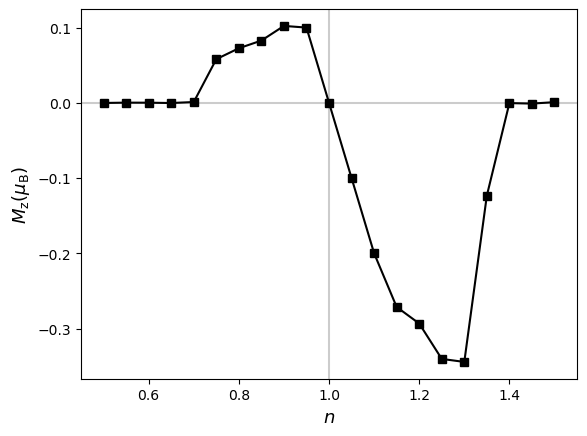

In [856]:


dN_arr=N_A_n_array+N_B_n_array

plt.plot(n_arr, dN_arr, c='black',marker='s',linestyle='-',label=r'$\epsilon=0.1$')
plt.axhline(0,c='black',alpha=0.2)
plt.axvline(1,c='black',alpha=0.2)
plt.xlabel(r'$n$',fontsize=13)
plt.ylabel(r'$M_\text{z}(\mu_\text{B})$',fontsize=13)
#plt.legend()
#plt.xlim(0,310)

#plt.ylim(0,np.max(W_T_array)+0.005)
#plt.title(f'U_c where N ≈ 0: {U_critical:.2f} meV for T = {T}')
plt.savefig('M and n.png')
plt.show()

In [857]:
n_k = 150
kx = np.linspace(-np.pi, np.pi, n_k)
ky = np.linspace(-np.pi, np.pi, n_k)
KX, KY = np.meshgrid(kx, ky)

# Initial values
eps=0.2
x = 0
n_arr = np.linspace(0.5,1.5,21) 


#starting mu
n_0=1
N_0=0
U=1.8



#self consistent
N_A_n2=[]
N_B_n2=[]
mu_n2=[]

for n in n_arr:
    try:
        mu_0 = brentq(density_difference_total, -10, 10, args=(N_0,-N_0 ,U, n, T,eps), xtol=1e-5)
    except ValueError:
        print("mu not found")
    mu_current = mu_0
    N_A_current = 0.4
    N_B_current = -0.4
    for i in range(200):
        # Compute updated order parameters
        N_A_new = x * N_A_current + (1 - x) * order_param(N_A_current, N_B_current, U, mu_current, T,eps)
        N_B_new = x * N_B_current + (1 - x) * order_param2(N_A_current, N_B_current, U, mu_current, T,eps)

        # Update mu to maintain total density ~1
        try:
            mu_new = brentq(density_difference_total, -10, 10, args=(N_A_new, N_B_new, U, n, T,eps), xtol=1e-5)
        except ValueError:
            print("mu not found")
            break

        # Check total density
        n_new_A = n_e(N_A_new, N_B_new, U, mu_new, T, eps)
        n_new_B = n_e2(N_A_new, N_B_new, U, mu_new, T, eps)
        n_total = (n_new_A + n_new_B) / 2

        #print(f"step {i+1}: N_A = {N_A_new:.3f}, N_B = {N_B_new:.3f}, μ = {mu_new:.3f}, n = {n_total:.3f}")

        # Check convergence
        if (np.abs(N_A_new - N_A_current) +
            np.abs(N_B_new - N_B_current) +
            np.abs(n_total - n)) < 1e-4:
            print(f"✅ Converged in {i+1} steps.")
            break
        elif i+1==1000:
            print(f"Did not converge in {i+1} steps.")

        # Update for next step
        N_A_current = N_A_new
        N_B_current = N_B_new
        mu_current = mu_new
    N_A_n2.append(N_A_current)
    N_B_n2.append(N_B_current)
    mu_n2.append(mu_current)


#print("\n📌 Final self-consistent results:")
#print(f"N_A = {N_A_current:.6f}")
#print(f"N_B = {N_B_current:.6f}")
#print(f"μ   = {mu_current:.6f}")
#print(f"n   = {(n_e(N_A_current, N_B_current, U, mu_current, T,eps) + n_e2(N_A_current, N_B_current, U, mu_current, T,eps)) / 2:.6f}")
#print(f"N_A + N_B = {N_A_current + N_B_current:.6e}")



print(N_A_n2,N_B_n2,mu_n2)
N_A_n2_array=np.array(N_A_n2)
N_B_n2_array=np.array(N_B_n2)
mu_n2_array=np.array(mu_n2)


✅ Converged in 12 steps.
✅ Converged in 14 steps.
✅ Converged in 19 steps.
✅ Converged in 24 steps.
✅ Converged in 43 steps.
✅ Converged in 182 steps.
✅ Converged in 29 steps.
✅ Converged in 29 steps.
✅ Converged in 8 steps.
✅ Converged in 11 steps.
✅ Converged in 11 steps.
✅ Converged in 12 steps.
✅ Converged in 10 steps.
✅ Converged in 17 steps.
✅ Converged in 21 steps.
✅ Converged in 24 steps.
✅ Converged in 34 steps.
✅ Converged in 38 steps.
✅ Converged in 32 steps.
✅ Converged in 22 steps.
✅ Converged in 15 steps.
[0.00024943966779374495, 0.00015067037259279548, 0.0004975756407850829, 0.0003741782767628741, 0.00030119011472285124, 0.06278820402151038, 0.4386476675368484, 0.5494259777049153, 0.6094924808914853, 0.6422975962074308, 0.6754585174408028, 0.5414929401268612, 0.4082981442990718, 0.29326435786913635, 0.19681029262440564, 0.1057034437263794, 0.025291365342183954, -0.0005500308390383225, -0.001653525644572949, -0.0428309596060332, -0.001581606252296009] [0.00010422222065080

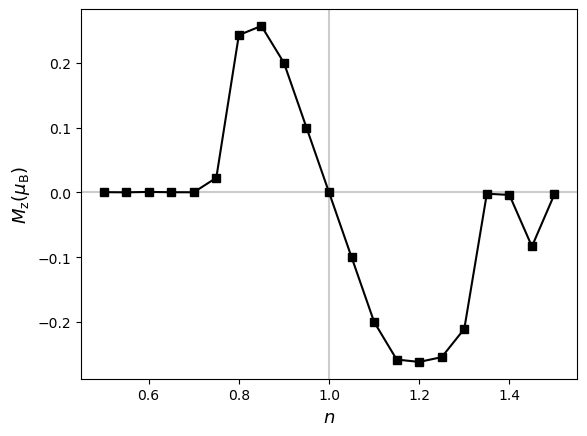

In [858]:
dN_arr2=N_A_n2_array+N_B_n2_array

plt.plot(n_arr, dN_arr2, c='black',marker='s',linestyle='-',label=r'$\epsilon=0.2$')
plt.axhline(0,c='black',alpha=0.2)
plt.axvline(1,c='black',alpha=0.2)
plt.xlabel(r'$n$',fontsize=13)
plt.ylabel(r'$M_\text{z}(\mu_\text{B})$',fontsize=13)
#plt.legend()
#plt.xlim(0,310)

#plt.ylim(0,np.max(W_T_array)+0.005)
#plt.title(f'U_c where N ≈ 0: {U_critical:.2f} meV for T = {T}')
#plt.savefig('M and n.png')
plt.show()

In [859]:
n_k = 150
kx = np.linspace(-np.pi, np.pi, n_k)
ky = np.linspace(-np.pi, np.pi, n_k)
KX, KY = np.meshgrid(kx, ky)

# Initial values
eps=0.05
x = 0
n_arr = np.linspace(0.5,1.5,21) 


#starting mu
n_0=1
N_0=0
U=1.8



#self consistent
N_A_n3=[]
N_B_n3=[]
mu_n3=[]

for n in n_arr:
    try:
        mu_0 = brentq(density_difference_total, -10, 10, args=(N_0,-N_0 ,U, n, T,eps), xtol=1e-5)
    except ValueError:
        print("mu not found")
    mu_current = mu_0
    N_A_current = 0.4
    N_B_current = -0.4
    for i in range(200):
        # Compute updated order parameters
        N_A_new = x * N_A_current + (1 - x) * order_param(N_A_current, N_B_current, U, mu_current, T,eps)
        N_B_new = x * N_B_current + (1 - x) * order_param2(N_A_current, N_B_current, U, mu_current, T,eps)

        # Update mu to maintain total density ~1
        try:
            mu_new = brentq(density_difference_total, -10, 10, args=(N_A_new, N_B_new, U, n, T,eps), xtol=1e-5)
        except ValueError:
            print("mu not found")
            break

        # Check total density
        n_new_A = n_e(N_A_new, N_B_new, U, mu_new, T, eps)
        n_new_B = n_e2(N_A_new, N_B_new, U, mu_new, T, eps)
        n_total = (n_new_A + n_new_B) / 2

        #print(f"step {i+1}: N_A = {N_A_new:.3f}, N_B = {N_B_new:.3f}, μ = {mu_new:.3f}, n = {n_total:.3f}")

        # Check convergence
        if (np.abs(N_A_new - N_A_current) +
            np.abs(N_B_new - N_B_current) +
            np.abs(n_total - n)) < 1e-4:
            print(f"✅ Converged in {i+1} steps.")
            break
        elif i+1==1000:
            print(f"Did not converge in {i+1} steps.")

        # Update for next step
        N_A_current = N_A_new
        N_B_current = N_B_new
        mu_current = mu_new
    N_A_n3.append(N_A_current)
    N_B_n3.append(N_B_current)
    mu_n3.append(mu_current)


#print("\n📌 Final self-consistent results:")
#print(f"N_A = {N_A_current:.6f}")
#print(f"N_B = {N_B_current:.6f}")
#print(f"μ   = {mu_current:.6f}")
#print(f"n   = {(n_e(N_A_current, N_B_current, U, mu_current, T,eps) + n_e2(N_A_current, N_B_current, U, mu_current, T,eps)) / 2:.6f}")
#print(f"N_A + N_B = {N_A_current + N_B_current:.6e}")



print(N_A_n3,N_B_n3,mu_n3)
N_A_n3_array=np.array(N_A_n3)
N_B_n3_array=np.array(N_B_n3)
mu_n3_array=np.array(mu_n3)


✅ Converged in 12 steps.
✅ Converged in 14 steps.
✅ Converged in 19 steps.
✅ Converged in 26 steps.
✅ Converged in 47 steps.
✅ Converged in 49 steps.
✅ Converged in 19 steps.
✅ Converged in 14 steps.
✅ Converged in 10 steps.
✅ Converged in 16 steps.
✅ Converged in 10 steps.
✅ Converged in 21 steps.
✅ Converged in 47 steps.
✅ Converged in 21 steps.
✅ Converged in 23 steps.
✅ Converged in 25 steps.
✅ Converged in 23 steps.
✅ Converged in 35 steps.
✅ Converged in 20 steps.
✅ Converged in 16 steps.
✅ Converged in 14 steps.
[0.00015264151026034983, 6.557745226401813e-05, -0.0001232695210928956, 0.00039279745426144987, 0.0007040001933736568, 0.18802624458314487, 0.35163006109743444, 0.4607817225510116, 0.5561512773177196, 0.6694965546336182, 0.7000250288968517, 0.5954728459109735, 0.45559854931901533, 0.34213481021048003, 0.23626802186093895, 0.10863587569113146, 0.016454396300474305, 7.823680610073808e-05, 9.745675900108745e-06, 0.00040915255210083643, 0.0012298450344876372] [2.512271554586

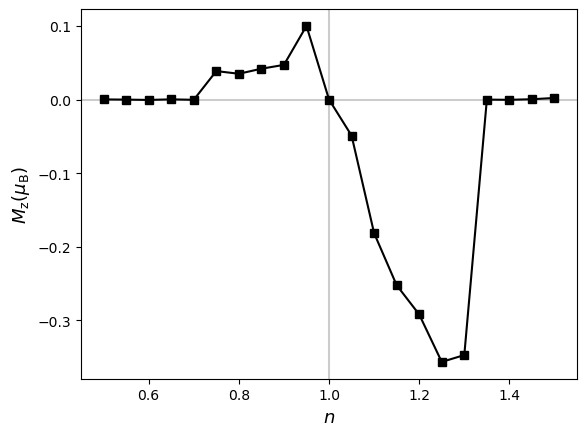

In [860]:
dN_arr3=N_A_n3_array+N_B_n3_array

plt.plot(n_arr, dN_arr3, c='black',marker='s',linestyle='-',label=r'$\epsilon=0.05$')
plt.axhline(0,c='black',alpha=0.2)
plt.axvline(1,c='black',alpha=0.2)
plt.xlabel(r'$n$',fontsize=13)
plt.ylabel(r'$M_\text{z}(\mu_\text{B})$',fontsize=13)
#plt.legend()
#plt.xlim(0,310)

#plt.ylim(0,np.max(W_T_array)+0.005)
#plt.title(f'U_c where N ≈ 0: {U_critical:.2f} meV for T = {T}')
#plt.savefig('M and n.png')
plt.show()

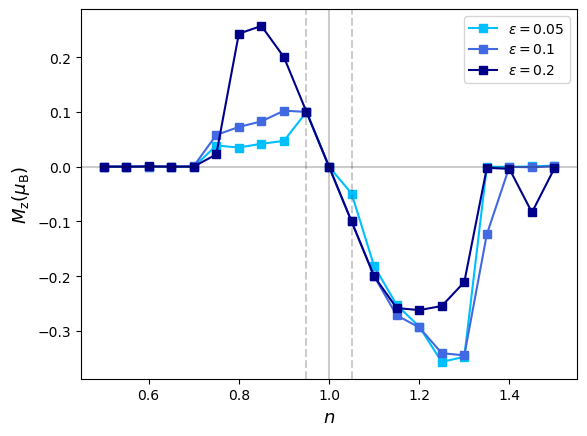

In [861]:
plt.plot(n_arr, dN_arr3, c='deepskyblue',marker='s',linestyle='-',label=r'$\epsilon=0.05$')
plt.plot(n_arr, dN_arr, c='royalblue',marker='s',linestyle='-',label=r'$\epsilon=0.1$')
plt.plot(n_arr, dN_arr2, c='darkblue',marker='s',linestyle='-',label=r'$\epsilon=0.2$')

plt.axvline(0.95,linestyle='--',c='black',alpha=0.2)
plt.axvline(1.05,linestyle='--',c='black',alpha=0.2)

plt.axhline(0,c='black',alpha=0.2)
plt.axvline(1,c='black',alpha=0.2)
plt.xlabel(r'$n$',fontsize=13)
plt.ylabel(r'$M_\text{z}(\mu_\text{B})$',fontsize=13)

plt.legend()
#plt.xlim(0,310)

#plt.ylim(0,np.max(W_T_array)+0.005)
#plt.title(f'U_c where N ≈ 0: {U_critical:.2f} meV for T = {T}')
#plt.savefig('M and n.png')
plt.show()

In [863]:
n_k = 150
kx = np.linspace(-np.pi, np.pi, n_k)
ky = np.linspace(-np.pi, np.pi, n_k)
KX, KY = np.meshgrid(kx, ky)

# Initial values
eps=0
x = 0
n_arr = np.linspace(0.5,1.5,21) 


#starting mu
n_0=1
N_0=0
U=1.8



#self consistent
N_A_n0=[]
N_B_n0=[]
mu_n0=[]

for n in n_arr:
    try:
        mu_0 = brentq(density_difference_total, -10, 10, args=(N_0,-N_0 ,U, n, T,eps), xtol=1e-5)
    except ValueError:
        print("mu not found")
    mu_current = mu_0
    N_A_current = 0.4
    N_B_current = -0.4
    for i in range(200):
        # Compute updated order parameters
        N_A_new = x * N_A_current + (1 - x) * order_param(N_A_current, N_B_current, U, mu_current, T,eps)
        N_B_new = x * N_B_current + (1 - x) * order_param2(N_A_current, N_B_current, U, mu_current, T,eps)

        # Update mu to maintain total density ~1
        try:
            mu_new = brentq(density_difference_total, -10, 10, args=(N_A_new, N_B_new, U, n, T,eps), xtol=1e-5)
        except ValueError:
            print("mu not found")
            break

        # Check total density
        n_new_A = n_e(N_A_new, N_B_new, U, mu_new, T, eps)
        n_new_B = n_e2(N_A_new, N_B_new, U, mu_new, T, eps)
        n_total = (n_new_A + n_new_B) / 2

        #print(f"step {i+1}: N_A = {N_A_new:.3f}, N_B = {N_B_new:.3f}, μ = {mu_new:.3f}, n = {n_total:.3f}")

        # Check convergence
        if (np.abs(N_A_new - N_A_current) +
            np.abs(N_B_new - N_B_current) +
            np.abs(n_total - n)) < 1e-4:
            print(f"✅ Converged in {i+1} steps.")
            break
        elif i+1==1000:
            print(f"Did not converge in {i+1} steps.")

        # Update for next step
        N_A_current = N_A_new
        N_B_current = N_B_new
        mu_current = mu_new
    N_A_n0.append(N_A_current)
    N_B_n0.append(N_B_current)
    mu_n0.append(mu_current)


#print("\n📌 Final self-consistent results:")
#print(f"N_A = {N_A_current:.6f}")
#print(f"N_B = {N_B_current:.6f}")
#print(f"μ   = {mu_current:.6f}")
#print(f"n   = {(n_e(N_A_current, N_B_current, U, mu_current, T,eps) + n_e2(N_A_current, N_B_current, U, mu_current, T,eps)) / 2:.6f}")
#print(f"N_A + N_B = {N_A_current + N_B_current:.6e}")



print(N_A_n0,N_B_n0,mu_n0)
N_A_n0_array=np.array(N_A_n0)
N_B_n0_array=np.array(N_B_n0)
mu_n0_array=np.array(mu_n0)


✅ Converged in 13 steps.
✅ Converged in 15 steps.
✅ Converged in 18 steps.
✅ Converged in 25 steps.
✅ Converged in 48 steps.
✅ Converged in 61 steps.
✅ Converged in 18 steps.
✅ Converged in 14 steps.
✅ Converged in 10 steps.
✅ Converged in 11 steps.
✅ Converged in 10 steps.
✅ Converged in 11 steps.
✅ Converged in 9 steps.
✅ Converged in 13 steps.
✅ Converged in 16 steps.
✅ Converged in 24 steps.
✅ Converged in 80 steps.
✅ Converged in 29 steps.
✅ Converged in 20 steps.
✅ Converged in 17 steps.
✅ Converged in 13 steps.
[0.00022158078174573849, 5.333452966854883e-05, 9.085949702753384e-05, 0.00036359989412234744, 0.0003082238987382591, 0.16498258913921177, 0.3353832053746579, 0.4408147734560071, 0.5339680224202876, 0.620332793228143, 0.7017335493896085, 0.6213556729713072, 0.5402532430613112, 0.4570977022977849, 0.3699581336446087, 0.27266079530377313, 0.009023891420700082, 0.0011243599949540346, 9.307988036243891e-05, 0.0003033014850123954, 0.00010942807092444146] [-0.000221579600171241

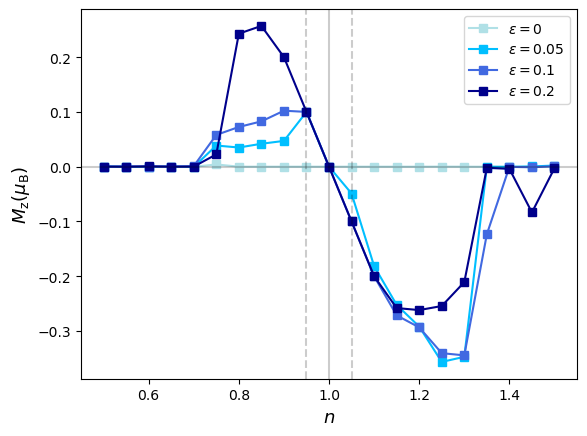

In [864]:
dN_arr0=N_A_n0_array+N_B_n0_array

plt.plot(n_arr, dN_arr0, c='powderblue',marker='s',linestyle='-',label=r'$\epsilon=0$')
plt.plot(n_arr, dN_arr3, c='deepskyblue',marker='s',linestyle='-',label=r'$\epsilon=0.05$')
plt.plot(n_arr, dN_arr, c='royalblue',marker='s',linestyle='-',label=r'$\epsilon=0.1$')
plt.plot(n_arr, dN_arr2, c='darkblue',marker='s',linestyle='-',label=r'$\epsilon=0.2$')

plt.axvline(0.95,linestyle='--',c='black',alpha=0.2)
plt.axvline(1.05,linestyle='--',c='black',alpha=0.2)

plt.axhline(0,c='black',alpha=0.2)
plt.axvline(1,c='black',alpha=0.2)
plt.xlabel(r'$n$',fontsize=13)
plt.ylabel(r'$M_\text{z}(\mu_\text{B})$',fontsize=13)

plt.legend()
#plt.xlim(0,310)

#plt.ylim(0,np.max(W_T_array)+0.005)
#plt.title(f'U_c where N ≈ 0: {U_critical:.2f} meV for T = {T}')
plt.savefig('M and n2.png')
plt.show()

In [868]:
n_k = 150
kx = np.linspace(-np.pi, np.pi, n_k)
ky = np.linspace(-np.pi, np.pi, n_k)
KX, KY = np.meshgrid(kx, ky)

# Initial values
eps=0.15
x = 0
n_arr = np.linspace(0.5,1.5,21) 


#starting mu
n_0=1
N_0=0
U=1.8



#self consistent
N_A_n4=[]
N_B_n4=[]
mu_n4=[]

for n in n_arr:
    try:
        mu_0 = brentq(density_difference_total, -10, 10, args=(N_0,-N_0 ,U, n, T,eps), xtol=1e-5)
    except ValueError:
        print("mu not found")
    mu_current = mu_0
    N_A_current = 0.4
    N_B_current = -0.4
    for i in range(200):
        # Compute updated order parameters
        N_A_new = x * N_A_current + (1 - x) * order_param(N_A_current, N_B_current, U, mu_current, T,eps)
        N_B_new = x * N_B_current + (1 - x) * order_param2(N_A_current, N_B_current, U, mu_current, T,eps)

        # Update mu to maintain total density ~1
        try:
            mu_new = brentq(density_difference_total, -10, 10, args=(N_A_new, N_B_new, U, n, T,eps), xtol=1e-5)
        except ValueError:
            print("mu not found")
            break

        # Check total density
        n_new_A = n_e(N_A_new, N_B_new, U, mu_new, T, eps)
        n_new_B = n_e2(N_A_new, N_B_new, U, mu_new, T, eps)
        n_total = (n_new_A + n_new_B) / 2

        #print(f"step {i+1}: N_A = {N_A_new:.3f}, N_B = {N_B_new:.3f}, μ = {mu_new:.3f}, n = {n_total:.3f}")

        # Check convergence
        if (np.abs(N_A_new - N_A_current) +
            np.abs(N_B_new - N_B_current) +
            np.abs(n_total - n)) < 1e-4:
            print(f"✅ Converged in {i+1} steps.")
            break
        elif i+1==1000:
            print(f"Did not converge in {i+1} steps.")

        # Update for next step
        N_A_current = N_A_new
        N_B_current = N_B_new
        mu_current = mu_new
    N_A_n4.append(N_A_current)
    N_B_n4.append(N_B_current)
    mu_n4.append(mu_current)


#print("\n📌 Final self-consistent results:")
#print(f"N_A = {N_A_current:.6f}")
#print(f"N_B = {N_B_current:.6f}")
#print(f"μ   = {mu_current:.6f}")
#print(f"n   = {(n_e(N_A_current, N_B_current, U, mu_current, T,eps) + n_e2(N_A_current, N_B_current, U, mu_current, T,eps)) / 2:.6f}")
#print(f"N_A + N_B = {N_A_current + N_B_current:.6e}")



print(N_A_n4,N_B_n4,mu_n4)
N_A_n4_array=np.array(N_A_n4)
N_B_n4_array=np.array(N_B_n4)
mu_n4_array=np.array(mu_n4)


✅ Converged in 12 steps.
✅ Converged in 14 steps.
✅ Converged in 18 steps.
✅ Converged in 24 steps.
✅ Converged in 40 steps.
✅ Converged in 146 steps.
✅ Converged in 19 steps.
✅ Converged in 14 steps.
✅ Converged in 19 steps.
✅ Converged in 11 steps.
✅ Converged in 11 steps.
✅ Converged in 11 steps.
✅ Converged in 11 steps.
✅ Converged in 15 steps.
✅ Converged in 15 steps.
✅ Converged in 19 steps.
✅ Converged in 26 steps.
✅ Converged in 74 steps.
✅ Converged in 27 steps.
✅ Converged in 21 steps.
✅ Converged in 13 steps.
[-6.016232618569369e-05, 4.715599721690154e-05, 4.8722007154831054e-05, 8.596636939441753e-05, 0.0002174130681939601, 0.13384400074851988, 0.3879098615241253, 0.4980856043026048, 0.6121918873704898, 0.6547021700341724, 0.6867258472571226, 0.5554207375104937, 0.42614093481691706, 0.31079635533346445, 0.21337984285826114, 0.11393838833667845, 0.011796131643402314, -0.0019576189293736036, -0.04621384437053397, -0.00043281760431186986, 0.0006368372430888222] [-0.00029539367

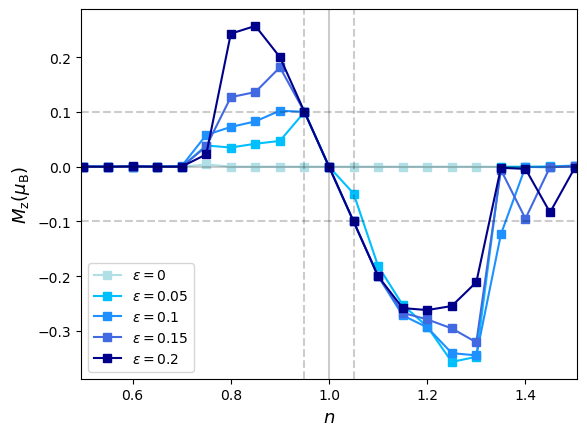

In [874]:
dN_arr4=N_A_n4_array+N_B_n4_array

plt.plot(n_arr, dN_arr0, c='powderblue',marker='s',linestyle='-',label=r'$\epsilon=0$')
plt.plot(n_arr, dN_arr3, c='deepskyblue',marker='s',linestyle='-',label=r'$\epsilon=0.05$')
plt.plot(n_arr, dN_arr, c='dodgerblue',marker='s',linestyle='-',label=r'$\epsilon=0.1$')
plt.plot(n_arr, dN_arr4, c='royalblue',marker='s',linestyle='-',label=r'$\epsilon=0.15$')
plt.plot(n_arr, dN_arr2, c='darkblue',marker='s',linestyle='-',label=r'$\epsilon=0.2$')

plt.axvline(0.95,linestyle='--',c='black',alpha=0.2)
plt.axvline(1.05,linestyle='--',c='black',alpha=0.2)

plt.axhline(0.1,linestyle='--',c='black',alpha=0.2)
plt.axhline(-0.1,linestyle='--',c='black',alpha=0.2)

plt.axhline(0,c='black',alpha=0.2)
plt.axvline(1,c='black',alpha=0.2)
plt.xlabel(r'$n$',fontsize=13)
plt.ylabel(r'$M_\text{z}(\mu_\text{B})$',fontsize=13)

plt.legend()
plt.xlim(0.495,1.505)

#plt.ylim(0,np.max(W_T_array)+0.005)
#plt.title(f'U_c where N ≈ 0: {U_critical:.2f} meV for T = {T}')
plt.savefig('M and n.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Half filling

# Paper

## Half filling

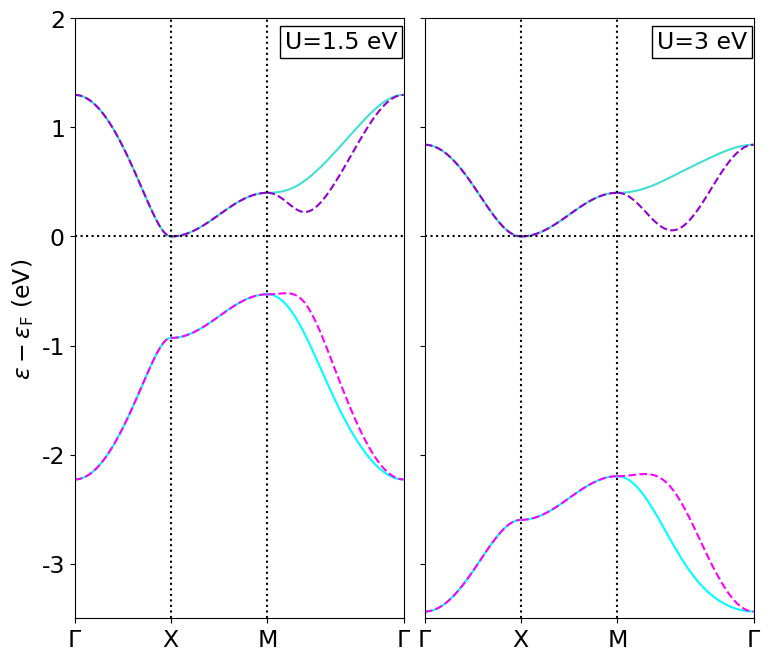

In [153]:
fig= plt.figure( figsize=(7, 6))


ax1 = fig.add_axes([0, 0, 0.47, 1])
ax2 = fig.add_axes([0.5, 0, 0.47, 1])

G = np.array([0, 0])
X = np.array([np.pi, 0])
M = np.array([np.pi, np.pi])
path = [G, X, M, G]
labels = [r'$\Gamma$', r'$\text{X}$', r'$\text{M}$', r'$\Gamma$']
points_per_segment = 200


U=1.5
N_A = 0.620242
N_B = -0.620242
mu  = 0.364980

U2=3
N_A2 = 0.866006
N_B2 = -0.866006
mu2  = 1.198803

epsilo= 0 

k1=np.linspace(0,np.pi,100)
k0=np.full_like(k1,0) 
k2=np.full_like(k1,np.pi)
k3=np.linspace(np.pi,0,100)


E1=energy_split(k1, k0, N_A, N_B, U, mu, epsilo)
E2=energy_split(k2, k1, N_A, N_B, U, mu, epsilo)
E3=energy_split(k3, k3, N_A, N_B, U, mu, epsilo)


#plotting all bands for each path between high symmetry points
ax1.plot(np.linspace(0,1,100), E1[0], label=r'$\uparrow$, $\beta=+1$', color='turquoise')
ax1.plot(np.linspace(0,1,100), E1[1], label=r'$\uparrow$, $\beta=-1$ ', color='cyan')
ax1.plot(np.linspace(0,1,100), E1[2], '--',color='darkviolet')
ax1.plot(np.linspace(0,1,100), E1[3],'--', color='magenta')

ax1.plot(np.linspace(1,2,100), E2[0], color='turquoise')
ax1.plot(np.linspace(1,2,100), E2[1], color='cyan')
ax1.plot(np.linspace(1,2,100), E2[2], '--',color='darkviolet')
ax1.plot(np.linspace(1,2,100), E2[3],'--',  color='magenta')

ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[0], color='turquoise')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[1], color='cyan')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[2], '--',label=r'$\downarrow$, $\beta=+1$', color='darkviolet')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[3],'--', label=r'$\downarrow$, $\beta=-1$', color='magenta')




# Set custom x-axis ticks and labels
tick_positions = [0,1,2,2+np.sqrt(2)]
tick_labels = labels
ax1.set_xticks(tick_positions, tick_labels, fontsize=17)

y_tick_positions=[-3,-2,-1,0,1,2,3]
y_tick_labels=[-3,-2,-1,0,1,2,3]
ax1.set_yticks(y_tick_positions,y_tick_labels, fontsize=17)



# Dotted vertical line at x = 2
ax1.axvline(x=1, linestyle=':', linewidth=1.5,color='black')
ax1.axvline(x=2, linestyle=':', linewidth=1.5,color='black')

# Dotted horizontal line at y = 3
ax1.axhline(y=0, linestyle=':', linewidth=1.5,color='black')


ax1.text(
    0.98, 0.98,                    # x, y position in axes coordinates (0–1)
    'U=1.5 eV',              # text content
    transform=ax1.transAxes,        # interpret x,y as relative to the axes
    ha='right', va='top',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',         # border color
        linewidth=1,
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)

#plt.xlabel("k-path")
ax1.set_ylabel(r"$\epsilon-\epsilon_\text{F}\text{ }(\text{eV})$",fontsize=17)
#plt.title(f"Band Dispersion along High-Symmetry Path for $\epsilon$={epsilo}")
ax1.set_xlim(0,2+np.sqrt(2))
ax1.set_ylim(-3.5,2)
#plt.grid(True)
#ax1.legend(loc='upper left')



E12=energy_split(k1, k0, N_A2, N_B2, U2, mu2, epsilo)
E22=energy_split(k2, k1, N_A2, N_B2, U2, mu2, epsilo)
E32=energy_split(k3, k3, N_A2, N_B2, U2, mu2, epsilo)


#plotting all bands for each path between high symmetry points
ax2.plot(np.linspace(0,1,100), E12[0], label=r'$\uparrow$, $\beta=+1$', color='turquoise')
ax2.plot(np.linspace(0,1,100), E12[1], label=r'$\uparrow$, $\beta=-1$ ', color='cyan')
ax2.plot(np.linspace(0,1,100), E12[2], '--',color='darkviolet')
ax2.plot(np.linspace(0,1,100), E12[3],'--', color='magenta')

ax2.plot(np.linspace(1,2,100), E22[0], color='turquoise')
ax2.plot(np.linspace(1,2,100), E22[1], color='cyan')
ax2.plot(np.linspace(1,2,100), E22[2], '--',color='darkviolet')
ax2.plot(np.linspace(1,2,100), E22[3],'--',  color='magenta')

ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[0], color='turquoise')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[1], color='cyan')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[2], '--',label=r'$\downarrow$, $\beta=+1$', color='darkviolet')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[3],'--', label=r'$\downarrow$, $\beta=-1$', color='magenta')




# Set custom x-axis ticks and labels
tick_positions = [0,1,2,2+np.sqrt(2)]
tick_labels = labels
ax2.set_xticks(tick_positions, tick_labels, fontsize=17)

y_tick_positions=[-3,-2,-1,0,1,2,3]
y_tick_labels=[]
ax2.set_yticks(y_tick_positions,y_tick_labels, fontsize=15)



# Dotted vertical line at x = 2
ax2.axvline(x=1, linestyle=':', linewidth=1.5,color='black')
ax2.axvline(x=2, linestyle=':', linewidth=1.5,color='black')

# Dotted horizontal line at y = 3
ax2.axhline(y=0, linestyle=':', linewidth=1.5,color='black')


ax2.text(
    0.98, 0.98,                    # x, y position in axes coordinates (0–1)
    'U=3 eV',              # text content
    transform=ax2.transAxes,        # interpret x,y as relative to the axes
    ha='right', va='top',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',
        linewidth=1,         # border color
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)

#plt.xlabel("k-path")
#ax2.set_ylabel(r"$\epsilon-\epsilon_\text{F}\text{ }(\text{eV})$",fontsize=15)
#plt.title(f"Band Dispersion along High-Symmetry Path for $\epsilon$={epsilo}")
ax2.set_xlim(0,2+np.sqrt(2))
ax2.set_ylim(-3.5,2)
#plt.grid(True)
#ax2.legend(loc='upper left')






#plt.tight_layout()
plt.savefig('dispersion along path half filling U=1.5, U=3.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()



In [17]:
#k grid
n_k = 150
kx = np.linspace(-np.pi, np.pi, n_k)
ky = np.linspace(-np.pi, np.pi, n_k)
KX, KY = np.meshgrid(kx, ky)

# Initial values
eps=0
x = 0
U_arr = np.concatenate((np.linspace(0,0.9,5),np.linspace(0.92,1,5),np.linspace(1.2,6,5))) 


#starting mu
n_0=1
N_0=0
U_0=1



#self consistent
N_A_U2=[]
N_B_U2=[]
n_up_A2_list=[]
n_down_A2_list=[]
n_up_B2_list=[]
n_down_B2_list=[]
mu_U2=[]

for U in U_arr:
    try:
        mu_0 = brentq(density_difference_total, -10, 10, args=(N_0,-N_0 ,U, n_0, T,eps), xtol=1e-5)
    except ValueError:
        print("mu not found")
    mu_current = mu_0
    N_A_current = 0.4
    N_B_current = -0.4
    for i in range(200):
        # Compute updated order parameters
        N_A_new = x * N_A_current + (1 - x) * order_param(N_A_current, N_B_current, U, mu_current, T,eps)
        N_B_new = x * N_B_current + (1 - x) * order_param2(N_A_current, N_B_current, U, mu_current, T,eps)

        # Update mu to maintain total density ~1
        try:
            mu_new = brentq(density_difference_total, -10, 10, args=(N_A_new, N_B_new, U, n_0, T,eps), xtol=1e-5)
        except ValueError:
            print("mu not found")
            break

        # Check total density
        n_new_A = n_e(N_A_new, N_B_new, U, mu_new, T, eps)
        n_new_B = n_e2(N_A_new, N_B_new, U, mu_new, T, eps)
        n_total = (n_new_A + n_new_B) / 2

        n_up_A=n_up(N_A_new,N_B_new,U,mu_new,T,eps)
        n_down_A=n_down(N_A_new,N_B_new,U,mu_new,T,eps)

        n_up_B=n_up2(N_A_new,N_B_new,U,mu_new,T,eps)
        n_down_B=n_down2(N_A_new,N_B_new,U,mu_new,T,eps)

        #print(f"step {i+1}: N_A = {N_A_new:.3f}, N_B = {N_B_new:.3f}, μ = {mu_new:.3f}, n = {n_total:.3f}")

        # Check convergence
        if (np.abs(N_A_new - N_A_current) +
            np.abs(N_B_new - N_B_current) +
            np.abs(n_total - n_0)) < 1e-4:
            print(f"✅ Converged in {i+1} steps.")
            break
        elif i+1==1000:
            print(f"Did not converge in {i+1} steps.")

        # Update for next step
        N_A_current = N_A_new
        N_B_current = N_B_new
        mu_current = mu_new
    N_A_U2.append(N_A_current)
    N_B_U2.append(N_B_current)
    n_up_A2_list.append(n_up_A)
    n_down_A2_list.append(n_down_A)
    n_up_B2_list.append(n_up_B)
    n_down_B2_list.append(n_down_B)
    mu_U2.append(mu_current)


#print("\n📌 Final self-consistent results:")
#print(f"N_A = {N_A_current:.6f}")
#print(f"N_B = {N_B_current:.6f}")
#print(f"μ   = {mu_current:.6f}")
#print(f"n   = {(n_e(N_A_current, N_B_current, U, mu_current, T,eps) + n_e2(N_A_current, N_B_current, U, mu_current, T,eps)) / 2:.6f}")
#print(f"N_A + N_B = {N_A_current + N_B_current:.6e}")



print(N_A_U2,N_B_U2,mu_U2)
N_A_U_array2=np.array(N_A_U2)
N_B_U_array2=np.array(N_B_U2)
mu_U_array2=np.array(mu_U2)

# Find critical temperature where W becomes nearly zero
epsilon = 1e-1
U_values2 = U_arr


#Find first index where W < epsilon
try:
    idx = np.where(np.abs(N_A_U_array2) > epsilon)[0][0]
    U_A_critical2 = U_values2[idx-1]
    print(f"Estimated critical interaction U_c where N_A ≈ 0: {U_A_critical2:.2f} meV")
except IndexError:
    print("N_A does not drop below threshold within U range.")
    U_A_critical2 = None

try:
    idx = np.where(np.abs(N_B_U_array2) > epsilon)[0][0]
    U_B_critical2 = U_values2[idx-1]
    print(f"Estimated critical interaction U_c where N_B ≈ 0: {U_B_critical2:.2f} meV")
except IndexError:
    print("N_B does not drop below threshold within U range.")
    U_B_critical2 = None

✅ Converged in 2 steps.
✅ Converged in 7 steps.
✅ Converged in 11 steps.
✅ Converged in 19 steps.
✅ Converged in 56 steps.
✅ Converged in 49 steps.
✅ Converged in 59 steps.
✅ Converged in 69 steps.
✅ Converged in 71 steps.
✅ Converged in 15 steps.
✅ Converged in 12 steps.
✅ Converged in 9 steps.
✅ Converged in 7 steps.
✅ Converged in 6 steps.
✅ Converged in 5 steps.
[np.float64(0.0), np.float64(2.8033548280446862e-05), np.float64(6.160113877541258e-05), np.float64(9.376355156310293e-05), np.float64(0.00018748640901943947), np.float64(0.0022458784904115757), np.float64(0.0024435093599250463), np.float64(0.0035923712706553332), np.float64(0.005328034470278978), np.float64(0.41549250057709), np.float64(0.5091172299557598), np.float64(0.8062581990951355), np.float64(0.9025118194100639), np.float64(0.9423544691615459), np.float64(0.9621552150198852)] [np.float64(0.0), np.float64(-2.8033548280446212e-05), np.float64(-6.160113877541195e-05), np.float64(-9.376355156310297e-05), np.float64(-0.0

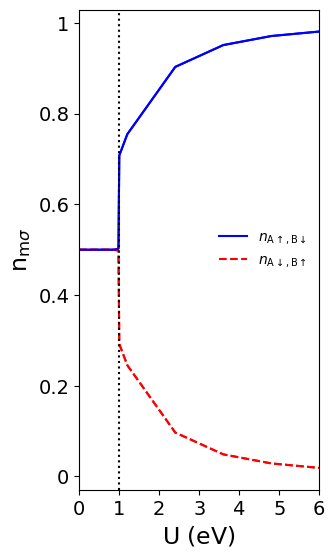

In [186]:
fig=plt.figure(figsize=(6, 6))

ax3=fig.add_axes([0.05,0.1,0.4,0.8])

#ax1.plot(U_arr, N_A_U_array2, marker='s', label=r'$N_\text{A}$')
#ax1.plot(U_arr, N_B_U_array2, marker='s', label=r'$N_\text{B}$')

ax3.plot(U_arr, n_up_A2_list, c='blue', label=r'$n_{\text{A}\uparrow,\text{B}\downarrow}$')
ax3.plot(U_arr, n_down_A2_list, c='red', linestyle='--')

ax3.plot(U_arr, n_up_B2_list, c='red', linestyle='--',label=r'$n_{\text{A}\downarrow,\text{B}\uparrow}$')
ax3.plot(U_arr, n_down_B2_list, c='blue')

    
ax3.axvline(x=1, linestyle=':', linewidth=1.5,color='black')


ax3.set_xlim(0,6)


x_tick_positions=[0,1,2,3,4,5,6]
x_tick_labels=[0,1,2,3,4,5,6]
ax3.set_xticks(x_tick_positions,x_tick_labels, fontsize=14)

y_tick_positions=[0,0.2,0.4,0.6,0.8,1]
y_tick_labels=[0,0.2,0.4,0.6,0.8,1]
ax3.set_yticks(y_tick_positions,y_tick_labels, fontsize=14)

ax3.set_xlabel(r'$\text{U } (\text{eV})$',fontsize=17)
ax3.set_ylabel(r'$\text{n}_{\text{m}\sigma}$',fontsize=17)
ax3.legend(loc='right',framealpha=0.0)



# === Legend ===
#from matplotlib.lines import Line2D
#legend_elements = [
#    Line2D([0], [0], color='red', label=r'$\uparrow, \beta=+1$'),
#    Line2D([0], [0], color='red', linestyle='dashed', label=r'$\uparrow, \beta=-1$'),
#    Line2D([0], [0], color='blue', label=r'$\downarrow, \beta=+1$'),
#    Line2D([0], [0], color='blue', linestyle='dashed', label=r'$\downarrow, \beta=-1$')]



#plt.savefig('fermi surface at Us and N and U 2.png', bbox_inches='tight', pad_inches=0.1)
plt.show()


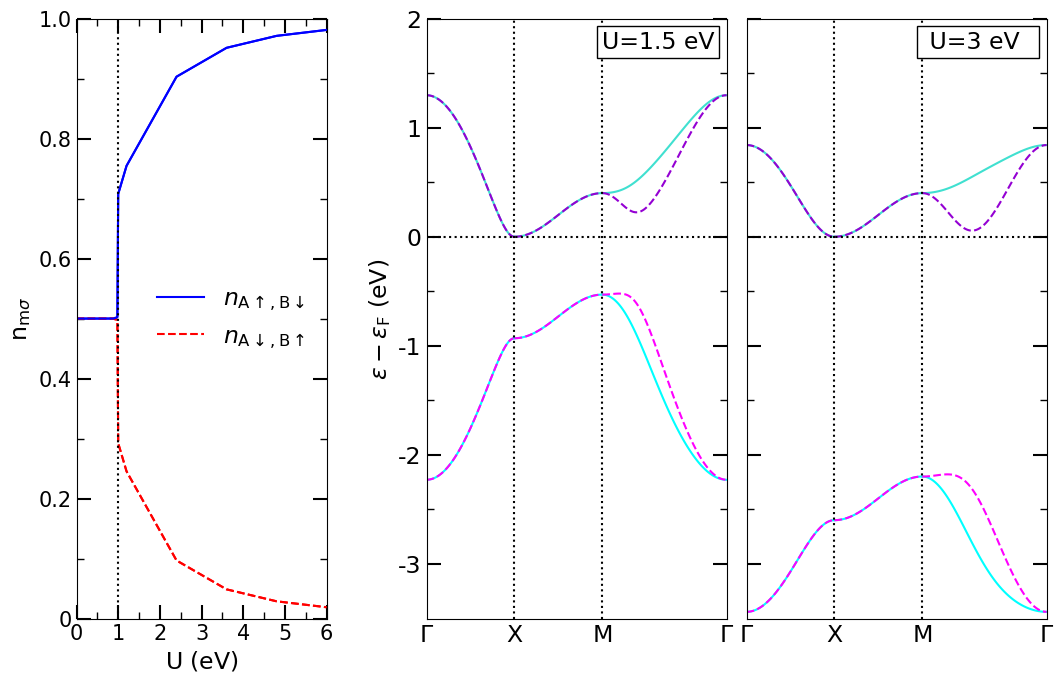

In [44]:
fig= plt.figure( figsize=(10, 6))

ax3 = fig.add_axes([0, 0, 0.25, 1])
ax1 = fig.add_axes([0.35, 0, 0.3, 1])
ax2 = fig.add_axes([0.67, 0, 0.3, 1])

G = np.array([0, 0])
X = np.array([np.pi, 0])
M = np.array([np.pi, np.pi])
path = [G, X, M, G]
labels = [r'$\Gamma$', r'$\text{X}$', r'$\text{M}$', r'$\Gamma$']
points_per_segment = 200


U=1.5
N_A = 0.620242
N_B = -0.620242
mu  = 0.364980

U2=3
N_A2 = 0.866006
N_B2 = -0.866006
mu2  = 1.198803

epsilo= 0 

k1=np.linspace(0,np.pi,100)
k0=np.full_like(k1,0) 
k2=np.full_like(k1,np.pi)
k3=np.linspace(np.pi,0,100)


E1=energy_split(k1, k0, N_A, N_B, U, mu, epsilo)
E2=energy_split(k2, k1, N_A, N_B, U, mu, epsilo)
E3=energy_split(k3, k3, N_A, N_B, U, mu, epsilo)


#plotting all bands for each path between high symmetry points
ax1.plot(np.linspace(0,1,100), E1[0], label=r'$\uparrow$, $\beta=+1$', color='turquoise')
ax1.plot(np.linspace(0,1,100), E1[1], label=r'$\uparrow$, $\beta=-1$ ', color='cyan')
ax1.plot(np.linspace(0,1,100), E1[2], '--',color='darkviolet')
ax1.plot(np.linspace(0,1,100), E1[3],'--', color='magenta')

ax1.plot(np.linspace(1,2,100), E2[0], color='turquoise')
ax1.plot(np.linspace(1,2,100), E2[1], color='cyan')
ax1.plot(np.linspace(1,2,100), E2[2], '--',color='darkviolet')
ax1.plot(np.linspace(1,2,100), E2[3],'--',  color='magenta')

ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[0], color='turquoise')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[1], color='cyan')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[2], '--',label=r'$\downarrow$, $\beta=+1$', color='darkviolet')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[3],'--', label=r'$\downarrow$, $\beta=-1$', color='magenta')




# Set custom x-axis ticks and labels
tick_positions = [0,1,2,2+np.sqrt(2)]
tick_labels = labels
ax1.set_xticks(tick_positions, tick_labels, fontsize=17)

ax1.tick_params(axis='x',length=0)

#y_tick_positions=[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3]
y_tick_labels=[-3,-2,-1,0,1,2,3]
#ax1.set_yticks(y_tick_positions,y_tick_labels, fontsize=17)

# Major ticks at whole numbers
y_tick_positions_major=[-3,-2,-1,0,1,2,3]
ax1.set_yticks(y_tick_positions_major,y_tick_labels,fontsize=17)

# Minor ticks at half numbers
y_tick_positions_minor=[-2.5,-1.5,-0.5,0.5,1.5,2.5]
ax1.set_yticks(y_tick_positions_minor,[], minor=True)

# Style major vs minor ticks
ax1.tick_params(axis='y',which='major',direction='in',length=10, width=1.5, left=True, right=True)

ax1.tick_params(axis='y',which='minor',direction='in',length=5, width=1, left=True, right=True)

# Dotted vertical line at x = 2
ax1.axvline(x=1, linestyle=':', linewidth=1.5,color='black')
ax1.axvline(x=2, linestyle=':', linewidth=1.5,color='black')

# Dotted horizontal line at y = 3
ax1.axhline(y=0, linestyle=':', linewidth=1.5,color='black')


ax1.text(
    0.96, 0.98,                    # x, y position in axes coordinates (0–1)
    'U=1.5 eV',              # text content
    transform=ax1.transAxes,        # interpret x,y as relative to the axes
    ha='right', va='top',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',         # border color
        linewidth=1,
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)

#plt.xlabel("k-path")
ax1.set_ylabel(r"$\epsilon-\epsilon_\text{F}\text{ }(\text{eV})$",fontsize=17)
#plt.title(f"Band Dispersion along High-Symmetry Path for $\epsilon$={epsilo}")
ax1.set_xlim(0,2+np.sqrt(2))
ax1.set_ylim(-3.5,2)
#plt.grid(True)
#ax1.legend(loc='upper left')



E12=energy_split(k1, k0, N_A2, N_B2, U2, mu2, epsilo)
E22=energy_split(k2, k1, N_A2, N_B2, U2, mu2, epsilo)
E32=energy_split(k3, k3, N_A2, N_B2, U2, mu2, epsilo)


#plotting all bands for each path between high symmetry points
ax2.plot(np.linspace(0,1,100), E12[0], label=r'$\uparrow$, $\beta=+1$', color='turquoise')
ax2.plot(np.linspace(0,1,100), E12[1], label=r'$\uparrow$, $\beta=-1$ ', color='cyan')
ax2.plot(np.linspace(0,1,100), E12[2], '--',color='darkviolet')
ax2.plot(np.linspace(0,1,100), E12[3],'--', color='magenta')

ax2.plot(np.linspace(1,2,100), E22[0], color='turquoise')
ax2.plot(np.linspace(1,2,100), E22[1], color='cyan')
ax2.plot(np.linspace(1,2,100), E22[2], '--',color='darkviolet')
ax2.plot(np.linspace(1,2,100), E22[3],'--',  color='magenta')

ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[0], color='turquoise')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[1], color='cyan')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[2], '--',label=r'$\downarrow$, $\beta=+1$', color='darkviolet')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[3],'--', label=r'$\downarrow$, $\beta=-1$', color='magenta')




# Set custom x-axis ticks and labels
tick_positions = [0,1,2,2+np.sqrt(2)]
tick_labels = labels
ax2.set_xticks(tick_positions, tick_labels, fontsize=17)

ax2.tick_params(axis='x',length=0)

#y_tick_positions=[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3]
y_tick_labels=[]
#ax2.set_yticks(y_tick_positions,y_tick_labels, fontsize=15)

# Major ticks at whole numbers
y_tick_positions_major=[-3,-2,-1,0,1,2,3]
ax2.set_yticks(y_tick_positions_major,[],fontsize=17)

# Minor ticks at half numbers
y_tick_positions_minor=[-2.5,-1.5,-0.5,0.5,1.5,2.5]
ax2.set_yticks(y_tick_positions_minor,[], minor=True)

# Style major vs minor ticks
ax2.tick_params(axis='y',which='major',direction='in',length=10, width=1.5, left=True, right=True)

ax2.tick_params(axis='y',which='minor',direction='in',length=5, width=1, left=True, right=True)

# Dotted vertical line at x = 2
ax2.axvline(x=1, linestyle=':', linewidth=1.5,color='black')
ax2.axvline(x=2, linestyle=':', linewidth=1.5,color='black')

# Dotted horizontal line at y = 3
ax2.axhline(y=0, linestyle=':', linewidth=1.5,color='black')


ax2.text(
    0.96, 0.98,                    # x, y position in axes coordinates (0–1)
    ' U=3 eV  ',              # text content
    transform=ax2.transAxes,        # interpret x,y as relative to the axes
    ha='right', va='top',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',
        linewidth=1,         # border color
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)

#plt.xlabel("k-path")
#ax2.set_ylabel(r"$\epsilon-\epsilon_\text{F}\text{ }(\text{eV})$",fontsize=15)
#plt.title(f"Band Dispersion along High-Symmetry Path for $\epsilon$={epsilo}")
ax2.set_xlim(0,2+np.sqrt(2))
ax2.set_ylim(-3.5,2)
#plt.grid(True)
#ax2.legend(loc='upper left')



ax3.plot(U_arr, n_up_A2_list, c='blue', label=r'$n_{\text{A}\uparrow,\text{B}\downarrow}$')
ax3.plot(U_arr, n_down_A2_list, c='red', linestyle='--')

ax3.plot(U_arr, n_up_B2_list, c='red', linestyle='--',label=r'$n_{\text{A}\downarrow,\text{B}\uparrow}$')
ax3.plot(U_arr, n_down_B2_list, c='blue')

    
ax3.axvline(x=1, linestyle=':', linewidth=1.5,color='black')


ax3.set_xlim(0,6)


#x_tick_positions=[0,1,2,3,4,5,6]
x_tick_labels=[0,1,2,3,4,5,6]
#ax3.set_xticks(x_tick_positions,x_tick_labels, fontsize=15)
# Major ticks at whole numbers
x_tick_positions_major=[0,1,2,3,4,5,6]
ax3.set_xticks(x_tick_positions_major,x_tick_labels,fontsize=15)

# Minor ticks at half numbers
x_tick_positions_minor=[0.5,1.5,2.5,3.5,4.5,5.5]
ax3.set_xticks(x_tick_positions_minor,[], minor=True)

# Style major vs minor ticks
ax3.tick_params(axis='x',
               which='major',
               direction='in',
               length=10, width=1.5, top=True, bottom=True)

ax3.tick_params(axis='x',
               which='minor',
               direction='in',
               length=5, width=1, top=True, bottom=True)



#y_tick_positions=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
y_tick_labels=[0,0.2,0.4,0.6,0.8,1.0]
#ax3.set_yticks(y_tick_positions,y_tick_labels, fontsize=15)

# Major ticks at whole numbers
y_tick_positions_major=[0,0.2,0.4,0.6,0.8,1.0]
ax3.set_yticks(y_tick_positions_major,y_tick_labels,fontsize=15)

# Minor ticks at half numbers
y_tick_positions_minor=[0.1,0.3,0.5,0.7,0.9]
ax3.set_yticks(y_tick_positions_minor,[], minor=True)

# Style major vs minor ticks
ax3.tick_params(axis='y',
               which='major',
               direction='in',
               length=10, width=1.5, left=True, right=True)

ax3.tick_params(axis='y',
               which='minor',
               direction='in',
               length=5, width=1, left=True, right=True)

ax3.set_ylim(0,1)
ax3.set_xlabel(r'$\text{U } (\text{eV})$',fontsize=17)
ax3.set_ylabel(r'$\text{n}_{\text{m}\sigma}$',fontsize=17)
ax3.legend(loc='right',framealpha=0.0,fontsize=17)



#plt.tight_layout()
plt.savefig('half filling mean field.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()



### Figures seperate

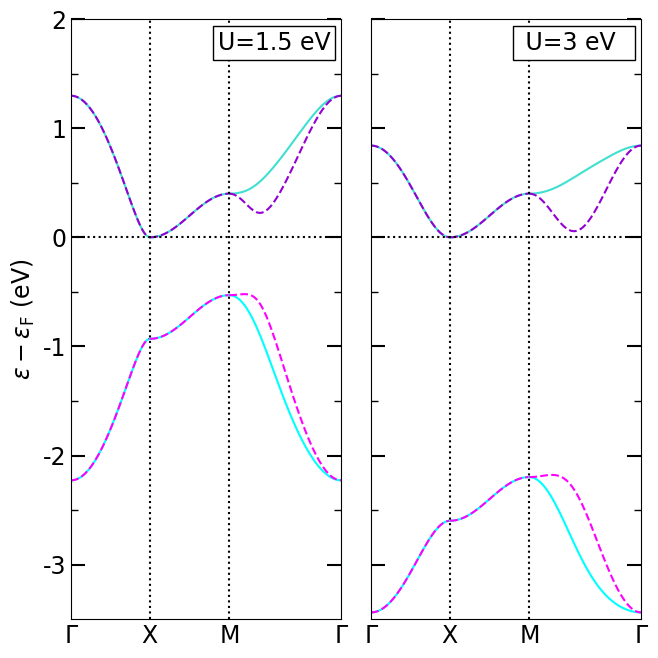

In [30]:
fig= plt.figure( figsize=(6, 6))

ax1 = fig.add_axes([0, 0, 0.45, 1])
ax2 = fig.add_axes([0.5, 0, 0.45, 1])

G = np.array([0, 0])
X = np.array([np.pi, 0])
M = np.array([np.pi, np.pi])
path = [G, X, M, G]
labels = [r'$\Gamma$', r'$\text{X}$', r'$\text{M}$', r'$\Gamma$']
points_per_segment = 200


U=1.5
N_A = 0.620242
N_B = -0.620242
mu  = 0.364980

U2=3
N_A2 = 0.866006
N_B2 = -0.866006
mu2  = 1.198803

epsilo= 0 

k1=np.linspace(0,np.pi,100)
k0=np.full_like(k1,0) 
k2=np.full_like(k1,np.pi)
k3=np.linspace(np.pi,0,100)


E1=energy_split(k1, k0, N_A, N_B, U, mu, epsilo)
E2=energy_split(k2, k1, N_A, N_B, U, mu, epsilo)
E3=energy_split(k3, k3, N_A, N_B, U, mu, epsilo)


#plotting all bands for each path between high symmetry points
ax1.plot(np.linspace(0,1,100), E1[0], label=r'$\uparrow$, $\beta=+1$', color='turquoise')
ax1.plot(np.linspace(0,1,100), E1[1], label=r'$\uparrow$, $\beta=-1$ ', color='cyan')
ax1.plot(np.linspace(0,1,100), E1[2], '--',color='darkviolet')
ax1.plot(np.linspace(0,1,100), E1[3],'--', color='magenta')

ax1.plot(np.linspace(1,2,100), E2[0], color='turquoise')
ax1.plot(np.linspace(1,2,100), E2[1], color='cyan')
ax1.plot(np.linspace(1,2,100), E2[2], '--',color='darkviolet')
ax1.plot(np.linspace(1,2,100), E2[3],'--',  color='magenta')

ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[0], color='turquoise')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[1], color='cyan')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[2], '--',label=r'$\downarrow$, $\beta=+1$', color='darkviolet')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[3],'--', label=r'$\downarrow$, $\beta=-1$', color='magenta')




# Set custom x-axis ticks and labels
tick_positions = [0,1,2,2+np.sqrt(2)]
tick_labels = labels
ax1.set_xticks(tick_positions, tick_labels, fontsize=17)

ax1.tick_params(axis='x',length=0)

#y_tick_positions=[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3]
y_tick_labels=[-3,-2,-1,0,1,2,3]
#ax1.set_yticks(y_tick_positions,y_tick_labels, fontsize=17)

# Major ticks at whole numbers
y_tick_positions_major=[-3,-2,-1,0,1,2,3]
ax1.set_yticks(y_tick_positions_major,y_tick_labels,fontsize=17)

# Minor ticks at half numbers
y_tick_positions_minor=[-2.5,-1.5,-0.5,0.5,1.5,2.5]
ax1.set_yticks(y_tick_positions_minor,[], minor=True)

# Style major vs minor ticks
ax1.tick_params(axis='y',which='major',direction='in',length=10, width=1.5, left=True, right=True)

ax1.tick_params(axis='y',which='minor',direction='in',length=5, width=1, left=True, right=True)

# Dotted vertical line at x = 2
ax1.axvline(x=1, linestyle=':', linewidth=1.5,color='black')
ax1.axvline(x=2, linestyle=':', linewidth=1.5,color='black')

# Dotted horizontal line at y = 3
ax1.axhline(y=0, linestyle=':', linewidth=1.5,color='black')


ax1.text(
    0.96, 0.98,                    # x, y position in axes coordinates (0–1)
    'U=1.5 eV',              # text content
    transform=ax1.transAxes,        # interpret x,y as relative to the axes
    ha='right', va='top',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',         # border color
        linewidth=1,
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)

#plt.xlabel("k-path")
ax1.set_ylabel(r"$\epsilon-\epsilon_\text{F}\text{ }(\text{eV})$",fontsize=17)
#plt.title(f"Band Dispersion along High-Symmetry Path for $\epsilon$={epsilo}")
ax1.set_xlim(0,2+np.sqrt(2))
ax1.set_ylim(-3.5,2)
#plt.grid(True)
#ax1.legend(loc='upper left')



E12=energy_split(k1, k0, N_A2, N_B2, U2, mu2, epsilo)
E22=energy_split(k2, k1, N_A2, N_B2, U2, mu2, epsilo)
E32=energy_split(k3, k3, N_A2, N_B2, U2, mu2, epsilo)


#plotting all bands for each path between high symmetry points
ax2.plot(np.linspace(0,1,100), E12[0], label=r'$\uparrow$, $\beta=+1$', color='turquoise')
ax2.plot(np.linspace(0,1,100), E12[1], label=r'$\uparrow$, $\beta=-1$ ', color='cyan')
ax2.plot(np.linspace(0,1,100), E12[2], '--',color='darkviolet')
ax2.plot(np.linspace(0,1,100), E12[3],'--', color='magenta')

ax2.plot(np.linspace(1,2,100), E22[0], color='turquoise')
ax2.plot(np.linspace(1,2,100), E22[1], color='cyan')
ax2.plot(np.linspace(1,2,100), E22[2], '--',color='darkviolet')
ax2.plot(np.linspace(1,2,100), E22[3],'--',  color='magenta')

ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[0], color='turquoise')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[1], color='cyan')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[2], '--',label=r'$\downarrow$, $\beta=+1$', color='darkviolet')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[3],'--', label=r'$\downarrow$, $\beta=-1$', color='magenta')




# Set custom x-axis ticks and labels
tick_positions = [0,1,2,2+np.sqrt(2)]
tick_labels = labels
ax2.set_xticks(tick_positions, tick_labels, fontsize=17)

ax2.tick_params(axis='x',length=0)

#y_tick_positions=[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3]
y_tick_labels=[]
#ax2.set_yticks(y_tick_positions,y_tick_labels, fontsize=15)

# Major ticks at whole numbers
y_tick_positions_major=[-3,-2,-1,0,1,2,3]
ax2.set_yticks(y_tick_positions_major,[],fontsize=17)

# Minor ticks at half numbers
y_tick_positions_minor=[-2.5,-1.5,-0.5,0.5,1.5,2.5]
ax2.set_yticks(y_tick_positions_minor,[], minor=True)

# Style major vs minor ticks
ax2.tick_params(axis='y',which='major',direction='in',length=10, width=1.5, left=True, right=True)

ax2.tick_params(axis='y',which='minor',direction='in',length=5, width=1, left=True, right=True)

# Dotted vertical line at x = 2
ax2.axvline(x=1, linestyle=':', linewidth=1.5,color='black')
ax2.axvline(x=2, linestyle=':', linewidth=1.5,color='black')

# Dotted horizontal line at y = 3
ax2.axhline(y=0, linestyle=':', linewidth=1.5,color='black')


ax2.text(
    0.96, 0.98,                    # x, y position in axes coordinates (0–1)
    ' U=3 eV  ',              # text content
    transform=ax2.transAxes,        # interpret x,y as relative to the axes
    ha='right', va='top',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',
        linewidth=1,         # border color
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)

#plt.xlabel("k-path")
#ax2.set_ylabel(r"$\epsilon-\epsilon_\text{F}\text{ }(\text{eV})$",fontsize=15)
#plt.title(f"Band Dispersion along High-Symmetry Path for $\epsilon$={epsilo}")
ax2.set_xlim(0,2+np.sqrt(2))
ax2.set_ylim(-3.5,2)
#plt.grid(True)
#ax2.legend(loc='upper left')
plt.savefig('half filling dispersion.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

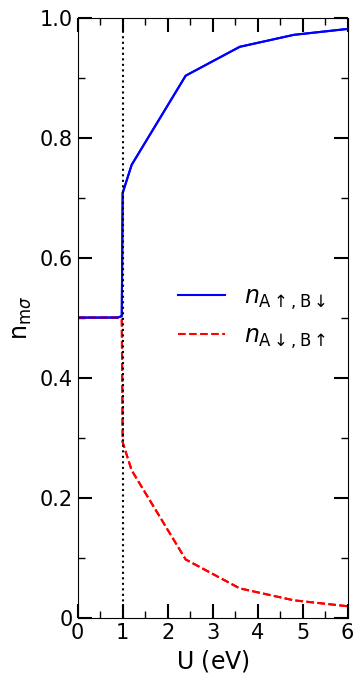

In [21]:
fig= plt.figure( figsize=(6, 6))

ax3 = fig.add_axes([0, 0, 0.45, 1])


G = np.array([0, 0])
X = np.array([np.pi, 0])
M = np.array([np.pi, np.pi])
path = [G, X, M, G]
labels = [r'$\Gamma$', r'$\text{X}$', r'$\text{M}$', r'$\Gamma$']
points_per_segment = 200


U=1.5
N_A = 0.620242
N_B = -0.620242
mu  = 0.364980

U2=3
N_A2 = 0.866006
N_B2 = -0.866006
mu2  = 1.198803

epsilo= 0 

k1=np.linspace(0,np.pi,100)
k0=np.full_like(k1,0) 
k2=np.full_like(k1,np.pi)
k3=np.linspace(np.pi,0,100)






ax3.plot(U_arr, n_up_A2_list, c='blue', label=r'$n_{\text{A}\uparrow,\text{B}\downarrow}$')
ax3.plot(U_arr, n_down_A2_list, c='red', linestyle='--')

ax3.plot(U_arr, n_up_B2_list, c='red', linestyle='--',label=r'$n_{\text{A}\downarrow,\text{B}\uparrow}$')
ax3.plot(U_arr, n_down_B2_list, c='blue')

    
ax3.axvline(x=1, linestyle=':', linewidth=1.5,color='black')


ax3.set_xlim(0,6)


#x_tick_positions=[0,1,2,3,4,5,6]
x_tick_labels=[0,1,2,3,4,5,6]
#ax3.set_xticks(x_tick_positions,x_tick_labels, fontsize=15)
# Major ticks at whole numbers
x_tick_positions_major=[0,1,2,3,4,5,6]
ax3.set_xticks(x_tick_positions_major,x_tick_labels,fontsize=15)

# Minor ticks at half numbers
x_tick_positions_minor=[0.5,1.5,2.5,3.5,4.5,5.5]
ax3.set_xticks(x_tick_positions_minor,[], minor=True)

# Style major vs minor ticks
ax3.tick_params(axis='x',
               which='major',
               direction='in',
               length=10, width=1.5, top=True, bottom=True)

ax3.tick_params(axis='x',
               which='minor',
               direction='in',
               length=5, width=1, top=True, bottom=True)



#y_tick_positions=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
y_tick_labels=[0,0.2,0.4,0.6,0.8,1.0]
#ax3.set_yticks(y_tick_positions,y_tick_labels, fontsize=15)

# Major ticks at whole numbers
y_tick_positions_major=[0,0.2,0.4,0.6,0.8,1.0]
ax3.set_yticks(y_tick_positions_major,y_tick_labels,fontsize=15)

# Minor ticks at half numbers
y_tick_positions_minor=[0.1,0.3,0.5,0.7,0.9]
ax3.set_yticks(y_tick_positions_minor,[], minor=True)

# Style major vs minor ticks
ax3.tick_params(axis='y',
               which='major',
               direction='in',
               length=10, width=1.5, left=True, right=True)

ax3.tick_params(axis='y',
               which='minor',
               direction='in',
               length=5, width=1, left=True, right=True)

ax3.set_ylim(0,1)
ax3.set_xlabel(r'$\text{U } (\text{eV})$',fontsize=17)
ax3.set_ylabel(r'$\text{n}_{\text{m}\sigma}$',fontsize=17)
ax3.legend(loc='right',framealpha=0.0,fontsize=17)



#plt.tight_layout()
plt.savefig('half filling n(U).pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()



## strain and doping

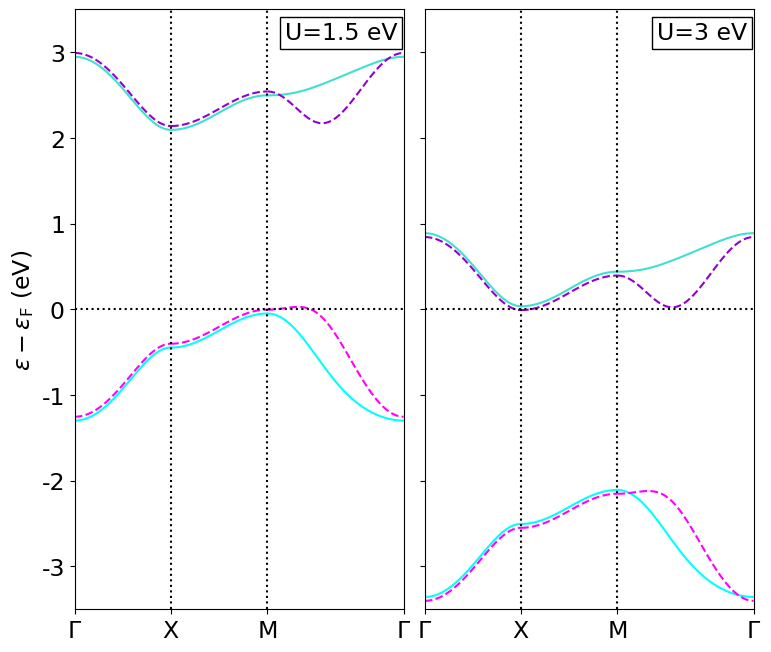

In [231]:
fig= plt.figure( figsize=(7, 6))


ax1 = fig.add_axes([0, 0, 0.47, 1])
ax2 = fig.add_axes([0.5, 0, 0.47, 1])

G = np.array([0, 0])
X = np.array([np.pi, 0])
M = np.array([np.pi, np.pi])
path = [G, X, M, G]
labels = [r'$\Gamma$', r'$\text{X}$', r'$\text{M}$', r'$\Gamma$']
points_per_segment = 200


#strain and doping
#n=0.985
U=3
N_A = 0.861571
N_B = -0.831570
mu  = -0.945686

#n=1.015
U2=3
N_A2 = 0.831679
N_B2 = -0.861695
mu2  = 1.156989

epsilo= 0.05 

k1=np.linspace(0,np.pi,100)
k0=np.full_like(k1,0) 
k2=np.full_like(k1,np.pi)
k3=np.linspace(np.pi,0,100)


E1=energy_split(k1, k0, N_A, N_B, U, mu, epsilo)
E2=energy_split(k2, k1, N_A, N_B, U, mu, epsilo)
E3=energy_split(k3, k3, N_A, N_B, U, mu, epsilo)


#plotting all bands for each path between high symmetry points
ax1.plot(np.linspace(0,1,100), E1[0], label=r'$\uparrow$, $\beta=+1$', color='turquoise')
ax1.plot(np.linspace(0,1,100), E1[1], label=r'$\uparrow$, $\beta=-1$ ', color='cyan')
ax1.plot(np.linspace(0,1,100), E1[2], '--',color='darkviolet')
ax1.plot(np.linspace(0,1,100), E1[3],'--', color='magenta')

ax1.plot(np.linspace(1,2,100), E2[0], color='turquoise')
ax1.plot(np.linspace(1,2,100), E2[1], color='cyan')
ax1.plot(np.linspace(1,2,100), E2[2], '--',color='darkviolet')
ax1.plot(np.linspace(1,2,100), E2[3],'--',  color='magenta')

ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[0], color='turquoise')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[1], color='cyan')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[2], '--',label=r'$\downarrow$, $\beta=+1$', color='darkviolet')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[3],'--', label=r'$\downarrow$, $\beta=-1$', color='magenta')




# Set custom x-axis ticks and labels
tick_positions = [0,1,2,2+np.sqrt(2)]
tick_labels = labels
ax1.set_xticks(tick_positions, tick_labels, fontsize=17)

y_tick_positions=[-3,-2,-1,0,1,2,3]
y_tick_labels=[-3,-2,-1,0,1,2,3]
ax1.set_yticks(y_tick_positions,y_tick_labels, fontsize=17)



# Dotted vertical line at x = 2
ax1.axvline(x=1, linestyle=':', linewidth=1.5,color='black')
ax1.axvline(x=2, linestyle=':', linewidth=1.5,color='black')

# Dotted horizontal line at y = 3
ax1.axhline(y=0, linestyle=':', linewidth=1.5,color='black')


ax1.text(
    0.98, 0.98,                    # x, y position in axes coordinates (0–1)
    'U=1.5 eV',              # text content
    transform=ax1.transAxes,        # interpret x,y as relative to the axes
    ha='right', va='top',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',         # border color
        linewidth=1,
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)

#plt.xlabel("k-path")
ax1.set_ylabel(r"$\epsilon-\epsilon_\text{F}\text{ }(\text{eV})$",fontsize=17)
#plt.title(f"Band Dispersion along High-Symmetry Path for $\epsilon$={epsilo}")
ax1.set_xlim(0,2+np.sqrt(2))
ax1.set_ylim(-3.5,3.5)
#plt.grid(True)
#ax1.legend(loc='upper left')



E12=energy_split(k1, k0, N_A2, N_B2, U2, mu2, epsilo)
E22=energy_split(k2, k1, N_A2, N_B2, U2, mu2, epsilo)
E32=energy_split(k3, k3, N_A2, N_B2, U2, mu2, epsilo)


#plotting all bands for each path between high symmetry points
ax2.plot(np.linspace(0,1,100), E12[0], label=r'$\uparrow$, $\beta=+1$', color='turquoise')
ax2.plot(np.linspace(0,1,100), E12[1], label=r'$\uparrow$, $\beta=-1$ ', color='cyan')
ax2.plot(np.linspace(0,1,100), E12[2], '--',color='darkviolet')
ax2.plot(np.linspace(0,1,100), E12[3],'--', color='magenta')

ax2.plot(np.linspace(1,2,100), E22[0], color='turquoise')
ax2.plot(np.linspace(1,2,100), E22[1], color='cyan')
ax2.plot(np.linspace(1,2,100), E22[2], '--',color='darkviolet')
ax2.plot(np.linspace(1,2,100), E22[3],'--',  color='magenta')

ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[0], color='turquoise')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[1], color='cyan')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[2], '--',label=r'$\downarrow$, $\beta=+1$', color='darkviolet')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[3],'--', label=r'$\downarrow$, $\beta=-1$', color='magenta')




# Set custom x-axis ticks and labels
tick_positions = [0,1,2,2+np.sqrt(2)]
tick_labels = labels
ax2.set_xticks(tick_positions, tick_labels, fontsize=17)

y_tick_positions=[-3,-2,-1,0,1,2,3]
y_tick_labels=[]
ax2.set_yticks(y_tick_positions,y_tick_labels, fontsize=15)



# Dotted vertical line at x = 2
ax2.axvline(x=1, linestyle=':', linewidth=1.5,color='black')
ax2.axvline(x=2, linestyle=':', linewidth=1.5,color='black')

# Dotted horizontal line at y = 3
ax2.axhline(y=0, linestyle=':', linewidth=1.5,color='black')


ax2.text(
    0.98, 0.98,                    # x, y position in axes coordinates (0–1)
    'U=3 eV',              # text content
    transform=ax2.transAxes,        # interpret x,y as relative to the axes
    ha='right', va='top',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',
        linewidth=1,         # border color
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)

#plt.xlabel("k-path")
#ax2.set_ylabel(r"$\epsilon-\epsilon_\text{F}\text{ }(\text{eV})$",fontsize=15)
#plt.title(f"Band Dispersion along High-Symmetry Path for $\epsilon$={epsilo}")
ax2.set_xlim(0,2+np.sqrt(2))
ax2.set_ylim(-3.5,3.5)
#plt.grid(True)
#ax2.legend(loc='upper left')






#plt.tight_layout()
plt.savefig('dispersion along path half filling U=1.5, U=3.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()



### spin dependent fillings computation

In [35]:
#k grid
n_k = 150
kx = np.linspace(-np.pi, np.pi, n_k)
ky = np.linspace(-np.pi, np.pi, n_k)
KX, KY = np.meshgrid(kx, ky)

# Initial values
eps=0.05
x = 0
U_arr = np.concatenate((np.linspace(0,0.9,5),np.linspace(0.92,1,5),np.linspace(1.2,6,5))) 


#starting mu
n_0=1.015
N_0=0
U_0=1



#self consistent
N_A_Ue=[]
N_B_Ue=[]
n_up_Ae_list=[]
n_down_Ae_list=[]
n_up_Be_list=[]
n_down_Be_list=[]
mu_Ue=[]

for U in U_arr:
    try:
        mu_0 = brentq(density_difference_total, -10, 10, args=(N_0,-N_0 ,U, n_0, T,eps), xtol=1e-5)
    except ValueError:
        print("mu not found")
    mu_current = mu_0
    N_A_current = 0.4
    N_B_current = -0.4
    for i in range(200):
        # Compute updated order parameters
        N_A_new = x * N_A_current + (1 - x) * order_param(N_A_current, N_B_current, U, mu_current, T,eps)
        N_B_new = x * N_B_current + (1 - x) * order_param2(N_A_current, N_B_current, U, mu_current, T,eps)

        # Update mu to maintain total density ~1
        try:
            mu_new = brentq(density_difference_total, -10, 10, args=(N_A_new, N_B_new, U, n_0, T,eps), xtol=1e-5)
        except ValueError:
            print("mu not found")
            break

        # Check total density
        n_new_A = n_e(N_A_new, N_B_new, U, mu_new, T, eps)
        n_new_B = n_e2(N_A_new, N_B_new, U, mu_new, T, eps)
        n_total = (n_new_A + n_new_B) / 2

        n_up_A=n_up(N_A_new,N_B_new,U,mu_new,T,eps)
        n_down_A=n_down(N_A_new,N_B_new,U,mu_new,T,eps)

        n_up_B=n_up2(N_A_new,N_B_new,U,mu_new,T,eps)
        n_down_B=n_down2(N_A_new,N_B_new,U,mu_new,T,eps)

        #print(f"step {i+1}: N_A = {N_A_new:.3f}, N_B = {N_B_new:.3f}, μ = {mu_new:.3f}, n = {n_total:.3f}")

        # Check convergence
        if (np.abs(N_A_new - N_A_current) +
            np.abs(N_B_new - N_B_current) +
            np.abs(n_total - n_0)) < 1e-4:
            print(f"✅ Converged in {i+1} steps.")
            break
        elif i+1==1000:
            print(f"Did not converge in {i+1} steps.")

        # Update for next step
        N_A_current = N_A_new
        N_B_current = N_B_new
        mu_current = mu_new
    N_A_Ue.append(N_A_current)
    N_B_Ue.append(N_B_current)
    n_up_Ae_list.append(n_up_A)
    n_down_Ae_list.append(n_down_A)
    n_up_Be_list.append(n_up_B)
    n_down_Be_list.append(n_down_B)
    mu_Ue.append(mu_current)


#print("\n📌 Final self-consistent results:")
#print(f"N_A = {N_A_current:.6f}")
#print(f"N_B = {N_B_current:.6f}")
#print(f"μ   = {mu_current:.6f}")
#print(f"n   = {(n_e(N_A_current, N_B_current, U, mu_current, T,eps) + n_e2(N_A_current, N_B_current, U, mu_current, T,eps)) / 2:.6f}")
#print(f"N_A + N_B = {N_A_current + N_B_current:.6e}")



print(N_A_Ue,N_B_Ue,mu_Ue)
N_A_U_arraye=np.array(N_A_Ue)
N_B_U_arraye=np.array(N_B_Ue)
mu_U_arraye=np.array(mu_Ue)


✅ Converged in 2 steps.
✅ Converged in 7 steps.
✅ Converged in 11 steps.
✅ Converged in 20 steps.
✅ Converged in 54 steps.
✅ Converged in 50 steps.
✅ Converged in 60 steps.
✅ Converged in 70 steps.
✅ Converged in 93 steps.
✅ Converged in 155 steps.
✅ Converged in 12 steps.
✅ Converged in 9 steps.
✅ Converged in 8 steps.
✅ Converged in 6 steps.
✅ Converged in 5 steps.
[np.float64(0.0), np.float64(1.877157729694129e-05), np.float64(4.948558736139233e-05), np.float64(6.317805933894992e-05), np.float64(0.0019175372609685725), np.float64(0.004292398255099971), np.float64(0.004562109241823124), np.float64(0.004994337852233246), np.float64(0.005439444273334921), np.float64(0.005975086366016245), np.float64(0.4712386566412805), np.float64(0.7697360032655823), np.float64(0.8701142693570896), np.float64(0.9113008741574712), np.float64(0.9315178520475967)] [np.float64(0.0), np.float64(-5.011003145438776e-05), np.float64(-9.253884679491683e-05), np.float64(-0.0001052912326727714), np.float64(-0.00

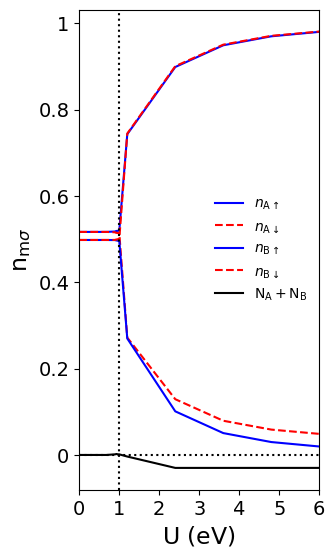

In [52]:
fig=plt.figure(figsize=(6, 6))

ax3=fig.add_axes([0.05,0.1,0.4,0.8])

#ax1.plot(U_arr, N_A_U_array2, marker='s', label=r'$N_\text{A}$')
#ax1.plot(U_arr, N_B_U_array2, marker='s', label=r'$N_\text{B}$')

ax3.plot(U_arr, n_up_Ae_list, c='blue', label=r'$n_{\text{A}\uparrow}$')
ax3.plot(U_arr, n_down_Ae_list, c='red', linestyle='--',label=r'$n_{\text{A}\downarrow}$')

ax3.plot(U_arr, n_up_Be_list, c='blue',label=r'$n_{\text{B}\uparrow}$')
ax3.plot(U_arr, n_down_Be_list, c='red',linestyle='--',label=r'$n_{\text{B}\downarrow}$')

ax3.plot(U_arr, np.array(n_up_Ae_list)-np.array(n_down_Ae_list)+np.array(n_up_Be_list)-np.array(n_down_Be_list),color='black',label=r'$\text{N}_\text{A}+\text{N}_\text{B}$')

    
ax3.axvline(x=1, linestyle=':', linewidth=1.5,color='black')
ax3.axhline(y=0, linestyle=':', linewidth=1.5,color='black')


ax3.set_xlim(0,6)


x_tick_positions=[0,1,2,3,4,5,6]
x_tick_labels=[0,1,2,3,4,5,6]
ax3.set_xticks(x_tick_positions,x_tick_labels, fontsize=14)

y_tick_positions=[0,0.2,0.4,0.6,0.8,1]
y_tick_labels=[0,0.2,0.4,0.6,0.8,1]
ax3.set_yticks(y_tick_positions,y_tick_labels, fontsize=14)

ax3.set_xlabel(r'$\text{U } (\text{eV})$',fontsize=17)
ax3.set_ylabel(r'$\text{n}_{\text{m}\sigma}$',fontsize=17)
ax3.legend(loc='right',framealpha=0.0)



# === Legend ===
#from matplotlib.lines import Line2D
#legend_elements = [
#    Line2D([0], [0], color='red', label=r'$\uparrow, \beta=+1$'),
#    Line2D([0], [0], color='red', linestyle='dashed', label=r'$\uparrow, \beta=-1$'),
#    Line2D([0], [0], color='blue', label=r'$\downarrow, \beta=+1$'),
#    Line2D([0], [0], color='blue', linestyle='dashed', label=r'$\downarrow, \beta=-1$')]



#plt.savefig('fermi surface at Us and N and U 2.png', bbox_inches='tight', pad_inches=0.1)
plt.show()


In [36]:
#k grid
n_k = 150
kx = np.linspace(-np.pi, np.pi, n_k)
ky = np.linspace(-np.pi, np.pi, n_k)
KX, KY = np.meshgrid(kx, ky)

# Initial values
eps=0.05
x = 0
U_arr = np.concatenate((np.linspace(0,0.9,5),np.linspace(0.92,1,5),np.linspace(1.2,6,5))) 


#starting mu
n_0=0.985
N_0=0
U_0=1



#self consistent
N_A_Uh=[]
N_B_Uh=[]
n_up_Ah_list=[]
n_down_Ah_list=[]
n_up_Bh_list=[]
n_down_Bh_list=[]
mu_Uh=[]

for U in U_arr:
    try:
        mu_0 = brentq(density_difference_total, -10, 10, args=(N_0,-N_0 ,U, n_0, T,eps), xtol=1e-5)
    except ValueError:
        print("mu not found")
    mu_current = mu_0
    N_A_current = 0.4
    N_B_current = -0.4
    for i in range(200):
        # Compute updated order parameters
        N_A_new = x * N_A_current + (1 - x) * order_param(N_A_current, N_B_current, U, mu_current, T,eps)
        N_B_new = x * N_B_current + (1 - x) * order_param2(N_A_current, N_B_current, U, mu_current, T,eps)

        # Update mu to maintain total density ~1
        try:
            mu_new = brentq(density_difference_total, -10, 10, args=(N_A_new, N_B_new, U, n_0, T,eps), xtol=1e-5)
        except ValueError:
            print("mu not found")
            break

        # Check total density
        n_new_A = n_e(N_A_new, N_B_new, U, mu_new, T, eps)
        n_new_B = n_e2(N_A_new, N_B_new, U, mu_new, T, eps)
        n_total = (n_new_A + n_new_B) / 2

        n_up_A=n_up(N_A_new,N_B_new,U,mu_new,T,eps)
        n_down_A=n_down(N_A_new,N_B_new,U,mu_new,T,eps)

        n_up_B=n_up2(N_A_new,N_B_new,U,mu_new,T,eps)
        n_down_B=n_down2(N_A_new,N_B_new,U,mu_new,T,eps)

        #print(f"step {i+1}: N_A = {N_A_new:.3f}, N_B = {N_B_new:.3f}, μ = {mu_new:.3f}, n = {n_total:.3f}")

        # Check convergence
        if (np.abs(N_A_new - N_A_current) +
            np.abs(N_B_new - N_B_current) +
            np.abs(n_total - n_0)) < 1e-4:
            print(f"✅ Converged in {i+1} steps.")
            break
        elif i+1==1000:
            print(f"Did not converge in {i+1} steps.")

        # Update for next step
        N_A_current = N_A_new
        N_B_current = N_B_new
        mu_current = mu_new
    N_A_Uh.append(N_A_current)
    N_B_Uh.append(N_B_current)
    n_up_Ah_list.append(n_up_A)
    n_down_Ah_list.append(n_down_A)
    n_up_Bh_list.append(n_up_B)
    n_down_Bh_list.append(n_down_B)
    mu_Uh.append(mu_current)


#print("\n📌 Final self-consistent results:")
#print(f"N_A = {N_A_current:.6f}")
#print(f"N_B = {N_B_current:.6f}")
#print(f"μ   = {mu_current:.6f}")
#print(f"n   = {(n_e(N_A_current, N_B_current, U, mu_current, T,eps) + n_e2(N_A_current, N_B_current, U, mu_current, T,eps)) / 2:.6f}")
#print(f"N_A + N_B = {N_A_current + N_B_current:.6e}")



print(N_A_Uh,N_B_Uh,mu_Uh)
N_A_U_arrayh=np.array(N_A_Uh)
N_B_U_arrayh=np.array(N_B_Uh)
mu_U_arrayh=np.array(mu_Uh)


✅ Converged in 2 steps.
✅ Converged in 8 steps.
✅ Converged in 13 steps.
✅ Converged in 18 steps.
✅ Converged in 44 steps.
✅ Converged in 50 steps.
✅ Converged in 60 steps.
✅ Converged in 73 steps.
✅ Converged in 98 steps.
✅ Converged in 117 steps.
✅ Converged in 11 steps.
✅ Converged in 9 steps.
✅ Converged in 7 steps.
✅ Converged in 6 steps.
✅ Converged in 5 steps.
[np.float64(0.0), np.float64(8.2816230114841e-06), np.float64(6.188637256069811e-05), np.float64(0.0006464153254580712), np.float64(0.0010361192585643926), np.float64(0.001126368977602341), np.float64(0.0011735006925579442), np.float64(0.0012755060863213154), np.float64(0.001376308962964776), np.float64(0.0062696934415924594), np.float64(0.4885330133474109), np.float64(0.7996852840435001), np.float64(0.8993254924272799), np.float64(0.9404927598348729), np.float64(0.9609452910737734)] [np.float64(0.0), np.float64(-2.9978961893570905e-05), np.float64(-9.489686053747439e-05), np.float64(-0.0003489464302388978), np.float64(-0.

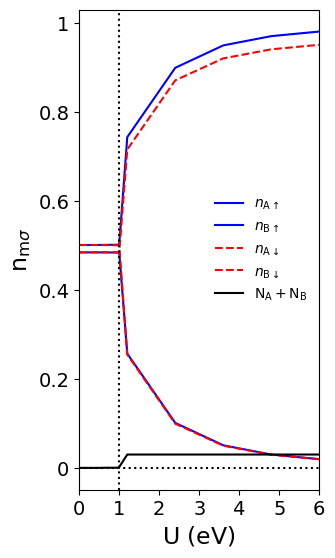

In [56]:
fig=plt.figure(figsize=(6, 6))

ax3=fig.add_axes([0.05,0.1,0.4,0.8])

#ax1.plot(U_arr, N_A_U_array2, marker='s', label=r'$N_\text{A}$')
#ax1.plot(U_arr, N_B_U_array2, marker='s', label=r'$N_\text{B}$')

ax3.plot(U_arr, n_up_Ah_list, c='blue', label=r'$n_{\text{A}\uparrow}$')


ax3.plot(U_arr, n_up_Bh_list, c='blue',label=r'$n_{\text{B}\uparrow}$')
ax3.plot(U_arr, n_down_Ah_list, c='red', linestyle='--',label=r'$n_{\text{A}\downarrow}$')
ax3.plot(U_arr, n_down_Bh_list, c='red',linestyle='--',label=r'$n_{\text{B}\downarrow}$')

ax3.plot(U_arr, np.array(n_up_Ah_list)-np.array(n_down_Ah_list)+np.array(n_up_Bh_list)-np.array(n_down_Bh_list),color='black',label=r'$\text{N}_\text{A}+\text{N}_\text{B}$')

    
ax3.axvline(x=1, linestyle=':', linewidth=1.5,color='black')
ax3.axhline(y=0, linestyle=':', linewidth=1.5,color='black')


ax3.set_xlim(0,6)


x_tick_positions=[0,1,2,3,4,5,6]
x_tick_labels=[0,1,2,3,4,5,6]
ax3.set_xticks(x_tick_positions,x_tick_labels, fontsize=14)

y_tick_positions=[0,0.2,0.4,0.6,0.8,1]
y_tick_labels=[0,0.2,0.4,0.6,0.8,1]
ax3.set_yticks(y_tick_positions,y_tick_labels, fontsize=14)

ax3.set_xlabel(r'$\text{U } (\text{eV})$',fontsize=17)
ax3.set_ylabel(r'$\text{n}_{\text{m}\sigma}$',fontsize=17)
ax3.legend(loc='right',framealpha=0.0)



# === Legend ===
#from matplotlib.lines import Line2D
#legend_elements = [
#    Line2D([0], [0], color='red', label=r'$\uparrow, \beta=+1$'),
#    Line2D([0], [0], color='red', linestyle='dashed', label=r'$\uparrow, \beta=-1$'),
#    Line2D([0], [0], color='blue', label=r'$\downarrow, \beta=+1$'),
#    Line2D([0], [0], color='blue', linestyle='dashed', label=r'$\downarrow, \beta=-1$')]



#plt.savefig('fermi surface at Us and N and U 2.png', bbox_inches='tight', pad_inches=0.1)
plt.show()


### Plots

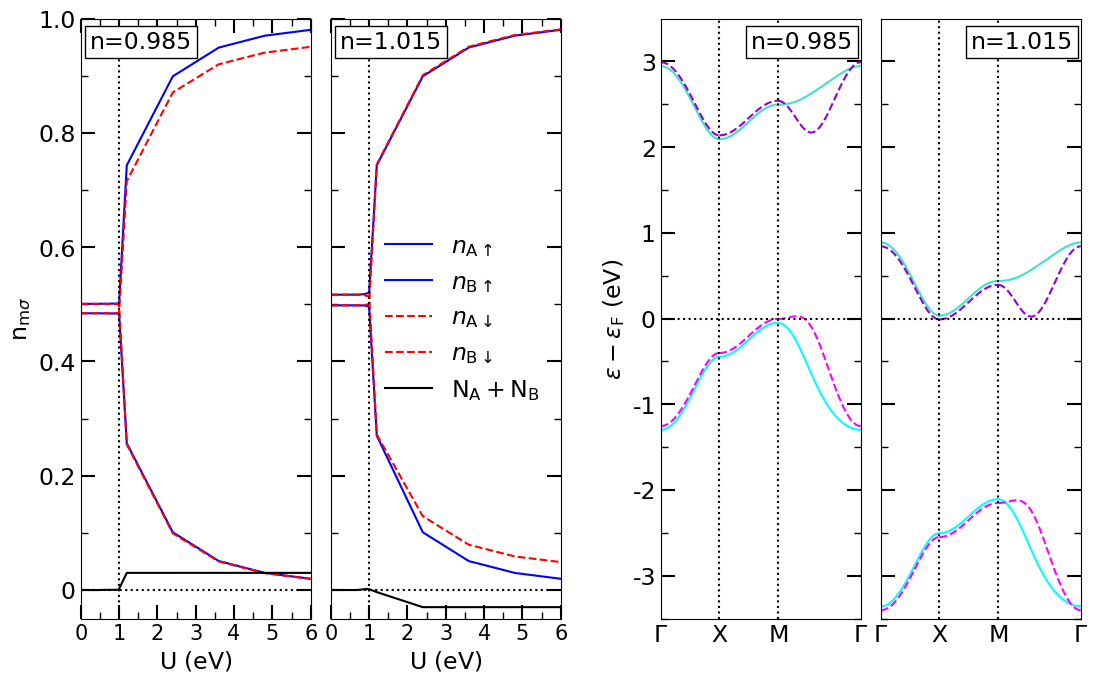

In [58]:
fig= plt.figure( figsize=(10, 6))

ax3 = fig.add_axes([0, 0, 0.23, 1])
ax4 = fig.add_axes([0.25, 0, 0.23, 1])
ax1 = fig.add_axes([0.58, 0, 0.2, 1])
ax2 = fig.add_axes([0.8, 0, 0.2, 1])

G = np.array([0, 0])
X = np.array([np.pi, 0])
M = np.array([np.pi, np.pi])
path = [G, X, M, G]
labels = [r'$\Gamma$', r'$\text{X}$', r'$\text{M}$', r'$\Gamma$']
points_per_segment = 200


#strain and doping
#n=0.985
U=3
N_A = 0.861571
N_B = -0.831570
mu  = -0.945686

#n=1.015
U2=3
N_A2 = 0.831679
N_B2 = -0.861695
mu2  = 1.156989

epsilo= 0.05 

k1=np.linspace(0,np.pi,100)
k0=np.full_like(k1,0) 
k2=np.full_like(k1,np.pi)
k3=np.linspace(np.pi,0,100)


E1=energy_split(k1, k0, N_A, N_B, U, mu, epsilo)
E2=energy_split(k2, k1, N_A, N_B, U, mu, epsilo)
E3=energy_split(k3, k3, N_A, N_B, U, mu, epsilo)


#plotting all bands for each path between high symmetry points
ax1.plot(np.linspace(0,1,100), E1[0], label=r'$\uparrow$, $\beta=+1$', color='turquoise')
ax1.plot(np.linspace(0,1,100), E1[1], label=r'$\uparrow$, $\beta=-1$ ', color='cyan')
ax1.plot(np.linspace(0,1,100), E1[2], '--',color='darkviolet')
ax1.plot(np.linspace(0,1,100), E1[3],'--', color='magenta')

ax1.plot(np.linspace(1,2,100), E2[0], color='turquoise')
ax1.plot(np.linspace(1,2,100), E2[1], color='cyan')
ax1.plot(np.linspace(1,2,100), E2[2], '--',color='darkviolet')
ax1.plot(np.linspace(1,2,100), E2[3],'--',  color='magenta')

ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[0], color='turquoise')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[1], color='cyan')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[2], '--',label=r'$\downarrow$, $\beta=+1$', color='darkviolet')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[3],'--', label=r'$\downarrow$, $\beta=-1$', color='magenta')




# Set custom x-axis ticks and labels
tick_positions = [0,1,2,2+np.sqrt(2)]
tick_labels = labels
ax1.set_xticks(tick_positions, tick_labels, fontsize=17)

ax1.tick_params(axis='x',length=0)


#y_tick_positions=[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3]
y_tick_labels=[-3,-2,-1,0,1,2,3]
#ax1.set_yticks(y_tick_positions,y_tick_labels, fontsize=17)

# Major ticks at whole numbers
y_tick_positions_major=[-3,-2,-1,0,1,2,3]
ax1.set_yticks(y_tick_positions_major,y_tick_labels,fontsize=17)

# Minor ticks at half numbers
y_tick_positions_minor=[-3.5,-2.5,-1.5,-0.5,0.5,1.5,2.5]
ax1.set_yticks(y_tick_positions_minor,[], minor=True)

# Style major vs minor ticks
ax1.tick_params(axis='y',which='major',direction='in',length=10, width=1.5, left=True, right=True)

ax1.tick_params(axis='y',which='minor',direction='in',length=5, width=1, left=True, right=True)

# Dotted vertical line at x = 2
ax1.axvline(x=1, linestyle=':', linewidth=1.5,color='black')
ax1.axvline(x=2, linestyle=':', linewidth=1.5,color='black')

# Dotted horizontal line at y = 3
ax1.axhline(y=0, linestyle=':', linewidth=1.5,color='black')


ax1.text(
    0.96, 0.98,                    # x, y position in axes coordinates (0–1)
    'n=0.985',              # text content
    transform=ax1.transAxes,        # interpret x,y as relative to the axes
    ha='right', va='top',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',         # border color
        linewidth=1,
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)

#plt.xlabel("k-path")
ax1.set_ylabel(r"$\epsilon-\epsilon_\text{F}\text{ }(\text{eV})$",fontsize=17)
#plt.title(f"Band Dispersion along High-Symmetry Path for $\epsilon$={epsilo}")
ax1.set_xlim(0,2+np.sqrt(2))
ax1.set_ylim(-3.5,3.5)
#plt.grid(True)
#ax1.legend(loc='upper left')



E12=energy_split(k1, k0, N_A2, N_B2, U2, mu2, epsilo)
E22=energy_split(k2, k1, N_A2, N_B2, U2, mu2, epsilo)
E32=energy_split(k3, k3, N_A2, N_B2, U2, mu2, epsilo)


#plotting all bands for each path between high symmetry points
ax2.plot(np.linspace(0,1,100), E12[0], label=r'$\uparrow$, $\beta=+1$', color='turquoise')
ax2.plot(np.linspace(0,1,100), E12[1], label=r'$\uparrow$, $\beta=-1$ ', color='cyan')
ax2.plot(np.linspace(0,1,100), E12[2], '--',color='darkviolet')
ax2.plot(np.linspace(0,1,100), E12[3],'--', color='magenta')

ax2.plot(np.linspace(1,2,100), E22[0], color='turquoise')
ax2.plot(np.linspace(1,2,100), E22[1], color='cyan')
ax2.plot(np.linspace(1,2,100), E22[2], '--',color='darkviolet')
ax2.plot(np.linspace(1,2,100), E22[3],'--',  color='magenta')

ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[0], color='turquoise')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[1], color='cyan')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[2], '--',label=r'$\downarrow$, $\beta=+1$', color='darkviolet')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[3],'--', label=r'$\downarrow$, $\beta=-1$', color='magenta')




# Set custom x-axis ticks and labels
tick_positions = [0,1,2,2+np.sqrt(2)]
tick_labels = labels
ax2.set_xticks(tick_positions, tick_labels, fontsize=17)

ax2.tick_params(axis='x',length=0)

#y_tick_positions=[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3]
#y_tick_labels=[]
#ax2.set_yticks(y_tick_positions,y_tick_labels, fontsize=15)

# Major ticks at whole numbers
y_tick_positions_major=[-3,-2,-1,0,1,2,3]
ax2.set_yticks(y_tick_positions_major,[],fontsize=17)

# Minor ticks at half numbers
y_tick_positions_minor=[-3.5,-2.5,-1.5,-0.5,0.5,1.5,2.5]
ax2.set_yticks(y_tick_positions_minor,[], minor=True)

# Style major vs minor ticks
ax2.tick_params(axis='y',which='major',direction='in',length=10, width=1.5, left=True, right=True)

ax2.tick_params(axis='y',which='minor',direction='in',length=5, width=1, left=True, right=True)

# Dotted vertical line at x = 2
ax2.axvline(x=1, linestyle=':', linewidth=1.5,color='black')
ax2.axvline(x=2, linestyle=':', linewidth=1.5,color='black')

# Dotted horizontal line at y = 3
ax2.axhline(y=0, linestyle=':', linewidth=1.5,color='black')


ax2.text(
    0.96, 0.98,                    # x, y position in axes coordinates (0–1)
    'n=1.015',              # text content
    transform=ax2.transAxes,        # interpret x,y as relative to the axes
    ha='right', va='top',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',
        linewidth=1,         # border color
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)

#plt.xlabel("k-path")
#ax2.set_ylabel(r"$\epsilon-\epsilon_\text{F}\text{ }(\text{eV})$",fontsize=15)
#plt.title(f"Band Dispersion along High-Symmetry Path for $\epsilon$={epsilo}")
ax2.set_xlim(0,2+np.sqrt(2))
ax2.set_ylim(-3.5,3.5)
#plt.grid(True)
#ax2.legend(loc='upper left')


ax3.plot(U_arr, n_up_Ah_list, c='blue', label=r'$n_{\text{A}\uparrow}$')
ax3.plot(U_arr, n_up_Bh_list, c='blue',label=r'$n_{\text{B}\uparrow}$')
ax3.plot(U_arr, n_down_Ah_list, c='red', linestyle='--',label=r'$n_{\text{A}\downarrow}$')
ax3.plot(U_arr, n_down_Bh_list, c='red',linestyle='--',label=r'$n_{\text{B}\downarrow}$')

ax3.plot(U_arr, np.array(n_up_Ah_list)-np.array(n_down_Ah_list)+np.array(n_up_Bh_list)-np.array(n_down_Bh_list),color='black',label=r'$\text{N}_\text{A}+\text{N}_\text{B}$')

    
ax3.axvline(x=1, linestyle=':', linewidth=1.5,color='black')
ax3.axhline(y=0, linestyle=':', linewidth=1.5,color='black')

ax3.set_xlim(0,6)


#x_tick_positions=[0,1,2,3,4,5,6]
x_tick_labels=[0,1,2,3,4,5,6]
#ax3.set_xticks(x_tick_positions,x_tick_labels, fontsize=15)
# Major ticks at whole numbers
x_tick_positions_major=[0,1,2,3,4,5,6]
ax3.set_xticks(x_tick_positions_major,x_tick_labels,fontsize=15)

# Minor ticks at half numbers
x_tick_positions_minor=[0.5,1.5,2.5,3.5,4.5,5.5]
ax3.set_xticks(x_tick_positions_minor,[], minor=True)

# Style major vs minor ticks
ax3.tick_params(axis='x',
               which='major',
               direction='in',
               length=10, width=1.5, top=True, bottom=True)

ax3.tick_params(axis='x',
               which='minor',
               direction='in',
               length=5, width=1, top=True, bottom=True)


#y_tick_positions=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
y_tick_labels=[0,0.2,0.4,0.6,0.8,1.0]
#ax3.set_yticks(y_tick_positions,y_tick_labels, fontsize=15)

# Major ticks at whole numbers
y_tick_positions_major=[0,0.2,0.4,0.6,0.8,1.0]
ax3.set_yticks(y_tick_positions_major,y_tick_labels,fontsize=17)

# Minor ticks at half numbers
y_tick_positions_minor=[0.1,0.3,0.5,0.7,0.9]
ax3.set_yticks(y_tick_positions_minor,[], minor=True)

# Style major vs minor ticks
ax3.tick_params(axis='y',
               which='major',
               direction='in',
               length=10, width=1.5, left=True, right=True)

ax3.tick_params(axis='y',
               which='minor',
               direction='in',
               length=5, width=1, left=True, right=True)



ax3.text(
    0.04, 0.98,                    # x, y position in axes coordinates (0–1)
    'n=0.985',              # text content
    transform=ax3.transAxes,        # interpret x,y as relative to the axes
    ha='left', va='top',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',
        linewidth=1,         # border color
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)

ax3.set_ylim(-0.05,1)
ax3.set_xlabel(r'$\text{U } (\text{eV})$',fontsize=17)
ax3.set_ylabel(r'$\text{n}_{\text{m}\sigma}$',fontsize=17)
#ax3.legend(loc='right',framealpha=0.0,fontsize=17)






ax4.plot(U_arr, n_up_Ae_list, c='blue', label=r'$n_{\text{A}\uparrow}$')
ax4.plot(U_arr, n_up_Be_list, c='blue',label=r'$n_{\text{B}\uparrow}$')
ax4.plot(U_arr, n_down_Ae_list, c='red', linestyle='--',label=r'$n_{\text{A}\downarrow}$')
ax4.plot(U_arr, n_down_Be_list, c='red',linestyle='--',label=r'$n_{\text{B}\downarrow}$')

ax4.plot(U_arr, np.array(n_up_Ae_list)-np.array(n_down_Ae_list)+np.array(n_up_Be_list)-np.array(n_down_Be_list),color='black',label=r'$\text{N}_\text{A}+\text{N}_\text{B}$')


ax4.axvline(x=1, linestyle=':', linewidth=1.5,color='black')
ax4.axhline(y=0, linestyle=':', linewidth=1.5,color='black')

ax4.set_xlim(0,6)


#x_tick_positions=[0,1,2,3,4,5,6]
x_tick_labels=[0,1,2,3,4,5,6]
#ax3.set_xticks(x_tick_positions,x_tick_labels, fontsize=15)
# Major ticks at whole numbers
x_tick_positions_major=[0,1,2,3,4,5,6]
ax4.set_xticks(x_tick_positions_major,x_tick_labels,fontsize=15)

# Minor ticks at half numbers
x_tick_positions_minor=[0.5,1.5,2.5,3.5,4.5,5.5]
ax4.set_xticks(x_tick_positions_minor,[], minor=True)

# Style major vs minor ticks
ax4.tick_params(axis='x',
               which='major',
               direction='in',
               length=10, width=1.5, top=True, bottom=True)

ax4.tick_params(axis='x',
               which='minor',
               direction='in',
               length=5, width=1, top=True, bottom=True)

#y_tick_positions=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
y_tick_labels=[]
#ax4.set_yticks(y_tick_positions,y_tick_labels, fontsize=15)

# Major ticks at whole numbers
y_tick_positions_major=[0,0.2,0.4,0.6,0.8,1.0]
ax4.set_yticks(y_tick_positions_major,y_tick_labels,fontsize=15)

# Minor ticks at half numbers
y_tick_positions_minor=[0.1,0.3,0.5,0.7,0.9]
ax4.set_yticks(y_tick_positions_minor,y_tick_labels, minor=True)

# Style major vs minor ticks
ax4.tick_params(axis='y',which='major',direction='in',length=10, width=1.5, left=True, right=True)

ax4.tick_params(axis='y',which='minor',direction='in',length=5, width=1, left=True, right=True)



ax4.text(
    0.04, 0.98,                    # x, y position in axes coordinates (0–1)
    'n=1.015',              # text content
    transform=ax4.transAxes,        # interpret x,y as relative to the axes
    ha='left', va='top',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',
        linewidth=1,         # border color
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)

ax4.set_ylim(-0.05,1)
ax4.set_xlabel(r'$\text{U } (\text{eV})$',fontsize=17)
#ax4.set_ylabel(r'$\text{n}_{\text{m}\sigma}$',fontsize=17)
ax4.legend(loc='right',framealpha=0.0,fontsize=17)




#plt.tight_layout()
plt.savefig('doping and strain 0.05 n(U) and dispersion along path.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()



### Figures seperate

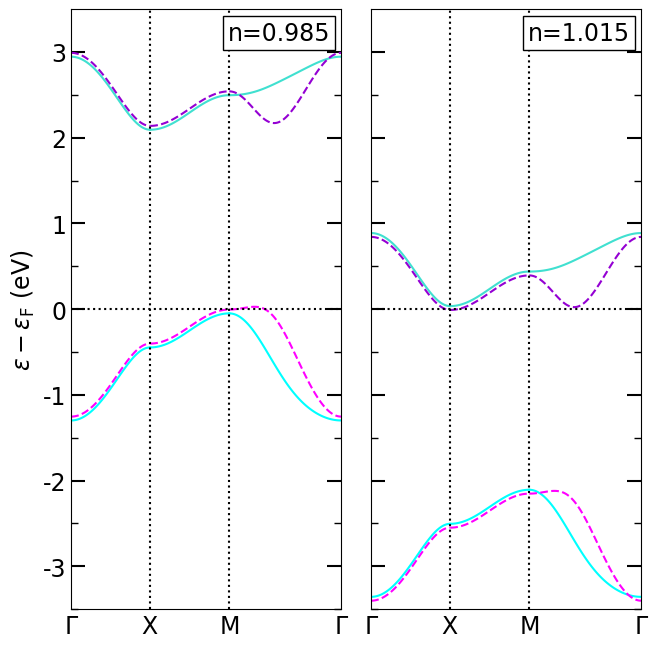

In [33]:
fig= plt.figure( figsize=(6, 6))

ax1 = fig.add_axes([0, 0, 0.45, 1])
ax2 = fig.add_axes([0.5, 0, 0.45, 1])

G = np.array([0, 0])
X = np.array([np.pi, 0])
M = np.array([np.pi, np.pi])
path = [G, X, M, G]
labels = [r'$\Gamma$', r'$\text{X}$', r'$\text{M}$', r'$\Gamma$']
points_per_segment = 200


#strain and doping
#n=0.985
U=3
N_A = 0.861571
N_B = -0.831570
mu  = -0.945686

#n=1.015
U2=3
N_A2 = 0.831679
N_B2 = -0.861695
mu2  = 1.156989

epsilo= 0.05 

k1=np.linspace(0,np.pi,100)
k0=np.full_like(k1,0) 
k2=np.full_like(k1,np.pi)
k3=np.linspace(np.pi,0,100)


E1=energy_split(k1, k0, N_A, N_B, U, mu, epsilo)
E2=energy_split(k2, k1, N_A, N_B, U, mu, epsilo)
E3=energy_split(k3, k3, N_A, N_B, U, mu, epsilo)


#plotting all bands for each path between high symmetry points
ax1.plot(np.linspace(0,1,100), E1[0], label=r'$\uparrow$, $\beta=+1$', color='turquoise')
ax1.plot(np.linspace(0,1,100), E1[1], label=r'$\uparrow$, $\beta=-1$ ', color='cyan')
ax1.plot(np.linspace(0,1,100), E1[2], '--',color='darkviolet')
ax1.plot(np.linspace(0,1,100), E1[3],'--', color='magenta')

ax1.plot(np.linspace(1,2,100), E2[0], color='turquoise')
ax1.plot(np.linspace(1,2,100), E2[1], color='cyan')
ax1.plot(np.linspace(1,2,100), E2[2], '--',color='darkviolet')
ax1.plot(np.linspace(1,2,100), E2[3],'--',  color='magenta')

ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[0], color='turquoise')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[1], color='cyan')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[2], '--',label=r'$\downarrow$, $\beta=+1$', color='darkviolet')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[3],'--', label=r'$\downarrow$, $\beta=-1$', color='magenta')




# Set custom x-axis ticks and labels
tick_positions = [0,1,2,2+np.sqrt(2)]
tick_labels = labels
ax1.set_xticks(tick_positions, tick_labels, fontsize=17)

ax1.tick_params(axis='x',length=0)


#y_tick_positions=[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3]
y_tick_labels=[-3,-2,-1,0,1,2,3]
#ax1.set_yticks(y_tick_positions,y_tick_labels, fontsize=17)

# Major ticks at whole numbers
y_tick_positions_major=[-3,-2,-1,0,1,2,3]
ax1.set_yticks(y_tick_positions_major,y_tick_labels,fontsize=17)

# Minor ticks at half numbers
y_tick_positions_minor=[-3.5,-2.5,-1.5,-0.5,0.5,1.5,2.5]
ax1.set_yticks(y_tick_positions_minor,[], minor=True)

# Style major vs minor ticks
ax1.tick_params(axis='y',which='major',direction='in',length=10, width=1.5, left=True, right=True)

ax1.tick_params(axis='y',which='minor',direction='in',length=5, width=1, left=True, right=True)

# Dotted vertical line at x = 2
ax1.axvline(x=1, linestyle=':', linewidth=1.5,color='black')
ax1.axvline(x=2, linestyle=':', linewidth=1.5,color='black')

# Dotted horizontal line at y = 3
ax1.axhline(y=0, linestyle=':', linewidth=1.5,color='black')


ax1.text(
    0.96, 0.98,                    # x, y position in axes coordinates (0–1)
    'n=0.985',              # text content
    transform=ax1.transAxes,        # interpret x,y as relative to the axes
    ha='right', va='top',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',         # border color
        linewidth=1,
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)

#plt.xlabel("k-path")
ax1.set_ylabel(r"$\epsilon-\epsilon_\text{F}\text{ }(\text{eV})$",fontsize=17)
#plt.title(f"Band Dispersion along High-Symmetry Path for $\epsilon$={epsilo}")
ax1.set_xlim(0,2+np.sqrt(2))
ax1.set_ylim(-3.5,3.5)
#plt.grid(True)
#ax1.legend(loc='upper left')



E12=energy_split(k1, k0, N_A2, N_B2, U2, mu2, epsilo)
E22=energy_split(k2, k1, N_A2, N_B2, U2, mu2, epsilo)
E32=energy_split(k3, k3, N_A2, N_B2, U2, mu2, epsilo)


#plotting all bands for each path between high symmetry points
ax2.plot(np.linspace(0,1,100), E12[0], label=r'$\uparrow$, $\beta=+1$', color='turquoise')
ax2.plot(np.linspace(0,1,100), E12[1], label=r'$\uparrow$, $\beta=-1$ ', color='cyan')
ax2.plot(np.linspace(0,1,100), E12[2], '--',color='darkviolet')
ax2.plot(np.linspace(0,1,100), E12[3],'--', color='magenta')

ax2.plot(np.linspace(1,2,100), E22[0], color='turquoise')
ax2.plot(np.linspace(1,2,100), E22[1], color='cyan')
ax2.plot(np.linspace(1,2,100), E22[2], '--',color='darkviolet')
ax2.plot(np.linspace(1,2,100), E22[3],'--',  color='magenta')

ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[0], color='turquoise')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[1], color='cyan')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[2], '--',label=r'$\downarrow$, $\beta=+1$', color='darkviolet')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[3],'--', label=r'$\downarrow$, $\beta=-1$', color='magenta')




# Set custom x-axis ticks and labels
tick_positions = [0,1,2,2+np.sqrt(2)]
tick_labels = labels
ax2.set_xticks(tick_positions, tick_labels, fontsize=17)

ax2.tick_params(axis='x',length=0)

#y_tick_positions=[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3]
#y_tick_labels=[]
#ax2.set_yticks(y_tick_positions,y_tick_labels, fontsize=15)

# Major ticks at whole numbers
y_tick_positions_major=[-3,-2,-1,0,1,2,3]
ax2.set_yticks(y_tick_positions_major,[],fontsize=17)

# Minor ticks at half numbers
y_tick_positions_minor=[-3.5,-2.5,-1.5,-0.5,0.5,1.5,2.5]
ax2.set_yticks(y_tick_positions_minor,[], minor=True)

# Style major vs minor ticks
ax2.tick_params(axis='y',which='major',direction='in',length=10, width=1.5, left=True, right=True)

ax2.tick_params(axis='y',which='minor',direction='in',length=5, width=1, left=True, right=True)

# Dotted vertical line at x = 2
ax2.axvline(x=1, linestyle=':', linewidth=1.5,color='black')
ax2.axvline(x=2, linestyle=':', linewidth=1.5,color='black')

# Dotted horizontal line at y = 3
ax2.axhline(y=0, linestyle=':', linewidth=1.5,color='black')


ax2.text(
    0.96, 0.98,                    # x, y position in axes coordinates (0–1)
    'n=1.015',              # text content
    transform=ax2.transAxes,        # interpret x,y as relative to the axes
    ha='right', va='top',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',
        linewidth=1,         # border color
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)

#plt.xlabel("k-path")
#ax2.set_ylabel(r"$\epsilon-\epsilon_\text{F}\text{ }(\text{eV})$",fontsize=15)
#plt.title(f"Band Dispersion along High-Symmetry Path for $\epsilon$={epsilo}")
ax2.set_xlim(0,2+np.sqrt(2))
ax2.set_ylim(-3.5,3.5)
#plt.grid(True)
#ax2.legend(loc='upper left')
plt.savefig('doping and strain 0.05 dispersion.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

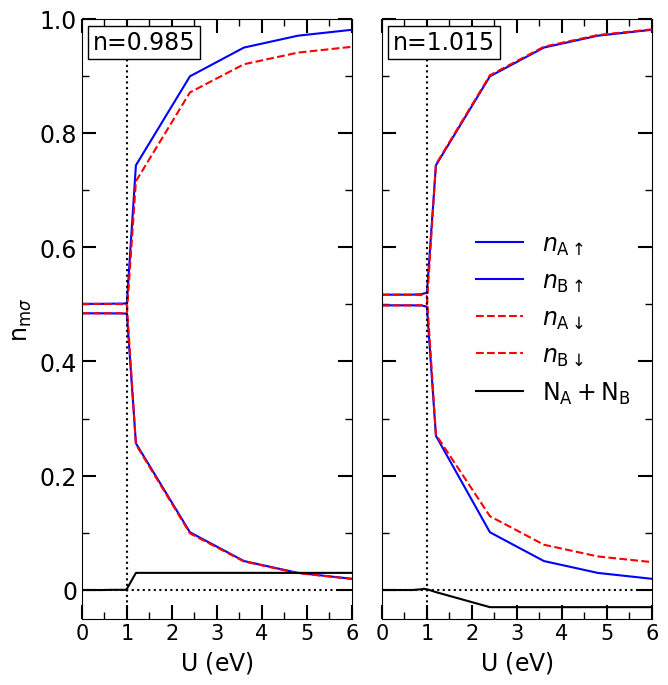

In [37]:
fig= plt.figure( figsize=(6, 6))

ax3 = fig.add_axes([0, 0, 0.45, 1])
ax4 = fig.add_axes([0.5, 0, 0.45, 1])


ax3.plot(U_arr, n_up_Ah_list, c='blue', label=r'$n_{\text{A}\uparrow}$')
ax3.plot(U_arr, n_up_Bh_list, c='blue',label=r'$n_{\text{B}\uparrow}$')
ax3.plot(U_arr, n_down_Ah_list, c='red', linestyle='--',label=r'$n_{\text{A}\downarrow}$')
ax3.plot(U_arr, n_down_Bh_list, c='red',linestyle='--',label=r'$n_{\text{B}\downarrow}$')

ax3.plot(U_arr, np.array(n_up_Ah_list)-np.array(n_down_Ah_list)+np.array(n_up_Bh_list)-np.array(n_down_Bh_list),color='black',label=r'$\text{N}_\text{A}+\text{N}_\text{B}$')

    
ax3.axvline(x=1, linestyle=':', linewidth=1.5,color='black')
ax3.axhline(y=0, linestyle=':', linewidth=1.5,color='black')

ax3.set_xlim(0,6)


#x_tick_positions=[0,1,2,3,4,5,6]
x_tick_labels=[0,1,2,3,4,5,6]
#ax3.set_xticks(x_tick_positions,x_tick_labels, fontsize=15)
# Major ticks at whole numbers
x_tick_positions_major=[0,1,2,3,4,5,6]
ax3.set_xticks(x_tick_positions_major,x_tick_labels,fontsize=15)

# Minor ticks at half numbers
x_tick_positions_minor=[0.5,1.5,2.5,3.5,4.5,5.5]
ax3.set_xticks(x_tick_positions_minor,[], minor=True)

# Style major vs minor ticks
ax3.tick_params(axis='x',
               which='major',
               direction='in',
               length=10, width=1.5, top=True, bottom=True)

ax3.tick_params(axis='x',
               which='minor',
               direction='in',
               length=5, width=1, top=True, bottom=True)


#y_tick_positions=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
y_tick_labels=[0,0.2,0.4,0.6,0.8,1.0]
#ax3.set_yticks(y_tick_positions,y_tick_labels, fontsize=15)

# Major ticks at whole numbers
y_tick_positions_major=[0,0.2,0.4,0.6,0.8,1.0]
ax3.set_yticks(y_tick_positions_major,y_tick_labels,fontsize=17)

# Minor ticks at half numbers
y_tick_positions_minor=[0.1,0.3,0.5,0.7,0.9]
ax3.set_yticks(y_tick_positions_minor,[], minor=True)

# Style major vs minor ticks
ax3.tick_params(axis='y',
               which='major',
               direction='in',
               length=10, width=1.5, left=True, right=True)

ax3.tick_params(axis='y',
               which='minor',
               direction='in',
               length=5, width=1, left=True, right=True)



ax3.text(
    0.04, 0.98,                    # x, y position in axes coordinates (0–1)
    'n=0.985',              # text content
    transform=ax3.transAxes,        # interpret x,y as relative to the axes
    ha='left', va='top',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',
        linewidth=1,         # border color
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)

ax3.set_ylim(-0.05,1)
ax3.set_xlabel(r'$\text{U } (\text{eV})$',fontsize=17)
ax3.set_ylabel(r'$\text{n}_{\text{m}\sigma}$',fontsize=17)
#ax3.legend(loc='right',framealpha=0.0,fontsize=17)






ax4.plot(U_arr, n_up_Ae_list, c='blue', label=r'$n_{\text{A}\uparrow}$')
ax4.plot(U_arr, n_up_Be_list, c='blue',label=r'$n_{\text{B}\uparrow}$')
ax4.plot(U_arr, n_down_Ae_list, c='red', linestyle='--',label=r'$n_{\text{A}\downarrow}$')
ax4.plot(U_arr, n_down_Be_list, c='red',linestyle='--',label=r'$n_{\text{B}\downarrow}$')

ax4.plot(U_arr, np.array(n_up_Ae_list)-np.array(n_down_Ae_list)+np.array(n_up_Be_list)-np.array(n_down_Be_list),color='black',label=r'$\text{N}_\text{A}+\text{N}_\text{B}$')


ax4.axvline(x=1, linestyle=':', linewidth=1.5,color='black')
ax4.axhline(y=0, linestyle=':', linewidth=1.5,color='black')

ax4.set_xlim(0,6)


#x_tick_positions=[0,1,2,3,4,5,6]
x_tick_labels=[0,1,2,3,4,5,6]
#ax3.set_xticks(x_tick_positions,x_tick_labels, fontsize=15)
# Major ticks at whole numbers
x_tick_positions_major=[0,1,2,3,4,5,6]
ax4.set_xticks(x_tick_positions_major,x_tick_labels,fontsize=15)

# Minor ticks at half numbers
x_tick_positions_minor=[0.5,1.5,2.5,3.5,4.5,5.5]
ax4.set_xticks(x_tick_positions_minor,[], minor=True)

# Style major vs minor ticks
ax4.tick_params(axis='x',
               which='major',
               direction='in',
               length=10, width=1.5, top=True, bottom=True)

ax4.tick_params(axis='x',
               which='minor',
               direction='in',
               length=5, width=1, top=True, bottom=True)

#y_tick_positions=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
y_tick_labels=[]
#ax4.set_yticks(y_tick_positions,y_tick_labels, fontsize=15)

# Major ticks at whole numbers
y_tick_positions_major=[0,0.2,0.4,0.6,0.8,1.0]
ax4.set_yticks(y_tick_positions_major,y_tick_labels,fontsize=15)

# Minor ticks at half numbers
y_tick_positions_minor=[0.1,0.3,0.5,0.7,0.9]
ax4.set_yticks(y_tick_positions_minor,y_tick_labels, minor=True)

# Style major vs minor ticks
ax4.tick_params(axis='y',which='major',direction='in',length=10, width=1.5, left=True, right=True)

ax4.tick_params(axis='y',which='minor',direction='in',length=5, width=1, left=True, right=True)



ax4.text(
    0.04, 0.98,                    # x, y position in axes coordinates (0–1)
    'n=1.015',              # text content
    transform=ax4.transAxes,        # interpret x,y as relative to the axes
    ha='left', va='top',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',
        linewidth=1,         # border color
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)

ax4.set_ylim(-0.05,1)
ax4.set_xlabel(r'$\text{U } (\text{eV})$',fontsize=17)
#ax4.set_ylabel(r'$\text{n}_{\text{m}\sigma}$',fontsize=17)
ax4.legend(loc='right',framealpha=0.0,fontsize=17)




#plt.tight_layout()
plt.savefig('doping and strain 0.05 n(U).pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()



### Rest 

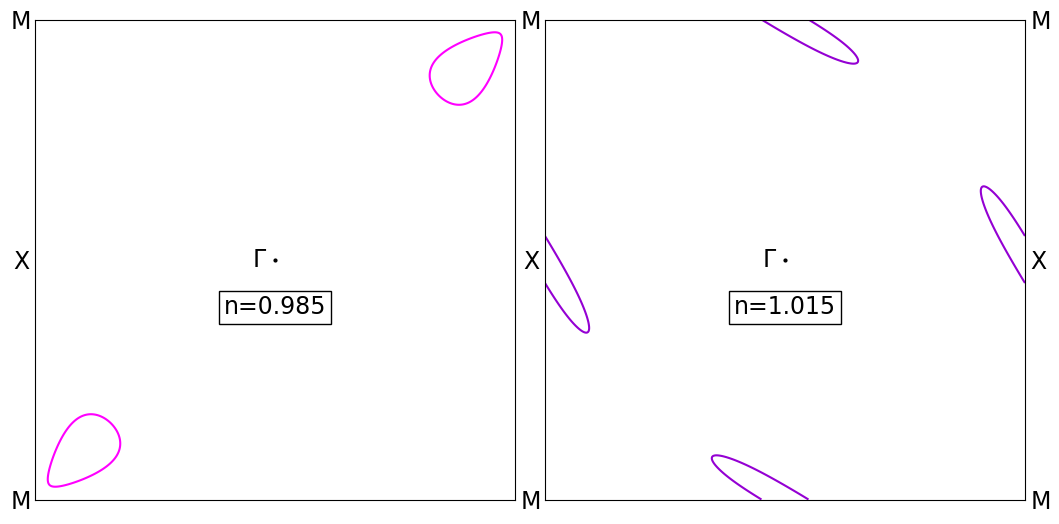

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path


#strain and doping
#n=0.985
U=3
N_A = 0.861571
N_B = -0.831570
mu  = -0.945686

#n=1.015
U2=3
N_A2 = 0.831679
N_B2 = -0.861695
mu2  = 1.156989



fig= plt.figure( figsize=(12, 6))

# === Grid and constants ===
n_k2 = 500
kx = np.linspace(-np.pi, np.pi, n_k2)
ky = np.linspace(-np.pi, np.pi, n_k2)
KX, KY = np.meshgrid(kx, ky)

ax1=fig.add_axes([0.05,0.1,0.45,0.8])

E_up_plus, E_up_minus, E_down_plus, E_down_minus = energy_split(KX, KY, N_A, N_B, U,  mu, 0.05)

cont1 = ax1.contour(KX, KY, E_down_plus, levels=[0], colors='darkviolet', linewidths=1.5)
cont2 = ax1.contour(KX, KY, E_down_minus, levels=[0], colors='magenta', linewidths=1.5)
cont3 = ax1.contour(KX, KY, E_up_plus, levels=[0], colors='turquoise', linewidths=1.5)
cont4 = ax1.contour(KX, KY, E_up_minus, levels=[0], colors='cyan',  linewidths=1.5)

#ax1.set_xlabel("$k_x$",fontsize=13)
#ax1.set_ylabel("$k_y$",fontsize=13)

ax1.set_aspect('equal', adjustable='box')

tick_positions = [-np.pi,0, np.pi]
tick_labels = [r'$\text{M}$', r'$\text{X}$', r'$\text{M}$']
ax1.set_xticks(tick_positions,[], fontsize=17)
ax1.set_yticks(tick_positions, tick_labels, fontsize=17)
ax1.tick_params(axis='x', which='both',length=0)
ax1.tick_params(axis='y', which='both', left=True, right=True,length=0)

ax1.text(
    0.5, 0.4,                    # x, y position in axes coordinates (0–1)
    'n=0.985',              # text content
    transform=ax1.transAxes,        # interpret x,y as relative to the axes
    ha='center', va='center',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',
        linewidth=1,         # border color
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)
ax1.plot(0, 0, 'o', color='black',markersize=2) 
ax1.text(
    -0.3, -0.1,               # slightly offset from the point
    r'$\Gamma$',                      # LaTeX Gamma symbol
    fontsize=17,
)


# === Legend ===
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', label=r'$\uparrow, \beta=+1$'),
    Line2D([0], [0], color='red', linestyle='dashed', label=r'$\uparrow, \beta=-1$'),
    Line2D([0], [0], color='blue', label=r'$\downarrow, \beta=+1$'),
    Line2D([0], [0], color='blue', linestyle='dashed', label=r'$\downarrow, \beta=-1$')
]
#ax1.legend(handles=legend_elements, loc='center', fontsize=10)



# === Strained Case ===
ax2=fig.add_axes([0.475,0.1,0.45,0.8])

E_up_plus_s, E_up_minus_s, E_down_plus_s, E_down_minus_s = energy_split(KX, KY, N_A2, N_B2, U2, mu2, 0.05)

cont5 = ax2.contour(KX, KY, E_down_plus_s, levels=[0], colors='darkviolet', linewidths=1.5)
cont6 = ax2.contour(KX, KY, E_down_minus_s, levels=[0], colors='magenta',  linewidths=1.5)
cont7 = ax2.contour(KX, KY, E_up_plus_s, levels=[0], colors='turquoise', linewidths=1.5)
cont8 = ax2.contour(KX, KY, E_up_minus_s, levels=[0], colors='cyan',  linewidths=1.5)


# === Plot labels, grid, etc. ===
tick_positions = [-np.pi,0, np.pi]
tick_labels = [r'$\text{M}$', r'$\text{X}$', r'$\text{M}$']
ax2.set_xticks(tick_positions,[] , fontsize=17)
ax2.set_yticks(tick_positions, tick_labels, fontsize=17)
ax2.tick_params(axis='x', which='both',length=0)
ax2.tick_params(axis='y', which='both', left=True, right=True,labelright=True,length=0)

ax2.text(
    0.5, 0.4,                    # x, y position in axes coordinates (0–1)
    'n=1.015',              # text content
    transform=ax2.transAxes,        # interpret x,y as relative to the axes
    ha='center', va='center',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',
        linewidth=1,         # border color
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)

ax2.plot(0, 0, 'o', color='black',markersize=2) 
ax2.text(
    -0.3, -0.1,               # slightly offset from the point
    r'$\Gamma$',                      # LaTeX Gamma symbol
    fontsize=17,
)



#plt.title(f"$E_F = 0$, $\epsilon={epsilo}$, $M_s={magnetization_strained:.4f}$  ")
#ax2.set_xlabel("$k_x$",fontsize=13)
#ax2.set_ylabel("$k_y$",fontsize=13)



# === Legend ===
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', label=r'$\uparrow, \beta=+1$'),
    Line2D([0], [0], color='red', linestyle='dashed', label=r'$\uparrow, \beta=-1$'),
    Line2D([0], [0], color='blue', label=r'$\downarrow, \beta=+1$'),
    Line2D([0], [0], color='blue', linestyle='dashed', label=r'$\downarrow, \beta=-1$')
]
#ax2.legend(handles=legend_elements, loc='center', fontsize=10)
ax2.set_aspect('equal', adjustable='box')


plt.savefig('fermi surface doping strain 0.05 U=3.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()


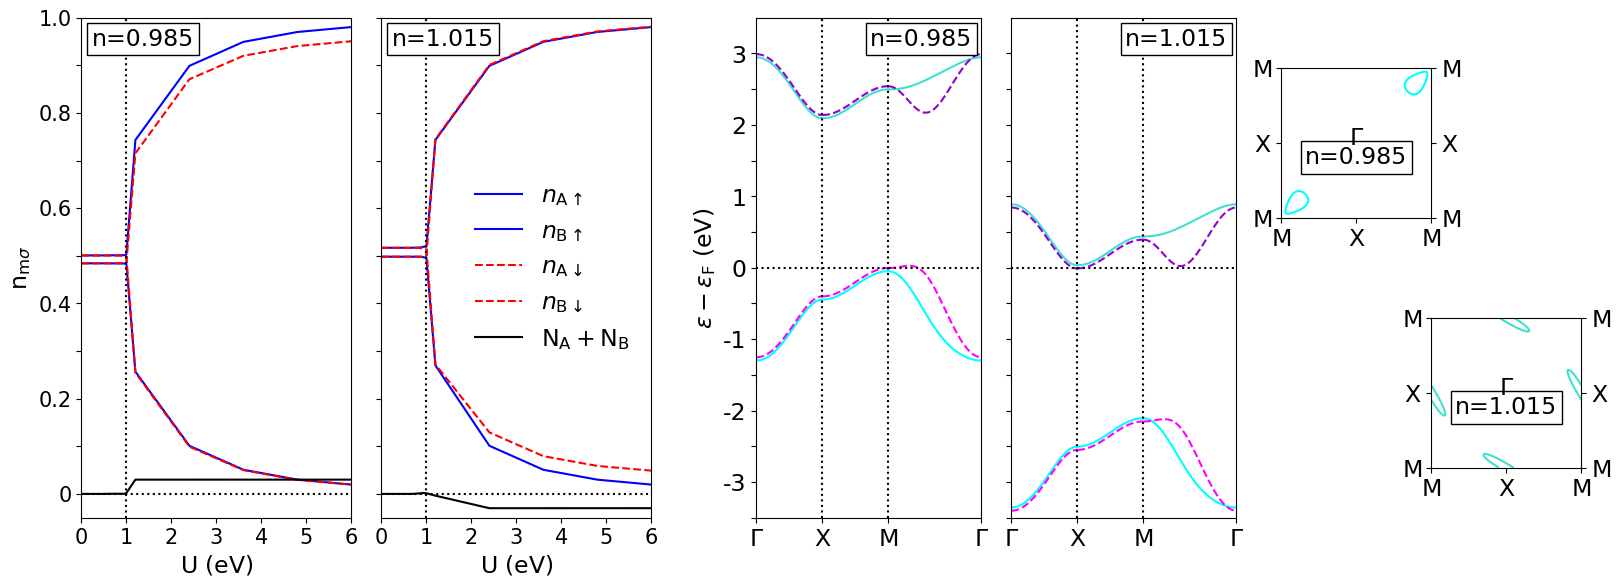

In [352]:
fig= plt.figure( figsize=(15, 5))

ax3 = fig.add_axes([0, 0, 0.18, 1])
ax4 = fig.add_axes([0.2, 0, 0.18, 1])
ax1 = fig.add_axes([0.45, 0, 0.15, 1])
ax2 = fig.add_axes([0.62, 0, 0.15, 1])

ax5 = fig.add_axes([0.8, 0.5, 0.1, 0.5])
ax6 = fig.add_axes([0.9, 0, 0.1, 0.5])


G = np.array([0, 0])
X = np.array([np.pi, 0])
M = np.array([np.pi, np.pi])
path = [G, X, M, G]
labels = [r'$\Gamma$', r'$\text{X}$', r'$\text{M}$', r'$\Gamma$']
points_per_segment = 200


#strain and doping
#n=0.985
U=3
N_A = 0.861571
N_B = -0.831570
mu  = -0.945686

#n=1.015
U2=3
N_A2 = 0.831679
N_B2 = -0.861695
mu2  = 1.156989

epsilo= 0.05 

k1=np.linspace(0,np.pi,100)
k0=np.full_like(k1,0) 
k2=np.full_like(k1,np.pi)
k3=np.linspace(np.pi,0,100)


E1=energy_split(k1, k0, N_A, N_B, U, mu, epsilo)
E2=energy_split(k2, k1, N_A, N_B, U, mu, epsilo)
E3=energy_split(k3, k3, N_A, N_B, U, mu, epsilo)


#plotting all bands for each path between high symmetry points
ax1.plot(np.linspace(0,1,100), E1[0], label=r'$\uparrow$, $\beta=+1$', color='turquoise')
ax1.plot(np.linspace(0,1,100), E1[1], label=r'$\uparrow$, $\beta=-1$ ', color='cyan')
ax1.plot(np.linspace(0,1,100), E1[2], '--',color='darkviolet')
ax1.plot(np.linspace(0,1,100), E1[3],'--', color='magenta')

ax1.plot(np.linspace(1,2,100), E2[0], color='turquoise')
ax1.plot(np.linspace(1,2,100), E2[1], color='cyan')
ax1.plot(np.linspace(1,2,100), E2[2], '--',color='darkviolet')
ax1.plot(np.linspace(1,2,100), E2[3],'--',  color='magenta')

ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[0], color='turquoise')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[1], color='cyan')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[2], '--',label=r'$\downarrow$, $\beta=+1$', color='darkviolet')
ax1.plot(np.linspace(2,2+np.sqrt(2),100), E3[3],'--', label=r'$\downarrow$, $\beta=-1$', color='magenta')




# Set custom x-axis ticks and labels
tick_positions = [0,1,2,2+np.sqrt(2)]
tick_labels = labels
ax1.set_xticks(tick_positions, tick_labels, fontsize=17)

y_tick_positions=[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3]
y_tick_labels=[_,-3,_,-2,_,-1,_,0,_,1,_,2,_,3]
ax1.set_yticks(y_tick_positions,y_tick_labels, fontsize=17)



# Dotted vertical line at x = 2
ax1.axvline(x=1, linestyle=':', linewidth=1.5,color='black')
ax1.axvline(x=2, linestyle=':', linewidth=1.5,color='black')

# Dotted horizontal line at y = 3
ax1.axhline(y=0, linestyle=':', linewidth=1.5,color='black')


ax1.text(
    0.96, 0.98,                    # x, y position in axes coordinates (0–1)
    'n=0.985',              # text content
    transform=ax1.transAxes,        # interpret x,y as relative to the axes
    ha='right', va='top',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',         # border color
        linewidth=1,
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)

#plt.xlabel("k-path")
ax1.set_ylabel(r"$\epsilon-\epsilon_\text{F}\text{ }(\text{eV})$",fontsize=17)
#plt.title(f"Band Dispersion along High-Symmetry Path for $\epsilon$={epsilo}")
ax1.set_xlim(0,2+np.sqrt(2))
ax1.set_ylim(-3.5,3.5)
#plt.grid(True)
#ax1.legend(loc='upper left')



E12=energy_split(k1, k0, N_A2, N_B2, U2, mu2, epsilo)
E22=energy_split(k2, k1, N_A2, N_B2, U2, mu2, epsilo)
E32=energy_split(k3, k3, N_A2, N_B2, U2, mu2, epsilo)


#plotting all bands for each path between high symmetry points
ax2.plot(np.linspace(0,1,100), E12[0], label=r'$\uparrow$, $\beta=+1$', color='turquoise')
ax2.plot(np.linspace(0,1,100), E12[1], label=r'$\uparrow$, $\beta=-1$ ', color='cyan')
ax2.plot(np.linspace(0,1,100), E12[2], '--',color='darkviolet')
ax2.plot(np.linspace(0,1,100), E12[3],'--', color='magenta')

ax2.plot(np.linspace(1,2,100), E22[0], color='turquoise')
ax2.plot(np.linspace(1,2,100), E22[1], color='cyan')
ax2.plot(np.linspace(1,2,100), E22[2], '--',color='darkviolet')
ax2.plot(np.linspace(1,2,100), E22[3],'--',  color='magenta')

ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[0], color='turquoise')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[1], color='cyan')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[2], '--',label=r'$\downarrow$, $\beta=+1$', color='darkviolet')
ax2.plot(np.linspace(2,2+np.sqrt(2),100), E32[3],'--', label=r'$\downarrow$, $\beta=-1$', color='magenta')




# Set custom x-axis ticks and labels
tick_positions = [0,1,2,2+np.sqrt(2)]
tick_labels = labels
ax2.set_xticks(tick_positions, tick_labels, fontsize=17)

y_tick_positions=[-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3]
y_tick_labels=[]
ax2.set_yticks(y_tick_positions,y_tick_labels, fontsize=15)



# Dotted vertical line at x = 2
ax2.axvline(x=1, linestyle=':', linewidth=1.5,color='black')
ax2.axvline(x=2, linestyle=':', linewidth=1.5,color='black')

# Dotted horizontal line at y = 3
ax2.axhline(y=0, linestyle=':', linewidth=1.5,color='black')


ax2.text(
    0.96, 0.98,                    # x, y position in axes coordinates (0–1)
    'n=1.015',              # text content
    transform=ax2.transAxes,        # interpret x,y as relative to the axes
    ha='right', va='top',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',
        linewidth=1,         # border color
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)

#plt.xlabel("k-path")
#ax2.set_ylabel(r"$\epsilon-\epsilon_\text{F}\text{ }(\text{eV})$",fontsize=15)
#plt.title(f"Band Dispersion along High-Symmetry Path for $\epsilon$={epsilo}")
ax2.set_xlim(0,2+np.sqrt(2))
ax2.set_ylim(-3.5,3.5)
#plt.grid(True)
#ax2.legend(loc='upper left')


ax3.plot(U_arr, n_up_Ah_list, c='blue', label=r'$n_{\text{A}\uparrow}$')
ax3.plot(U_arr, n_up_Bh_list, c='blue',label=r'$n_{\text{B}\uparrow}$')
ax3.plot(U_arr, n_down_Ah_list, c='red', linestyle='--',label=r'$n_{\text{A}\downarrow}$')
ax3.plot(U_arr, n_down_Bh_list, c='red',linestyle='--',label=r'$n_{\text{B}\downarrow}$')

ax3.plot(U_arr, np.array(n_up_Ah_list)-np.array(n_down_Ah_list)+np.array(n_up_Bh_list)-np.array(n_down_Bh_list),color='black',label=r'$\text{N}_\text{A}+\text{N}_\text{B}$')

    
ax3.axvline(x=1, linestyle=':', linewidth=1.5,color='black')
ax3.axhline(y=0, linestyle=':', linewidth=1.5,color='black')

ax3.set_xlim(0,6)


x_tick_positions=[0,1,2,3,4,5,6]
x_tick_labels=[0,1,2,3,4,5,6]
ax3.set_xticks(x_tick_positions,x_tick_labels, fontsize=15)

y_tick_positions=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
y_tick_labels=[0,_,0.2,_,0.4,_,0.6,_,0.8,_,1.0]
ax3.set_yticks(y_tick_positions,y_tick_labels, fontsize=15)

ax3.text(
    0.04, 0.98,                    # x, y position in axes coordinates (0–1)
    'n=0.985',              # text content
    transform=ax3.transAxes,        # interpret x,y as relative to the axes
    ha='left', va='top',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',
        linewidth=1,         # border color
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)

ax3.set_ylim(-0.05,1)
ax3.set_xlabel(r'$\text{U } (\text{eV})$',fontsize=17)
ax3.set_ylabel(r'$\text{n}_{\text{m}\sigma}$',fontsize=17)
#ax3.legend(loc='right',framealpha=0.0,fontsize=17)






ax4.plot(U_arr, n_up_Ae_list, c='blue', label=r'$n_{\text{A}\uparrow}$')
ax4.plot(U_arr, n_up_Be_list, c='blue',label=r'$n_{\text{B}\uparrow}$')
ax4.plot(U_arr, n_down_Ae_list, c='red', linestyle='--',label=r'$n_{\text{A}\downarrow}$')
ax4.plot(U_arr, n_down_Be_list, c='red',linestyle='--',label=r'$n_{\text{B}\downarrow}$')

ax4.plot(U_arr, np.array(n_up_Ae_list)-np.array(n_down_Ae_list)+np.array(n_up_Be_list)-np.array(n_down_Be_list),color='black',label=r'$\text{N}_\text{A}+\text{N}_\text{B}$')


ax4.axvline(x=1, linestyle=':', linewidth=1.5,color='black')
ax4.axhline(y=0, linestyle=':', linewidth=1.5,color='black')

ax4.set_xlim(0,6)


x_tick_positions=[0,1,2,3,4,5,6]
x_tick_labels=[0,1,2,3,4,5,6]
ax4.set_xticks(x_tick_positions,x_tick_labels, fontsize=15)

y_tick_positions=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
y_tick_labels=[]
ax4.set_yticks(y_tick_positions,y_tick_labels, fontsize=15)

ax4.text(
    0.04, 0.98,                    # x, y position in axes coordinates (0–1)
    'n=1.015',              # text content
    transform=ax4.transAxes,        # interpret x,y as relative to the axes
    ha='left', va='top',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',
        linewidth=1,         # border color
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)

ax4.set_ylim(-0.05,1)
ax4.set_xlabel(r'$\text{U } (\text{eV})$',fontsize=17)
#ax4.set_ylabel(r'$\text{n}_{\text{m}\sigma}$',fontsize=17)
ax4.legend(loc='right',framealpha=0.0,fontsize=17)








n_k2 = 500
kx = np.linspace(-np.pi, np.pi, n_k2)
ky = np.linspace(-np.pi, np.pi, n_k2)
KX, KY = np.meshgrid(kx, ky)


E_up_plus, E_up_minus, E_down_plus, E_down_minus = energy_split(KX, KY, N_A, N_B, U,  mu, 0.05)

cont1 = ax5.contour(KX, KY, E_up_plus, levels=[0], colors='darkviolet', linewidths=1.5)
cont2 = ax5.contour(KX, KY, E_up_minus, levels=[0], colors='magenta', linewidths=1.5)
cont3 = ax5.contour(KX, KY, E_down_plus, levels=[0], colors='turquoise', linewidths=1.5)
cont4 = ax5.contour(KX, KY, E_down_minus, levels=[0], colors='cyan',  linewidths=1.5)

#ax1.set_xlabel("$k_x$",fontsize=13)
#ax1.set_ylabel("$k_y$",fontsize=13)

ax5.set_aspect('equal', adjustable='box')

tick_positions = [-np.pi,0, np.pi]
tick_labels = [r'$\text{M}$', r'$\text{X}$', r'$\text{M}$']
ax5.set_xticks(tick_positions, tick_labels, fontsize=17)
ax5.set_yticks(tick_positions, tick_labels, fontsize=17)
ax5.tick_params(axis='y', which='both', left=True, right=True,labelright=True)

ax5.text(
    0.5, 0.4,                    # x, y position in axes coordinates (0–1)
    'n=0.985',              # text content
    transform=ax5.transAxes,        # interpret x,y as relative to the axes
    ha='center', va='center',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',
        linewidth=1,         # border color
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)


ax5.plot(0, 0, 'o', color='black',markersize=2) 
ax5.text(
    -0.3, -0.1,               # slightly offset from the point
    r'$\Gamma$',                      # LaTeX Gamma symbol
    fontsize=17,
)

# === Legend ===
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', label=r'$\uparrow, \beta=+1$'),
    Line2D([0], [0], color='red', linestyle='dashed', label=r'$\uparrow, \beta=-1$'),
    Line2D([0], [0], color='blue', label=r'$\downarrow, \beta=+1$'),
    Line2D([0], [0], color='blue', linestyle='dashed', label=r'$\downarrow, \beta=-1$')
]
#ax1.legend(handles=legend_elements, loc='center', fontsize=10)


E_up_plus_s, E_up_minus_s, E_down_plus_s, E_down_minus_s = energy_split(KX, KY, N_A2, N_B2, U2, mu2, 0.05)

cont5 = ax6.contour(KX, KY, E_up_plus_s, levels=[0], colors='darkviolet', linewidths=1.5)
cont6 = ax6.contour(KX, KY, E_up_minus_s, levels=[0], colors='magenta',  linewidths=1.5)
cont7 = ax6.contour(KX, KY, E_down_plus_s, levels=[0], colors='turquoise', linewidths=1.5)
cont8 = ax6.contour(KX, KY, E_down_minus_s, levels=[0], colors='cyan',  linewidths=1.5)


# === Plot labels, grid, etc. ===
tick_positions = [-np.pi,0, np.pi]
tick_labels = [r'$\text{M}$', r'$\text{X}$', r'$\text{M}$']
ax6.set_xticks(tick_positions, tick_labels, fontsize=17)
ax6.set_yticks(tick_positions, tick_labels, fontsize=17)
ax6.tick_params(axis='y', which='both', left=True, right=True,labelright=True)

ax6.text(
    0.5, 0.4,                    # x, y position in axes coordinates (0–1)
    'n=1.015',              # text content
    transform=ax6.transAxes,        # interpret x,y as relative to the axes
    ha='center', va='center',          # align text to the top-right
    fontsize=17,
    bbox=dict(
        facecolor='white',         # background color
        edgecolor='black',
        linewidth=1,         # border color
        boxstyle='square,pad=0.2'   # rounded box (optional)
    )
)
ax6.plot(0, 0, 'o', color='black',markersize=2) 
ax6.text(
    -0.3, -0.1,               # slightly offset from the point
    r'$\Gamma$',                      # LaTeX Gamma symbol
    fontsize=17,
)


#plt.title(f"$E_F = 0$, $\epsilon={epsilo}$, $M_s={magnetization_strained:.4f}$  ")
#ax2.set_xlabel("$k_x$",fontsize=13)
#ax2.set_ylabel("$k_y$",fontsize=13)



# === Legend ===
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', label=r'$\uparrow, \beta=+1$'),
    Line2D([0], [0], color='red', linestyle='dashed', label=r'$\uparrow, \beta=-1$'),
    Line2D([0], [0], color='blue', label=r'$\downarrow, \beta=+1$'),
    Line2D([0], [0], color='blue', linestyle='dashed', label=r'$\downarrow, \beta=-1$')
]
#ax2.legend(handles=legend_elements, loc='center', fontsize=10)
ax6.set_aspect('equal', adjustable='box')



#plt.tight_layout()
#plt.savefig('doping and strain 0.05 n(U) and dispersion along path.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

